<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-setup-functions" data-toc-modified-id="Imports-and-setup-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and setup functions</a></span></li><li><span><a href="#DataLoader-Module" data-toc-modified-id="DataLoader-Module-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DataLoader Module</a></span><ul class="toc-item"><li><span><a href="#Image-regions" data-toc-modified-id="Image-regions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Image regions</a></span><ul class="toc-item"><li><span><a href="#Find-interesting-regions-to-test-on" data-toc-modified-id="Find-interesting-regions-to-test-on-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Find interesting regions to test on</a></span></li><li><span><a href="#Cut-all-data-into-64x64-regions" data-toc-modified-id="Cut-all-data-into-64x64-regions-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Cut all data into 64x64 regions</a></span></li><li><span><a href="#Save-to-.npy-files" data-toc-modified-id="Save-to-.npy-files-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Save to .npy files</a></span></li></ul></li><li><span><a href="#Train-val-test-split" data-toc-modified-id="Train-val-test-split-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train-val-test split</a></span></li><li><span><a href="#Inputs-and-ends" data-toc-modified-id="Inputs-and-ends-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Inputs and ends</a></span></li><li><span><a href="#Tensors,-DataLoader" data-toc-modified-id="Tensors,-DataLoader-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Tensors, DataLoader</a></span></li><li><span><a href="#Create-DataLoader-for-training-data" data-toc-modified-id="Create-DataLoader-for-training-data-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Create DataLoader for training data</a></span></li></ul></li><li><span><a href="#Model-Module" data-toc-modified-id="Model-Module-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model Module</a></span><ul class="toc-item"><li><span><a href="#AR1:-linear-mapping" data-toc-modified-id="AR1:-linear-mapping-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>AR1: linear mapping</a></span></li><li><span><a href="#de-Bézenac-et-al,-2019:-CNN-with-warp-mapping" data-toc-modified-id="de-Bézenac-et-al,-2019:-CNN-with-warp-mapping-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>de Bézenac et al, 2019: CNN with warp mapping</a></span><ul class="toc-item"><li><span><a href="#Loss-Function" data-toc-modified-id="Loss-Function-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Loss Function</a></span></li><li><span><a href="#Warp" data-toc-modified-id="Warp-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Warp</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Training</a></span></li></ul></li></ul></li></ul></div>

# Imports and setup functions

In [1]:
import datetime
import math
import os
import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import netCDF4 as nc
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Function, Variable
from functools import reduce

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

torch.cuda.get_device_name(0)

True
1
0


'Tesla V100-PCIE-16GB'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla V100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
def datadir(x):
    return "/projectnb/labci/Lucia/data/" + x

# DataLoader Module

## Train-val-test split

The authors trained on SST data from 2006-2015 and tested on data from 2016-2017. For the IBI reanalysis SST data, we only have from June 5, 2021 to June 23, 2023 (749 days). From these, we will use 80% for training, 10% for validation, and 10% for testing. 

In [5]:
def all_days(files):
    """Helper method to take a list of filenames and return total the number 
    of days represented by the files in the list. 
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    files : list : data file names
    
    Returns
    -------
    delta : int : the number of days represented by the inputted files
    """
    
    files.sort()
    
    first = datetime.datetime.strptime(files[0][8:16], "%Y%m%d").date()
    last = datetime.datetime.strptime(files[len(files)-1][8:16], "%Y%m%d").date()
    
    delta = int((last - first) / datetime.timedelta(days=1))
    
    return delta

def train_val_test_cutoffs(topdir, split):
    """Helper method to create lists of filenames for the train, val, and test
    data splits. Uses the dates in the filenames to determine file order and 
    split cutoffs.
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
       
    Parameters
    ----------
    topdir : string : the path to the directory holding the data
    split : list : the fractions for each split, eg. [0.8, 0.1, 0.1]
    
    Returns
    -------
    cutoffs : list : date cutoffs for each split
    """
    
    all_files = os.listdir(topdir)
    all_files.sort()
    nfiles = len(all_files)
    ndays = all_days(all_files)
    
    start_date = datetime.datetime.strptime(all_files[0][8:16], "%Y%m%d").date()
    end_date = datetime.datetime.strptime(all_files[nfiles-1][8:16], "%Y%m%d").date()
    
    cutoffs = []
    
    for i in range(3):
        delta = math.floor(ndays*split[i])
        end = start_date + datetime.timedelta(days=delta)
        cutoffs.append(end)
        
        start_date = end
        
    # Because of rounding, some files may have been missed
    # Add these to the test split
    if cutoffs[2] < end_date:
        cutoffs[2] = end_date
    
    return cutoffs

def train_val_test_split_files(topdir, split):
    """Method to split the data in a directory into training, validation, and
    test sets. Uses the helper method train_val_test_cutoffs().
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    topdir : string : the path to the directory holding the data
    split : list : the fractions for each split, eg. [0.8, 0.1, 0.1]
    
    Returns
    -------
    train : list : list of filenames for the train set
    val : list : list of filenames for the validation set
    test : list : list of filenames for the test set
    """
    
    assert len(split) == 3, "Please include a % split for train, validation, and test sets."
    
    cutoffs = train_val_test_cutoffs(topdir, split)
    
    all_files = os.listdir(topdir)
    all_files.sort()
    
    train, val, test = [], [], []
    
    for f in all_files:
        file_date = datetime.datetime.strptime(f[8:16], "%Y%m%d").date()
        
        if file_date <= cutoffs[0]:
            train.append(f)
        elif (file_date > cutoffs[0]) & (file_date <= cutoffs[1]):
            val.append(f)
        else:
            test.append(f)
            
    return train, val, test

In [6]:
def load_data_from_file(filename):
    """Helper method to load a single .npy file."""
    return np.load(datadir("sst_npy/" + filename))


def load_data_from_files(files):
    """Method to load data from a list of .npy files."""
    data = []
    for f in files:
        data.append(load_data_from_file(f))
        
    return np.array(data)

## Inputs and ends

In [7]:
def search_by_region(files, region):
    """Helper method to search a list of files for only those corresponding to
    a desired region. 
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    files : list : list of filenames in which to search
    region : int : desired region
    
    Returns
    -------
    region_files : list : sorted list of matching files
    """
    
    region_files = []
    for fname in files:
        if "region_" + str(region) + ".npy" in fname:
            region_files.append(fname)
            
    region_files.sort()
    
    return region_files

def get_pairs_by_region(files, region, ndays=1):
    """Method to separate data into inputs (X) and ends (y), for example to
    use 4 previous days (ndays=4) to predict the next day. The "pairs" are 
    pairs of (X,y) inputs and ends. This method works on one region at a time.
    
    Parameters
    ----------
    files : list : list of files from which to get pairs
    region : int : desired region
    ndays : int : number of days to use as inputs
    
    Returns
    -------
    inps : np.ndarray : filenames for inputs
    ends : list : filenames for ends
    """
    
    region_files = search_by_region(files, region)
    
    n = len(region_files)
    
    inps = []
    ends = region_files[ndays:]
    
    for i in range(n - ndays):
        inps.append(region_files[i:i+ndays])
    
    return np.array(inps), np.array(ends)

In [8]:
def all_regions(files):
    """Helper method to take a list of filenames and return a list of the 
    unique region numbers. 
    
    This method assumes a particular file naming convention that has been used 
    for this project. 
    
    File naming convention: sst_geo_yyyymmdd.nc_region_XX.npy
    
    Parameters
    ----------
    files : list : data file names
    
    Returns
    -------
    regions : list : list of unique region numbers in the directory
    """
    
    files.sort()
    regions = []
    
    for f in files:
        if "region_" in f:
            
            start_ind = f.find("region_") + len("region_")
            end_ind = f.find(".npy")
            
            reg = f[start_ind:end_ind]
            
            if int(reg) not in regions:
                regions.append(int(reg))
            
        else:
            print("Files in this directory do not match the naming convention.")
    
    regions.sort()
    
    return regions

## Tensors, DataLoader

In [9]:
def create_dataloader(batchsize, files, ndays, dtype=torch.FloatTensor, shuff=True, all_data=True, regs=None):
    """Method to create a PyTorch DataLoader object from a list of files and
    additional parameters.
    
    Parameters
    ----------
    dtype : torch.dtype : the data type for the DataLoader
    batchsize : int : the desired batchsize for loading data
    files : str : a list of files holding data to put into the DataLoader
    ndays : int : the number of days to use as inputs to predict the next day
    
    Returns
    -------
    loader : torch.utils.data.DataLoader : the DataLoader object
    """
    
    if all_data:
        regions = all_regions(files)
    else:
        regions = regs

    data = []
    ends = []

    for reg in regions:
        reg_pairs = get_pairs_by_region(files, reg, ndays)
        
        for i in range(len(reg_pairs[0])):
            dat = load_data_from_files(reg_pairs[0][i])
            end = load_data_from_file(reg_pairs[1][i])
        
            data.append(dat)
            ends.append(end)
        
    final_data = torch.from_numpy(np.array(data)).type(dtype)
    final_ends = torch.from_numpy(np.array(ends)).type(dtype)
    
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(final_data, final_ends),
                                           batch_size=batchsize, shuffle=shuff)
    
    return loader

# Model Module

## de Bézenac et al, 2019: CNN with warp mapping

### Loss Function

The authors used a Charbonnier penality to measure the discrepancy between the predicted next image and the target: 

$\rho(x) = (x + \epsilon)^\frac{1}{\alpha}$

Note that with $\epsilon=0$ and $\alpha=\frac{1}{2}$, we recover the $\textit{l}_2$ norm. 

Additional penalty terms were added to the loss function, specifically to regulate the divergence of the displacement $\omega$ between the prediction and the target, its magnitude, and its smoothness:

$L_t = \underset{x \in \Omega}\Sigma \rho(\hat{I}_{t+1}(x) - I_{t+1}(x)) + \lambda_{div}(\nabla.\omega_t(x))^2 + \lambda_{magn}||\omega_t(x)||^2 + \lambda_{grad}||\nabla \omega_t(x)||^2$

In [10]:
def charbonnier_loss(y_pred, y, alpha=0.5, epsilon=0):
    error = torch.sum((y_pred - y)**2, axis=1)
    loss = torch.mean(torch.pow(error + epsilon, (1. / alpha)))
    return loss

### Warp

The future image is calculated based on a "warp" of the motion field estimate, $\hat{\omega}$, which can be thought of in this application as the wind vector field:

$\hat{I}_{t+1}(x) = \underset{y \in \Omega} \Sigma k(x - \hat{\omega}(x), y) I_t (y)$

where $k(u, v)$ is a radial basis function kernel, or equivalent a 2D Gaussian probability distribution:

$k(x - \hat{\omega}(x), y) = \frac{1}{4 \pi D\Delta t}e^{\frac{-1}{4D \Delta t} ||x - \hat{\omega}(x) - y||^2}$

for diffusion coefficient D and time step value $\Delta t$ between $t$ and $t+1$.

### Model

In [11]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear):
                
                # He initialization, from He, K. et al, 2015
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
                    
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

In [12]:
class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_EncoderBlock, self).__init__()
        self.cv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.lr1 = nn.LeakyReLU(0.1)
        self.cv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.lr2 = nn.LeakyReLU(0.1)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=1)
        
    def forward(self, x):
        residual=x
        #print("residual",residual.shape)
        out=self.cv1(x)
        #print("cv1",out.shape)
        out=self.bn1(out)
        #print("bn1",out.shape)
        out=self.lr1(out)
        #print("lr1",out.shape)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.maxp(out)
        return out

class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.cv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.lr1 = nn.LeakyReLU(0.1)
        self.cv2 = nn.Conv2d(in_channels, middle_channels, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(middle_channels) 
        self.lr2 = nn.LeakyReLU(0.1)
        self.tcv = nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3)
        
    def forward(self, x):
        residual=x
        #print("residual",residual.shape)
        out=self.cv1(x)
        #print("cv1",out.shape)
        out=self.bn1(out)
        #print("bn1",out.shape)
        out=self.lr1(out)
        #print("lr1",out.shape)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.tcv(out)
        return out

class _CenterBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_CenterBlock, self).__init__()
        self.cv1 = nn.Conv2d(in_channels,in_channels , kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)  
        self.lr1 = nn.LeakyReLU(0.1)
        self.cv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(out_channels) 
        self.lr2 = nn.LeakyReLU(0.1)
        self.tcv = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3)
        
    def forward(self, x):
        residual=x
        out=self.cv1(x)
        out=self.bn1(out)
        out=self.lr1(out)
        out+=residual
        out=self.cv2(out)
        out=self.bn2(out)
        out=self.lr2(out)
        out=self.tcv(out)
        return out

In [13]:
class CDNN(nn.Module):
    """Class to implement a physics-driven Convolution-Deconvolution Neural 
    Network (CDNN) as described in (de Bezenac et al, 2019). This model 
    takes as input historical image(s) of Sea Surface Temperature (SST)
    data, X, and uses a convolutional neural network (CNN) to estimate the 
    wind vector field W that drives the motion of X. From there, the next 
    image is predicted using a "warping" of the most recent input image and W,
    as if to see how the SST variable evolves with the wind. 
    
    The "warping" in this paper is a radial basis function kernel, or a 
    Gaussian centered in X-W. Other models we will implement later may use a
    different warping scheme. 
    """
    
    def __init__(self, hist=1):
        """Function to construct the model. 
           
           Parameters
           ----------
           hist : int : the number of days of "history" to use for prediction, 
                        default = 1.
        """
        
        super(CDNN, self).__init__()
        
        self.enc1 = _EncoderBlock(hist, 64)  
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512)
        self.dec4 = _CenterBlock(512, 386)
        self.dec3 = _DecoderBlock(386+256, 256, 194)
        self.dec2 = _DecoderBlock(194+128, 128, 98)
        self.dec1 = _DecoderBlock(98+64, 64, 2)
        
        self.final = nn.Sequential(nn.Conv2d(2, 2, kernel_size=3),) 
        initialize_weights(self)

        self.hist = hist

    def wind(self, x):
        """Function to estimate the wind vector field from historical input images.
        
        Parameters
        ----------
        x : torch.FloatTensor : the historical input images
        
        Returns
        -------
        wind : torch.FloatTensor : the estimated wind vector field
        """
        
        enc1 = self.enc1(x)
        #print("x",x.shape)
        #print("enc1",enc1.shape)
        enc2 = self.enc2(enc1)
        #print("enc2",enc2.shape)
        enc3 = self.enc3(enc2)
        #print("enc3",enc3.shape)
        enc4 = self.enc4(enc3)
        #print("enc4",enc4.shape)
        dec4 = self.dec4(enc4)
        #print("dec4",dec4.shape)
        
        dec3 = self.dec3(torch.cat([dec4, F.interpolate(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.interpolate(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.interpolate(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        
        wind = F.interpolate(final, x.size()[2:], mode='bilinear')

        return wind
    
    @staticmethod
    def kernel(distsq, D, dt):
        """Method to implement the k() function or radial basis function kernel 
        described above.
    
        Parameters
        ----------
        distsq : float or torch.FloatTensor : the value of the squared norm of 
                 the distance
        D : float : the diffusion coefficient
        dt : float : the timestep
    
        Returns
        -------
        res : float or torch.FloatTensor: the result of the function
        """
    
        res = torch.exp(-distsq/(4*D*dt))/(4*np.pi*D*dt)
        return res
    
    @staticmethod
    def warp(I, W, hist):
        """Function to compute the warping of the input data and an estimated 
        wind vector field, in order to produce an output predicted image. 
        
        Parameters
        ----------
        I : torch.FloatTensor : the most recent input image to warp
        W : torch.FloatTensor : the estimated wind vector field
        
        Returns
        -------
        warped : torch.FloatTensor : the warped prediction image
        """
        
        D = 0.45
        dt = 1
        
        interval=torch.arange(I.size()[-1]).type(torch.FloatTensor)
        
        x1 = interval[None,:,None,None,None].to(device)
        x2 = interval[None,None,:,None,None].to(device)
        y1 = interval[None,None,None,:,None].to(device)
        y2 = interval[None,None,None,None,:].to(device)
        
        # x - wind - y
        distsq = (x1-y1-W[:,0,:,:,None,None])**2+(x2-y2-W[:,1,:,:,None,None])**2 
        mult = I[:, hist-1, None,None,:,:] * CDNN.kernel(distsq, D, dt)
        warped = mult.sum(4).sum(3)
        
        return warped

    def forward(self, x):
        """Function to execute the forward pass of the model. All of the 
        computations are done in the methods above, so this function 
        simply returns their outputs.
        
        Note: the wind vector field W is returned for use in the 
        regularized loss function later. For simple difference loss 
        functions, returning y_pred is sufficient. 
        
        Parameters
        ----------
        x : torch.FloatTensor : the historical input images
        
        Returns
        -------
        W : torch.FloatTensor : the estimated wind vector field
        y_pred : torch.FloatTensor : the predicted next image
        """
        
        W = self.wind(x)
        #W.to(device)
        y_pred = self.warp(x, W, self.hist)
        #y_pred.to(device)
        
        return W, y_pred 
    
    @staticmethod
    def compute_regloss(F):
        gradient = reduce(torch.add, torch.gradient(F))
    
        #divergence = np.array([np.mean(gradient.sum(0)**2)])                         # 1st reg term above
        #magnitude = np.array([np.mean(np.linalg.norm(F, axis=0, ord=2)**2)])         # 2nd reg term above
        #smoothness = np.array([np.mean(np.linalg.norm(gradient, axis=0, ord=2)**2)]) # 3rd reg term above
        magnitude = torch.Tensor([torch.mean(torch.linalg.norm(F, axis=0, ord=2)**2)]).to(device)
        
        return magnitude.type(torch.FloatTensor)
    
    @staticmethod
    def loss(y_pred, y, reg=False, coeff=-0.1):
        error = torch.sum((y_pred - y)**2, axis=1)
        loss = torch.mean(error) 
        
        if reg:
            reg_term = compute_regloss(w[0,:,:,:])
            loss += coeff*reg_term
        
        return loss

## Experiments

### Setup

In [14]:
class Experiment():
    
    def __init__(self, name, trainset, valset, testset, model, regloss, test_loss, optimizer, outdir):
        self.name = name
        self.train_loader = trainset 
        self.val_loader = valset
        self.test_loader = testset
        self.model = model
        self.loss_fn = model.loss
        self.regloss = regloss
        self.test_loss = test_loss
        self.optimizer = optimizer
        
        self.train_losses = []
        self.val_losses = []
        self.test_losses  = []
        
        # Set up a directory for the experiment
        self.dir_setup(outdir)
        
    def dir_setup(self, parent):
        self.outdir = parent + "/" + self.name
        os.mkdir(self.outdir)
        print("Created new directory to save model states and results: " + self.outdir)
    
    def train_loop(self):
        size = len(self.train_loader.dataset)
        # Set the model to training mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        self.model.train()
    
        losses = []
    
        for batch, (X, y) in enumerate(self.train_loader):
            # Compute prediction and loss
            X = X.to(device) 
            y = y.to(device)
            
            outputs = self.model(X)
            
            wind = outputs[0]
            y_pred = outputs[1]
            
            if self.regloss:
                loss = self.loss_fn(y_pred, y, wind, self.regloss)
            else:
                loss = self.loss_fn(y_pred, y, self.regloss)
                
            losses.append(loss.item())
        
            print("Step:", batch, "Loss:", loss)
        
            # Backpropagation
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        
        return losses
    
    def val_loop(self):
        # Set the model to evaluation mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        self.model.eval()
        losses = []
        num_loops = 0

        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also reduces unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in self.val_loader:
                X = X.to(device) 
                y = y.to(device)
                outputs = self.model(X)
                y_pred = outputs[1]
            
                step_loss = self.loss_fn(y_pred, y).item()
                losses.append(step_loss)
                num_loops += 1

        return np.mean(losses)
    
    def test(self):
        # Set the model to evaluation mode - important for batch normalization and dropout layers
        # Unnecessary in this situation but added for best practices
        self.model.eval()
        losses = []
        num_loops = 0

        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        # also reduces unnecessary gradient computations and memory usage for tensors with requires_grad=True
        with torch.no_grad():
            for X, y in self.test_loader:
                X = X.to(device) 
                y = y.to(device)
                outputs = self.model(X)
                y_pred = outputs[1]
            
                step_loss = self.test_loss(y_pred, y).item()
                print("Item:", num_loops, "Loss:", step_loss)
                losses.append(step_loss)
                num_loops += 1

        return losses
    
    def save_results(self, losses, fname):
        np.save(fname + ".npy", losses)
    
    def save_model_state(self, epoch):
        
        fname = self.outdir + "/" + "modelCheckpoints/" + self.name + "_epoch_" + str(epoch) + ".pt"
        
        try:
            os.mkdir(self.outdir + "/" + "modelCheckpoints")
        except FileExistsError as e:
            pass
        finally:
            torch.save(self.model, fname)
        
        print("Saved checkpoint at epoch", epoch)
    
    def run(self, epochs):
        print("Running experiment: " + self.name + "...")
        
        # -------------------- Training -------------------------
        
        print("Training over " + str(epochs) + " epochs...")
                
        for t in range(epochs):
            print(f"Epoch {t}\n-------------------------------")
            
            start = datetime.datetime.now()
            epoch_losses = self.train_loop()
            
            fname = self.outdir + "/train_epoch_" + str(t)
            self.save_results(epoch_losses, fname)
            
            epoch_mean = np.round(np.mean(epoch_losses), 5)
            val_loss = np.round(self.val_loop(), 5)
            
            print("Mean Training Loss:", epoch_mean)
            print("Validation Loss: ", val_loss)        
            print("Epoch Runtime:", datetime.datetime.now() - start)
            
            self.train_losses.append(epoch_mean)
            self.val_losses.append(val_loss)
            
            if t % 10 == 0:
                self.save_model_state(t)
        
        self.plot_loss([self.train_losses, self.val_losses], "Performance in Training", "Epoch", ["train", "val"])
        
        # -------------------- Testing ---------------------------
    
    def visualize_examples(self, examples):
        self.model.eval()

        # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
        with torch.no_grad():
            for X, y in examples:
                X = X.to(device) 
                y = y.to(device)
                
                if torch.cuda.is_available():
                    self.model.cuda()
                
                outputs = self.model(X)
                
                y_pred = outputs[1]
                
                step_loss = self.test_loss(y_pred, y).item()
                
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
                ax[0].imshow(y[0].cpu())
                ax[0].set_title("Ground truth")
                ax[1].imshow(y_pred[0].cpu())
                ax[1].set_title("Prediction")
                
                plt.show()
                # TODO: repeat for every 10-100 epochs?
            
    def plot_loss(self, losses_to_plot, title, xlab, legend_items):
        plt.plot(losses_to_plot[0])
        plt.plot(losses_to_plot[1])
        plt.title(title)
        
        plt.ylabel("Loss")
        plt.xlabel(xlab)
        plt.legend(legend_items, loc="upper left")
    
        plt.show()

### Dataloaders

28752
3552
3648
893


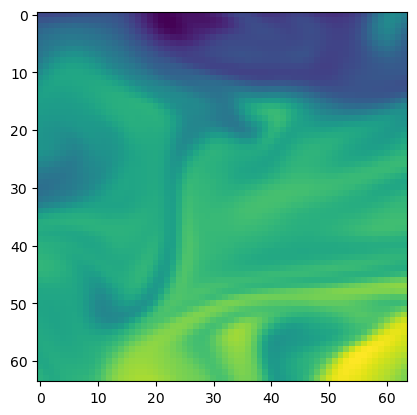

In [15]:
torch.manual_seed(42)

split = train_val_test_split_files(datadir("sst_npy/"), [0.8, 0.1, 0.1]) 

train_split = split[0]
val_split   = split[1]
test_split  = split[2]

# Total number of files in each split
print(len(train_split))
print(len(val_split))
print(len(test_split))

# For faster training, try larger batchsize
training_loader = create_dataloader(batchsize=32, files=train_split, ndays=4, shuff=True)
val_loader = create_dataloader(batchsize=32, files=val_split, ndays=4, shuff=True)

# Total number of batches in the loader
print(len(training_loader))

train_first, train_next = next(iter(training_loader)) 
plt.imshow(train_first[0][0])

In [16]:
def create_example_loader(X_files, y_files, batchsize=1, dtype=torch.FloatTensor):
    
    X = []
    y = []
    
    for region in X_files:
        region_X = []
        
        for X_file in region:
            x = np.load(X_file)
            region_X.append(x)
        
        X.append(region_X)
    
    for region in y_files:
        y.append(np.load(region))
    
    X = torch.from_numpy(np.array(X)).type(dtype)
    y = torch.from_numpy(np.array(y)).type(dtype)
    
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X, y), batch_size=batchsize)
    
    return loader

In [17]:
reg3_X = [datadir("sst_npy/sst_geo_20210605.nc_region_3.npy"),  
          datadir("sst_npy/sst_geo_20210606.nc_region_3.npy"),
          datadir("sst_npy/sst_geo_20210607.nc_region_3.npy"),
          datadir("sst_npy/sst_geo_20210608.nc_region_3.npy")]

reg22_X = [datadir("sst_npy/sst_geo_20210605.nc_region_22.npy"),  
           datadir("sst_npy/sst_geo_20210606.nc_region_22.npy"),
           datadir("sst_npy/sst_geo_20210607.nc_region_22.npy"),
           datadir("sst_npy/sst_geo_20210608.nc_region_22.npy")]

reg29_X = [datadir("sst_npy/sst_geo_20210605.nc_region_29.npy"),  
           datadir("sst_npy/sst_geo_20210606.nc_region_29.npy"),
           datadir("sst_npy/sst_geo_20210607.nc_region_29.npy"),
           datadir("sst_npy/sst_geo_20210608.nc_region_29.npy")]

reg44_X = [datadir("sst_npy/sst_geo_20210605.nc_region_44.npy"),  
           datadir("sst_npy/sst_geo_20210606.nc_region_44.npy"),
           datadir("sst_npy/sst_geo_20210607.nc_region_44.npy"),
           datadir("sst_npy/sst_geo_20210608.nc_region_44.npy")]

examples_X = [reg3_X, reg22_X, reg29_X, reg44_X]
examples_y = [datadir("sst_npy/sst_geo_20210609.nc_region_3.npy"),
              datadir("sst_npy/sst_geo_20210609.nc_region_22.npy"),
              datadir("sst_npy/sst_geo_20210609.nc_region_29.npy"),
              datadir("sst_npy/sst_geo_20210609.nc_region_44.npy")]


example_loader = create_example_loader(examples_X, examples_y)

In [18]:
try:
    os.mkdir("/projectnb/labci/Lucia/rainfall-pde-ml/experiments/" + str(datetime.date.today()))
except FileExistsError as e:
    print("Already ran experiments today.")
finally:
    path = "/projectnb/labci/Lucia/rainfall-pde-ml/experiments/" + str(datetime.date.today())

Already ran experiments today.


### Training with Squared Error Loss

In [ ]:
net1 = CDNN(hist=4)
net1.to(device)

optim = torch.optim.Adam(net1.parameters(), lr=1e-3)

exp1 = Experiment(name="BezenacSqErr_100",                 # de Bezenac model, trained on err^2 Loss
                  trainset=training_loader,                # data loaders: 1. training
                  valset=val_loader,                       #               2. validation  
                  testset=None,                            #               3. testing
                  model=net1,                              # model 
                  regloss=False,                           # whether to regularize the training loss 
                  test_loss=nn.MSELoss(reduction="mean"),  # loss function for testing
                  optimizer=optim,
                  outdir=path)

exp1.run(epochs=100)

Created new directory to save model states and results: /projectnb/labci/Lucia/rainfall-pde-ml/experiments/2023-09-25/BezenacSqErr_100
Running experiment: BezenacSqErr_100...
Training over 100 epochs...
Epoch 0
-------------------------------
Step: 0 Loss: tensor(3832.7795, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 1 Loss: tensor(7371.4248, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 2 Loss: tensor(5161.7100, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 3 Loss: tensor(5129.3770, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 4 Loss: tensor(1185.8734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 5 Loss: tensor(1681.8253, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(599.6897, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(605.7253, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(258.1078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(127.9831, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 10 Loss: tensor

Step: 110 Loss: tensor(3.2247, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 111 Loss: tensor(1.9554, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 112 Loss: tensor(3.5527, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 113 Loss: tensor(1.7655, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 114 Loss: tensor(1.8753, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 115 Loss: tensor(1.4892, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 116 Loss: tensor(2.6036, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 117 Loss: tensor(2.0127, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 118 Loss: tensor(3.4727, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 119 Loss: tensor(3.3284, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 120 Loss: tensor(2.2766, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(2.9749, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(1.9862, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 123 Loss: tensor(1.4655, device='cuda:0', gra

Step: 223 Loss: tensor(2.1674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 224 Loss: tensor(2.7970, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 225 Loss: tensor(2.6866, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 226 Loss: tensor(1.5177, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 227 Loss: tensor(2.1118, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 228 Loss: tensor(1.7368, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 229 Loss: tensor(1.8878, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 230 Loss: tensor(1.4784, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 231 Loss: tensor(2.6829, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 232 Loss: tensor(2.4542, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 233 Loss: tensor(1.7725, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(1.5333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(1.4021, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 236 Loss: tensor(1.8428, device='cuda:0', gra

Step: 336 Loss: tensor(1.4999, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 337 Loss: tensor(1.6406, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 338 Loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 339 Loss: tensor(1.4593, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 340 Loss: tensor(2.1410, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 341 Loss: tensor(1.4219, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 342 Loss: tensor(1.5132, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 343 Loss: tensor(1.7870, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 344 Loss: tensor(1.6616, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 345 Loss: tensor(1.3224, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 346 Loss: tensor(1.5192, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(3.7397, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(1.8773, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 349 Loss: tensor(1.4105, device='cuda:0', gra

Step: 449 Loss: tensor(1.9901, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 450 Loss: tensor(1.8706, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 451 Loss: tensor(2.3535, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 452 Loss: tensor(2.0540, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 453 Loss: tensor(1.8517, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 454 Loss: tensor(1.6810, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 455 Loss: tensor(1.1392, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 456 Loss: tensor(2.3704, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 457 Loss: tensor(1.6985, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 458 Loss: tensor(1.8515, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 459 Loss: tensor(1.1142, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(2.7537, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(1.9997, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 462 Loss: tensor(1.8604, device='cuda:0', gra

Step: 562 Loss: tensor(1.2085, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 563 Loss: tensor(1.0701, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 564 Loss: tensor(1.4285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 565 Loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 566 Loss: tensor(1.5376, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 567 Loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 568 Loss: tensor(1.4522, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 569 Loss: tensor(1.2014, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 570 Loss: tensor(0.8182, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 571 Loss: tensor(1.3731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 572 Loss: tensor(1.7231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(2.1957, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(1.4977, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 575 Loss: tensor(1.2103, device='cuda:0', gra

Step: 675 Loss: tensor(1.1636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 676 Loss: tensor(1.7376, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 677 Loss: tensor(1.9527, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 678 Loss: tensor(1.4391, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 679 Loss: tensor(1.7484, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 680 Loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 681 Loss: tensor(1.5465, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 682 Loss: tensor(2.8711, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 683 Loss: tensor(1.3604, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 684 Loss: tensor(1.6480, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 685 Loss: tensor(1.5908, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(2.8328, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 688 Loss: tensor(1.5150, device='cuda:0', gra

Step: 788 Loss: tensor(1.2966, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 789 Loss: tensor(0.8790, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 790 Loss: tensor(1.0625, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 791 Loss: tensor(1.8195, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 792 Loss: tensor(1.1826, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 793 Loss: tensor(1.3458, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 794 Loss: tensor(1.5535, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 795 Loss: tensor(1.6423, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 796 Loss: tensor(1.2156, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 797 Loss: tensor(1.7406, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 798 Loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(1.6502, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(1.2120, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 801 Loss: tensor(1.6037, device='cuda:0', gra

Step: 6 Loss: tensor(1.1010, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(1.6636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(1.8748, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(1.0772, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 10 Loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 11 Loss: tensor(2.4540, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 12 Loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 13 Loss: tensor(2.5181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 14 Loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 15 Loss: tensor(1.6868, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(1.6194, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(2.4446, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(1.3784, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(2.3701, device='cuda:0', grad_fn=<MeanBackward

Step: 120 Loss: tensor(0.8864, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(1.6569, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(1.8464, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 123 Loss: tensor(1.5262, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 124 Loss: tensor(1.6393, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 125 Loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 126 Loss: tensor(1.0986, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 127 Loss: tensor(2.1357, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 128 Loss: tensor(2.5993, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 129 Loss: tensor(1.3802, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 130 Loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 131 Loss: tensor(1.9343, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 132 Loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 133 Loss: tensor(1.9969, device='cuda:0', gra

Step: 233 Loss: tensor(1.6838, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(1.2955, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(1.3512, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 236 Loss: tensor(1.3143, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 237 Loss: tensor(2.4744, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 238 Loss: tensor(1.6539, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 239 Loss: tensor(1.1809, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 240 Loss: tensor(1.7883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 241 Loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 242 Loss: tensor(1.1364, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 243 Loss: tensor(1.8565, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 244 Loss: tensor(1.6941, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 245 Loss: tensor(1.1979, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 246 Loss: tensor(1.9943, device='cuda:0', gra

Step: 346 Loss: tensor(1.5798, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(1.3078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(1.9049, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 349 Loss: tensor(1.8294, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 350 Loss: tensor(1.1639, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 351 Loss: tensor(1.6375, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 352 Loss: tensor(1.1661, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 353 Loss: tensor(1.8425, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 354 Loss: tensor(1.4653, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 355 Loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 356 Loss: tensor(1.2822, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 357 Loss: tensor(1.7649, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 358 Loss: tensor(1.6702, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 359 Loss: tensor(1.2068, device='cuda:0', gra

Step: 459 Loss: tensor(1.4528, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(1.5560, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(1.3773, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 462 Loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 463 Loss: tensor(1.7208, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 464 Loss: tensor(1.7615, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 465 Loss: tensor(1.2013, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 466 Loss: tensor(1.3315, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 467 Loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 468 Loss: tensor(1.3056, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 469 Loss: tensor(1.3114, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 470 Loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 471 Loss: tensor(1.1090, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 472 Loss: tensor(2.6900, device='cuda:0', gra

Step: 572 Loss: tensor(0.8547, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(1.4513, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(1.5639, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 575 Loss: tensor(1.1546, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 576 Loss: tensor(1.6581, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 577 Loss: tensor(2.0037, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 578 Loss: tensor(1.7375, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 579 Loss: tensor(1.3997, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 580 Loss: tensor(1.4337, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 581 Loss: tensor(1.1997, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 582 Loss: tensor(1.3527, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 583 Loss: tensor(1.4908, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 584 Loss: tensor(2.6878, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 585 Loss: tensor(1.0453, device='cuda:0', gra

Step: 685 Loss: tensor(3.6080, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(1.9287, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(1.6159, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 688 Loss: tensor(1.1531, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 689 Loss: tensor(1.4508, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 690 Loss: tensor(1.5618, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 691 Loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 692 Loss: tensor(1.6085, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 693 Loss: tensor(1.4889, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 694 Loss: tensor(2.9867, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 695 Loss: tensor(1.5171, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 696 Loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 697 Loss: tensor(1.5425, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 698 Loss: tensor(2.0098, device='cuda:0', gra

Step: 798 Loss: tensor(1.8735, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(1.5018, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(1.0362, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 801 Loss: tensor(1.5799, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 802 Loss: tensor(1.4938, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 803 Loss: tensor(1.6330, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 804 Loss: tensor(1.4973, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 805 Loss: tensor(1.7302, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 806 Loss: tensor(1.5246, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 807 Loss: tensor(1.6843, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 808 Loss: tensor(1.6677, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 809 Loss: tensor(2.8608, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 810 Loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 811 Loss: tensor(1.2463, device='cuda:0', gra

Step: 16 Loss: tensor(3.1577, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(1.2844, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(1.6897, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(1.7124, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 20 Loss: tensor(2.3548, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 21 Loss: tensor(1.5691, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 22 Loss: tensor(1.2745, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 23 Loss: tensor(1.4428, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 24 Loss: tensor(1.7344, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 25 Loss: tensor(2.5665, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 26 Loss: tensor(1.8097, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 27 Loss: tensor(1.8102, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 28 Loss: tensor(1.1314, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 29 Loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBack

Step: 130 Loss: tensor(1.9094, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 131 Loss: tensor(1.6274, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 132 Loss: tensor(1.3271, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 133 Loss: tensor(1.1986, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 134 Loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 135 Loss: tensor(1.1947, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 136 Loss: tensor(1.8601, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 137 Loss: tensor(1.6395, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 138 Loss: tensor(1.3127, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 139 Loss: tensor(1.5015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 140 Loss: tensor(1.2807, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 141 Loss: tensor(1.7066, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 142 Loss: tensor(1.5253, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 143 Loss: tensor(2.1543, device='cuda:0', gra

Step: 243 Loss: tensor(1.4479, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 244 Loss: tensor(2.0534, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 245 Loss: tensor(1.7957, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 246 Loss: tensor(1.1768, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 247 Loss: tensor(1.0489, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 248 Loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 249 Loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 250 Loss: tensor(1.0583, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 251 Loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 252 Loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 253 Loss: tensor(1.3319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 254 Loss: tensor(2.5623, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 255 Loss: tensor(1.4524, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 256 Loss: tensor(1.2691, device='cuda:0', gra

Step: 356 Loss: tensor(1.3884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 357 Loss: tensor(2.0122, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 358 Loss: tensor(2.2397, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 359 Loss: tensor(1.8877, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 360 Loss: tensor(2.0225, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 361 Loss: tensor(1.0104, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 362 Loss: tensor(2.1238, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 363 Loss: tensor(2.3961, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 364 Loss: tensor(1.0327, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 365 Loss: tensor(2.1676, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 366 Loss: tensor(1.3117, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 367 Loss: tensor(2.0814, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 368 Loss: tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 369 Loss: tensor(1.4143, device='cuda:0', gra

Step: 469 Loss: tensor(1.7068, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 470 Loss: tensor(1.4655, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 471 Loss: tensor(1.3008, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 472 Loss: tensor(2.2357, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 473 Loss: tensor(0.8813, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 474 Loss: tensor(1.3016, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 475 Loss: tensor(1.8767, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 476 Loss: tensor(1.7111, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 477 Loss: tensor(0.8265, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 478 Loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 479 Loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 480 Loss: tensor(2.3603, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 481 Loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 482 Loss: tensor(1.6918, device='cuda:0', gra

Step: 582 Loss: tensor(1.3805, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 583 Loss: tensor(0.8868, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 584 Loss: tensor(1.1484, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 585 Loss: tensor(1.1647, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 586 Loss: tensor(1.1044, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 587 Loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 588 Loss: tensor(1.1216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 589 Loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 590 Loss: tensor(1.9426, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 591 Loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 592 Loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 593 Loss: tensor(1.3733, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 594 Loss: tensor(1.7524, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 595 Loss: tensor(1.8259, device='cuda:0', gra

Step: 695 Loss: tensor(1.2875, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 696 Loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 697 Loss: tensor(1.3828, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 698 Loss: tensor(2.4846, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 699 Loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 700 Loss: tensor(1.3091, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 701 Loss: tensor(1.4667, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 702 Loss: tensor(2.6899, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 703 Loss: tensor(2.0378, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 704 Loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 705 Loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 706 Loss: tensor(1.3905, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 707 Loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 708 Loss: tensor(1.2318, device='cuda:0', gra

Step: 808 Loss: tensor(1.2028, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 809 Loss: tensor(1.4064, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 810 Loss: tensor(1.2137, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 811 Loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 812 Loss: tensor(1.3626, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 813 Loss: tensor(1.6157, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 814 Loss: tensor(1.5992, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 815 Loss: tensor(2.1549, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 816 Loss: tensor(2.7146, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 817 Loss: tensor(1.4620, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 818 Loss: tensor(3.3982, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 819 Loss: tensor(1.4936, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 820 Loss: tensor(1.2199, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 821 Loss: tensor(1.1582, device='cuda:0', gra

Step: 27 Loss: tensor(1.5349, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 28 Loss: tensor(3.4898, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 29 Loss: tensor(1.1908, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 30 Loss: tensor(1.3273, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 31 Loss: tensor(1.9529, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 32 Loss: tensor(1.6095, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 33 Loss: tensor(1.9003, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 34 Loss: tensor(1.3006, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 35 Loss: tensor(2.2224, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 36 Loss: tensor(2.0200, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 37 Loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 38 Loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 39 Loss: tensor(1.4090, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 40 Loss: tensor(1.6021, device='cuda:0', grad_fn=<MeanBack

Step: 141 Loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 142 Loss: tensor(1.8434, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 143 Loss: tensor(2.5485, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 144 Loss: tensor(1.3499, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 145 Loss: tensor(1.7658, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 146 Loss: tensor(2.2578, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 147 Loss: tensor(2.2721, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 148 Loss: tensor(1.4157, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 149 Loss: tensor(1.5834, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 150 Loss: tensor(1.4433, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 151 Loss: tensor(1.1877, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 152 Loss: tensor(1.1923, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 153 Loss: tensor(1.3521, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 154 Loss: tensor(1.4763, device='cuda:0', gra

Step: 254 Loss: tensor(1.0649, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 255 Loss: tensor(1.6754, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 256 Loss: tensor(1.2923, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 257 Loss: tensor(1.0577, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 258 Loss: tensor(1.8926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 259 Loss: tensor(3.9619, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 260 Loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 261 Loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 262 Loss: tensor(1.7640, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 263 Loss: tensor(2.8930, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 264 Loss: tensor(1.3803, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 265 Loss: tensor(1.9926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 266 Loss: tensor(1.4880, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 267 Loss: tensor(1.3108, device='cuda:0', gra

Step: 367 Loss: tensor(1.3277, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 368 Loss: tensor(2.5926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 369 Loss: tensor(1.2093, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 370 Loss: tensor(2.2672, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 371 Loss: tensor(1.4628, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 372 Loss: tensor(1.1246, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 373 Loss: tensor(3.0637, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 374 Loss: tensor(1.4874, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 375 Loss: tensor(1.0037, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 376 Loss: tensor(2.5896, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 377 Loss: tensor(1.1079, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 378 Loss: tensor(1.9211, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 379 Loss: tensor(1.8488, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 380 Loss: tensor(0.9280, device='cuda:0', gra

Step: 480 Loss: tensor(1.1522, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 481 Loss: tensor(2.1560, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 482 Loss: tensor(1.1261, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 483 Loss: tensor(1.2057, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 484 Loss: tensor(1.5871, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 485 Loss: tensor(1.8387, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 486 Loss: tensor(1.1766, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 487 Loss: tensor(2.3887, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 488 Loss: tensor(1.9925, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 489 Loss: tensor(1.2886, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 490 Loss: tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 491 Loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 492 Loss: tensor(1.5587, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 493 Loss: tensor(1.5060, device='cuda:0', gra

Step: 593 Loss: tensor(1.2055, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 594 Loss: tensor(1.7427, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 595 Loss: tensor(1.1285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 596 Loss: tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 597 Loss: tensor(2.0624, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 598 Loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 599 Loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 600 Loss: tensor(1.0804, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 601 Loss: tensor(1.1181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 602 Loss: tensor(2.0657, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 603 Loss: tensor(1.4684, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 604 Loss: tensor(1.0122, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 605 Loss: tensor(2.0420, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 606 Loss: tensor(1.4243, device='cuda:0', gra

Step: 706 Loss: tensor(1.6314, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 707 Loss: tensor(1.5320, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 708 Loss: tensor(1.0291, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 709 Loss: tensor(1.1384, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 710 Loss: tensor(2.2649, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 711 Loss: tensor(1.6579, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 712 Loss: tensor(1.8691, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 713 Loss: tensor(1.1032, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 714 Loss: tensor(2.2198, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 715 Loss: tensor(1.6505, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 716 Loss: tensor(2.9225, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 717 Loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 718 Loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 719 Loss: tensor(1.0528, device='cuda:0', gra

Step: 819 Loss: tensor(1.0494, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 820 Loss: tensor(0.8769, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 821 Loss: tensor(1.6719, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 822 Loss: tensor(1.5154, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 823 Loss: tensor(1.5056, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 824 Loss: tensor(1.1039, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 825 Loss: tensor(0.7278, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 826 Loss: tensor(1.5066, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 827 Loss: tensor(1.2091, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 828 Loss: tensor(1.1421, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 829 Loss: tensor(1.0066, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 830 Loss: tensor(1.4672, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 831 Loss: tensor(1.1793, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 832 Loss: tensor(2.9349, device='cuda:0', gra

Step: 38 Loss: tensor(1.1669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 39 Loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 40 Loss: tensor(2.6643, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 41 Loss: tensor(0.8033, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 42 Loss: tensor(1.1418, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 43 Loss: tensor(1.7456, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 44 Loss: tensor(1.3362, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 45 Loss: tensor(1.8056, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 46 Loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 47 Loss: tensor(1.5242, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 48 Loss: tensor(1.5059, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 49 Loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 50 Loss: tensor(1.3867, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 51 Loss: tensor(1.2732, device='cuda:0', grad_fn=<MeanBack

Step: 152 Loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 153 Loss: tensor(2.0540, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 154 Loss: tensor(2.4034, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 155 Loss: tensor(1.6456, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 156 Loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 157 Loss: tensor(1.1008, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 158 Loss: tensor(2.0290, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 159 Loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 160 Loss: tensor(1.1984, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 161 Loss: tensor(1.1054, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 162 Loss: tensor(1.1649, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 163 Loss: tensor(1.9047, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 164 Loss: tensor(1.4935, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 165 Loss: tensor(2.5412, device='cuda:0', gra

Step: 265 Loss: tensor(3.7245, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 266 Loss: tensor(1.6025, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 267 Loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 268 Loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 269 Loss: tensor(1.6135, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 270 Loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 271 Loss: tensor(0.9983, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 272 Loss: tensor(2.1749, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 273 Loss: tensor(1.4672, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 274 Loss: tensor(1.4783, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 275 Loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 276 Loss: tensor(1.1335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 277 Loss: tensor(2.3472, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 278 Loss: tensor(2.0180, device='cuda:0', gra

Step: 378 Loss: tensor(2.8932, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 379 Loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 380 Loss: tensor(1.0226, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 381 Loss: tensor(1.0168, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 382 Loss: tensor(2.1196, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 383 Loss: tensor(1.5792, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 384 Loss: tensor(1.5631, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 385 Loss: tensor(0.7779, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 386 Loss: tensor(1.1416, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 387 Loss: tensor(1.5573, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 388 Loss: tensor(1.5841, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 389 Loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 390 Loss: tensor(1.1460, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 391 Loss: tensor(2.0385, device='cuda:0', gra

Step: 491 Loss: tensor(2.7490, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 492 Loss: tensor(1.4967, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 493 Loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 494 Loss: tensor(1.5162, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 495 Loss: tensor(1.3881, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 496 Loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 497 Loss: tensor(1.5422, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 498 Loss: tensor(1.3086, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 499 Loss: tensor(1.7730, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 500 Loss: tensor(1.1891, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 501 Loss: tensor(1.7131, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 502 Loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 503 Loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 504 Loss: tensor(1.3477, device='cuda:0', gra

Step: 604 Loss: tensor(1.0191, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 605 Loss: tensor(1.7051, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 606 Loss: tensor(1.0366, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 607 Loss: tensor(1.1963, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 608 Loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 609 Loss: tensor(1.4354, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 610 Loss: tensor(1.8516, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 611 Loss: tensor(1.8953, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 612 Loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 613 Loss: tensor(2.4794, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 614 Loss: tensor(1.9188, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 615 Loss: tensor(1.3720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 616 Loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 617 Loss: tensor(1.4513, device='cuda:0', gra

Step: 717 Loss: tensor(2.6619, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 718 Loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 719 Loss: tensor(1.5238, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 720 Loss: tensor(1.3813, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 721 Loss: tensor(1.3001, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 722 Loss: tensor(1.0883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 723 Loss: tensor(1.6524, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 724 Loss: tensor(2.0750, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 725 Loss: tensor(1.8416, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 726 Loss: tensor(1.3884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 727 Loss: tensor(2.5242, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 728 Loss: tensor(1.9120, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 729 Loss: tensor(1.5546, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 730 Loss: tensor(2.4111, device='cuda:0', gra

Step: 830 Loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 831 Loss: tensor(1.3807, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 832 Loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 833 Loss: tensor(1.3349, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 834 Loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 835 Loss: tensor(1.5860, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 836 Loss: tensor(1.6256, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 837 Loss: tensor(0.9886, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 838 Loss: tensor(0.8648, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 839 Loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 840 Loss: tensor(1.3583, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 841 Loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 842 Loss: tensor(1.3240, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 843 Loss: tensor(1.4106, device='cuda:0', gra

Step: 49 Loss: tensor(1.4577, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 50 Loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 51 Loss: tensor(1.0266, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 52 Loss: tensor(1.6958, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 53 Loss: tensor(1.5451, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 54 Loss: tensor(1.4228, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 55 Loss: tensor(1.6228, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 56 Loss: tensor(1.4020, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 57 Loss: tensor(1.4317, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 58 Loss: tensor(1.5024, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 59 Loss: tensor(2.0579, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 60 Loss: tensor(0.8023, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 61 Loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 62 Loss: tensor(1.1842, device='cuda:0', grad_fn=<MeanBack

Step: 162 Loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 163 Loss: tensor(1.6337, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 164 Loss: tensor(2.8053, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 165 Loss: tensor(1.5737, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 166 Loss: tensor(1.4351, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 167 Loss: tensor(2.0790, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 168 Loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 169 Loss: tensor(1.4840, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 170 Loss: tensor(1.9029, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 171 Loss: tensor(1.7415, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 172 Loss: tensor(1.0236, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 173 Loss: tensor(1.7035, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 174 Loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 175 Loss: tensor(2.4109, device='cuda:0', gra

Step: 275 Loss: tensor(1.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 276 Loss: tensor(1.5504, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 277 Loss: tensor(2.4378, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 278 Loss: tensor(1.5571, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 279 Loss: tensor(1.0224, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 280 Loss: tensor(1.5715, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 281 Loss: tensor(2.6134, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 282 Loss: tensor(1.4356, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 283 Loss: tensor(1.5499, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 284 Loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 285 Loss: tensor(2.1833, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 286 Loss: tensor(1.1412, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 287 Loss: tensor(1.1171, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 288 Loss: tensor(1.4842, device='cuda:0', gra

Step: 388 Loss: tensor(2.2487, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 389 Loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 390 Loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 391 Loss: tensor(1.1174, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 392 Loss: tensor(1.3013, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 393 Loss: tensor(1.9356, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 394 Loss: tensor(1.9998, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 395 Loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 396 Loss: tensor(1.0659, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 397 Loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 398 Loss: tensor(2.2772, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 399 Loss: tensor(1.4741, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 400 Loss: tensor(2.1001, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 401 Loss: tensor(1.5433, device='cuda:0', gra

Step: 501 Loss: tensor(2.3333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 502 Loss: tensor(2.6547, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 503 Loss: tensor(1.1190, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 504 Loss: tensor(2.1508, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 505 Loss: tensor(1.9397, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 506 Loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 507 Loss: tensor(1.0650, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 508 Loss: tensor(2.0379, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 509 Loss: tensor(1.6611, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 510 Loss: tensor(1.9847, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 511 Loss: tensor(1.7020, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 512 Loss: tensor(0.7631, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 513 Loss: tensor(1.4464, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 514 Loss: tensor(1.4417, device='cuda:0', gra

Step: 614 Loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 615 Loss: tensor(1.0315, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 616 Loss: tensor(1.7893, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 617 Loss: tensor(1.6765, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 618 Loss: tensor(1.1208, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 619 Loss: tensor(1.1146, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 620 Loss: tensor(1.6427, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 621 Loss: tensor(1.4973, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 622 Loss: tensor(1.7336, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 623 Loss: tensor(1.9811, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 624 Loss: tensor(1.6593, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 625 Loss: tensor(1.6719, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 626 Loss: tensor(1.6588, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 627 Loss: tensor(0.7314, device='cuda:0', gra

Step: 727 Loss: tensor(1.8251, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 728 Loss: tensor(1.0195, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 729 Loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 730 Loss: tensor(1.0252, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 731 Loss: tensor(0.8810, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 732 Loss: tensor(1.7314, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 733 Loss: tensor(1.2892, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 734 Loss: tensor(2.0774, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 735 Loss: tensor(2.1280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 736 Loss: tensor(1.7038, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 737 Loss: tensor(2.4731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 738 Loss: tensor(1.8203, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 739 Loss: tensor(1.3380, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 740 Loss: tensor(2.6492, device='cuda:0', gra

Step: 840 Loss: tensor(1.5199, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 841 Loss: tensor(1.1185, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 842 Loss: tensor(1.2902, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 843 Loss: tensor(1.4516, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 844 Loss: tensor(1.9195, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 845 Loss: tensor(1.3442, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 846 Loss: tensor(1.4428, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 847 Loss: tensor(1.6371, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 848 Loss: tensor(1.6374, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 849 Loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 850 Loss: tensor(1.1675, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 851 Loss: tensor(1.5710, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 852 Loss: tensor(1.1429, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 853 Loss: tensor(1.6248, device='cuda:0', gra

Step: 59 Loss: tensor(2.4470, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 60 Loss: tensor(1.7648, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 61 Loss: tensor(1.3465, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 62 Loss: tensor(1.1917, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 63 Loss: tensor(1.4931, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 64 Loss: tensor(2.0285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 65 Loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 66 Loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 67 Loss: tensor(1.4313, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 68 Loss: tensor(1.3558, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 69 Loss: tensor(1.3169, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 70 Loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 71 Loss: tensor(1.5660, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 72 Loss: tensor(1.0887, device='cuda:0', grad_fn=<MeanBack

Step: 172 Loss: tensor(2.2189, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 173 Loss: tensor(1.8263, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 174 Loss: tensor(2.0925, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 175 Loss: tensor(1.1668, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 176 Loss: tensor(1.0898, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 177 Loss: tensor(2.3651, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 178 Loss: tensor(2.1316, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 179 Loss: tensor(1.4296, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 180 Loss: tensor(1.0863, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 181 Loss: tensor(2.0347, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 182 Loss: tensor(0.8504, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 183 Loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 184 Loss: tensor(2.0243, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 185 Loss: tensor(1.6589, device='cuda:0', gra

Step: 285 Loss: tensor(1.1123, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 286 Loss: tensor(1.3225, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 287 Loss: tensor(1.2160, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 288 Loss: tensor(0.7767, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 289 Loss: tensor(1.4543, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 290 Loss: tensor(2.4887, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 291 Loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 292 Loss: tensor(1.0136, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 293 Loss: tensor(1.5408, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 294 Loss: tensor(1.1059, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 295 Loss: tensor(1.8616, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 296 Loss: tensor(1.1006, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 297 Loss: tensor(1.4597, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 298 Loss: tensor(1.9433, device='cuda:0', gra

Step: 398 Loss: tensor(1.1456, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 399 Loss: tensor(1.7333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 400 Loss: tensor(1.0719, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 401 Loss: tensor(1.3509, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 402 Loss: tensor(1.6985, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 403 Loss: tensor(1.2092, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 404 Loss: tensor(2.6886, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 405 Loss: tensor(0.8786, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 406 Loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 407 Loss: tensor(1.0313, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 408 Loss: tensor(2.0465, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 409 Loss: tensor(1.1384, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 410 Loss: tensor(1.8061, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 411 Loss: tensor(1.7208, device='cuda:0', gra

Step: 511 Loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 512 Loss: tensor(1.2161, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 513 Loss: tensor(0.8725, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 514 Loss: tensor(1.9725, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 515 Loss: tensor(1.8285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 516 Loss: tensor(1.4596, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 517 Loss: tensor(1.3618, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 518 Loss: tensor(1.1264, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 519 Loss: tensor(1.0667, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 520 Loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 521 Loss: tensor(1.6797, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 522 Loss: tensor(1.5330, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 523 Loss: tensor(2.4392, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 524 Loss: tensor(1.2838, device='cuda:0', gra

Step: 624 Loss: tensor(0.8232, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 625 Loss: tensor(1.0375, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 626 Loss: tensor(2.1976, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 627 Loss: tensor(1.5473, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 628 Loss: tensor(1.4166, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 629 Loss: tensor(1.9164, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 630 Loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 631 Loss: tensor(0.8410, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 632 Loss: tensor(1.3322, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 633 Loss: tensor(1.1643, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 634 Loss: tensor(1.6078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 635 Loss: tensor(2.7697, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 636 Loss: tensor(2.1945, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 637 Loss: tensor(2.3252, device='cuda:0', gra

Step: 737 Loss: tensor(1.0200, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 738 Loss: tensor(1.3963, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 739 Loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 740 Loss: tensor(1.8158, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 741 Loss: tensor(1.7621, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 742 Loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 743 Loss: tensor(1.5162, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 744 Loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 745 Loss: tensor(0.9392, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 746 Loss: tensor(0.8126, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 747 Loss: tensor(1.1104, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 748 Loss: tensor(2.1939, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 749 Loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 750 Loss: tensor(1.4874, device='cuda:0', gra

Step: 850 Loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 851 Loss: tensor(0.8125, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 852 Loss: tensor(1.3313, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 853 Loss: tensor(1.5876, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 854 Loss: tensor(1.3793, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 855 Loss: tensor(2.4769, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 856 Loss: tensor(1.3340, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 857 Loss: tensor(1.4035, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 858 Loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 859 Loss: tensor(2.3547, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 860 Loss: tensor(1.1836, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 861 Loss: tensor(1.0619, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 862 Loss: tensor(1.2187, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 863 Loss: tensor(1.1813, device='cuda:0', gra

Step: 69 Loss: tensor(1.7125, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 70 Loss: tensor(1.7704, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 71 Loss: tensor(1.1619, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 72 Loss: tensor(2.0552, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 73 Loss: tensor(1.6704, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 74 Loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 75 Loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 76 Loss: tensor(1.5294, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 77 Loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 78 Loss: tensor(1.5586, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 79 Loss: tensor(1.1961, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 80 Loss: tensor(1.9695, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 81 Loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 82 Loss: tensor(1.8164, device='cuda:0', grad_fn=<MeanBack

Step: 182 Loss: tensor(2.0137, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 183 Loss: tensor(2.5119, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 184 Loss: tensor(2.4766, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 185 Loss: tensor(1.4051, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 186 Loss: tensor(2.3247, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 187 Loss: tensor(1.1505, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 188 Loss: tensor(1.3231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 189 Loss: tensor(2.6520, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 190 Loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 191 Loss: tensor(1.5840, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 192 Loss: tensor(1.1947, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 193 Loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 194 Loss: tensor(1.4958, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 195 Loss: tensor(0.6460, device='cuda:0', gra

Step: 295 Loss: tensor(1.0929, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 296 Loss: tensor(1.8292, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 297 Loss: tensor(1.6896, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 298 Loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 299 Loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 300 Loss: tensor(2.4956, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 301 Loss: tensor(1.4512, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 302 Loss: tensor(1.5484, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 303 Loss: tensor(1.8953, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 304 Loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 305 Loss: tensor(1.0581, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 306 Loss: tensor(1.8853, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 307 Loss: tensor(1.3891, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 308 Loss: tensor(1.8327, device='cuda:0', gra

Step: 408 Loss: tensor(2.1883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 409 Loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 410 Loss: tensor(1.7952, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 411 Loss: tensor(2.3499, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 412 Loss: tensor(2.1589, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 413 Loss: tensor(1.7767, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 414 Loss: tensor(1.0690, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 415 Loss: tensor(1.6256, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 416 Loss: tensor(0.8334, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 417 Loss: tensor(1.2233, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 418 Loss: tensor(1.4867, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 419 Loss: tensor(2.0298, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 420 Loss: tensor(1.5078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 421 Loss: tensor(1.9889, device='cuda:0', gra

Step: 521 Loss: tensor(1.8440, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 522 Loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 523 Loss: tensor(1.1155, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 524 Loss: tensor(1.2246, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 525 Loss: tensor(1.2187, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 526 Loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 527 Loss: tensor(3.6085, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 528 Loss: tensor(1.5032, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 529 Loss: tensor(1.4477, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 530 Loss: tensor(1.5821, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 531 Loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 532 Loss: tensor(1.4477, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 533 Loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 534 Loss: tensor(0.9544, device='cuda:0', gra

Step: 634 Loss: tensor(1.6023, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 635 Loss: tensor(1.5133, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 636 Loss: tensor(1.5802, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 637 Loss: tensor(0.7468, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 638 Loss: tensor(1.5899, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 639 Loss: tensor(1.5936, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 640 Loss: tensor(1.4389, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 641 Loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 642 Loss: tensor(2.2783, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 643 Loss: tensor(1.7791, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 644 Loss: tensor(1.1280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 645 Loss: tensor(1.6579, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 646 Loss: tensor(1.5189, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 647 Loss: tensor(1.9351, device='cuda:0', gra

Step: 747 Loss: tensor(1.9015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 748 Loss: tensor(2.0239, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 749 Loss: tensor(1.4736, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 750 Loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 751 Loss: tensor(1.4761, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 752 Loss: tensor(1.2784, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 753 Loss: tensor(1.0853, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 754 Loss: tensor(1.3093, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 755 Loss: tensor(1.5514, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 756 Loss: tensor(1.5720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 757 Loss: tensor(1.3145, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 758 Loss: tensor(1.7425, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 759 Loss: tensor(1.4186, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 760 Loss: tensor(1.5142, device='cuda:0', gra

Step: 860 Loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 861 Loss: tensor(1.3018, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 862 Loss: tensor(2.4428, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 863 Loss: tensor(1.6494, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 864 Loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 865 Loss: tensor(2.0233, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 866 Loss: tensor(1.3725, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 867 Loss: tensor(1.6127, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 868 Loss: tensor(1.3026, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 869 Loss: tensor(1.3668, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 870 Loss: tensor(2.7150, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 871 Loss: tensor(3.0338, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 872 Loss: tensor(1.6087, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 873 Loss: tensor(2.1588, device='cuda:0', gra

Step: 79 Loss: tensor(1.0576, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 80 Loss: tensor(1.3878, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 81 Loss: tensor(1.3028, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 82 Loss: tensor(0.9916, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 83 Loss: tensor(1.4775, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 84 Loss: tensor(0.7270, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 85 Loss: tensor(1.0790, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 86 Loss: tensor(1.3182, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 87 Loss: tensor(2.0430, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 88 Loss: tensor(1.5334, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 89 Loss: tensor(1.8348, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 90 Loss: tensor(1.5753, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 91 Loss: tensor(1.1491, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 92 Loss: tensor(1.2841, device='cuda:0', grad_fn=<MeanBack

Step: 192 Loss: tensor(1.1005, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 193 Loss: tensor(1.5031, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 194 Loss: tensor(1.7701, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 195 Loss: tensor(3.4574, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 196 Loss: tensor(1.1224, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 197 Loss: tensor(2.1668, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 198 Loss: tensor(1.0511, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 199 Loss: tensor(0.8246, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 200 Loss: tensor(0.7740, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 201 Loss: tensor(1.2079, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 202 Loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 203 Loss: tensor(1.9052, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 204 Loss: tensor(1.3876, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 205 Loss: tensor(1.3255, device='cuda:0', gra

Step: 305 Loss: tensor(1.7391, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 306 Loss: tensor(1.9703, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 307 Loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 308 Loss: tensor(1.0160, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 309 Loss: tensor(1.5180, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 310 Loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 311 Loss: tensor(1.6902, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 312 Loss: tensor(1.3414, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 313 Loss: tensor(2.3349, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 314 Loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 315 Loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 316 Loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 317 Loss: tensor(0.7460, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 318 Loss: tensor(0.9742, device='cuda:0', gra

Step: 418 Loss: tensor(1.9234, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 419 Loss: tensor(1.3647, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 420 Loss: tensor(2.5466, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 421 Loss: tensor(1.1812, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 422 Loss: tensor(1.8322, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 423 Loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 424 Loss: tensor(1.3290, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 425 Loss: tensor(1.5978, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 426 Loss: tensor(1.3876, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 427 Loss: tensor(1.2969, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 428 Loss: tensor(1.3657, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 429 Loss: tensor(1.8901, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 430 Loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 431 Loss: tensor(1.2414, device='cuda:0', gra

Step: 531 Loss: tensor(2.0590, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 532 Loss: tensor(1.1186, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 533 Loss: tensor(2.1460, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 534 Loss: tensor(1.1672, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 535 Loss: tensor(1.6942, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 536 Loss: tensor(1.0918, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 537 Loss: tensor(1.1413, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 538 Loss: tensor(1.5400, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 539 Loss: tensor(1.0793, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 540 Loss: tensor(1.6240, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 541 Loss: tensor(1.3173, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 542 Loss: tensor(1.3477, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 543 Loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 544 Loss: tensor(2.5723, device='cuda:0', gra

Step: 644 Loss: tensor(1.9695, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 645 Loss: tensor(1.4985, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 646 Loss: tensor(1.2191, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 647 Loss: tensor(1.4706, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 648 Loss: tensor(1.2667, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 649 Loss: tensor(0.8447, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 650 Loss: tensor(2.5045, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 651 Loss: tensor(1.7602, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 652 Loss: tensor(2.0529, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 653 Loss: tensor(1.0307, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 654 Loss: tensor(1.7299, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 655 Loss: tensor(1.2019, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 656 Loss: tensor(3.1136, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 657 Loss: tensor(1.1548, device='cuda:0', gra

Step: 757 Loss: tensor(1.7746, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 758 Loss: tensor(0.9885, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 759 Loss: tensor(1.2981, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 760 Loss: tensor(1.0288, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 761 Loss: tensor(0.7635, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 762 Loss: tensor(1.6555, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 763 Loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 764 Loss: tensor(2.0671, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 765 Loss: tensor(1.0884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 766 Loss: tensor(1.1148, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 767 Loss: tensor(1.0254, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 768 Loss: tensor(1.3093, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 769 Loss: tensor(0.7953, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 770 Loss: tensor(1.6690, device='cuda:0', gra

Step: 870 Loss: tensor(1.3973, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 871 Loss: tensor(0.8508, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 872 Loss: tensor(0.8675, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 873 Loss: tensor(0.8564, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 874 Loss: tensor(1.1293, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 875 Loss: tensor(1.5873, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 876 Loss: tensor(1.9306, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 877 Loss: tensor(1.8347, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 878 Loss: tensor(0.8277, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 879 Loss: tensor(1.4156, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 880 Loss: tensor(1.0614, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 881 Loss: tensor(2.2540, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 882 Loss: tensor(1.3466, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 883 Loss: tensor(1.2538, device='cuda:0', gra

Step: 89 Loss: tensor(1.9272, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 90 Loss: tensor(1.6133, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 91 Loss: tensor(1.5455, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 92 Loss: tensor(2.1685, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 93 Loss: tensor(1.0790, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 94 Loss: tensor(1.0971, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 95 Loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 96 Loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 97 Loss: tensor(2.2768, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 98 Loss: tensor(1.5080, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 99 Loss: tensor(1.3878, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 100 Loss: tensor(1.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 101 Loss: tensor(1.5551, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 102 Loss: tensor(0.8307, device='cuda:0', grad_fn=<MeanB

Step: 202 Loss: tensor(1.8394, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 203 Loss: tensor(1.7280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 204 Loss: tensor(1.4476, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 205 Loss: tensor(1.1570, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 206 Loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 207 Loss: tensor(1.6443, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 208 Loss: tensor(1.0734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 209 Loss: tensor(0.8748, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 210 Loss: tensor(1.0145, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 211 Loss: tensor(0.8215, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 212 Loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 213 Loss: tensor(1.3826, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 214 Loss: tensor(1.3579, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 215 Loss: tensor(1.2628, device='cuda:0', gra

Step: 315 Loss: tensor(4.1358, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 316 Loss: tensor(1.5611, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 317 Loss: tensor(2.0468, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 318 Loss: tensor(1.7458, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 319 Loss: tensor(1.1174, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 320 Loss: tensor(1.4709, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 321 Loss: tensor(2.0139, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 322 Loss: tensor(1.1338, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 323 Loss: tensor(1.8951, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 324 Loss: tensor(1.1788, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 325 Loss: tensor(1.1620, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 326 Loss: tensor(1.7266, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 327 Loss: tensor(1.7250, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 328 Loss: tensor(0.9564, device='cuda:0', gra

Step: 428 Loss: tensor(0.7387, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 429 Loss: tensor(1.6472, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 430 Loss: tensor(1.6669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 431 Loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 432 Loss: tensor(1.0869, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 433 Loss: tensor(1.8411, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 434 Loss: tensor(1.1832, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 435 Loss: tensor(1.3017, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 436 Loss: tensor(2.3225, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 437 Loss: tensor(0.8865, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 438 Loss: tensor(1.5542, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 439 Loss: tensor(1.6593, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 440 Loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 441 Loss: tensor(0.9450, device='cuda:0', gra

Step: 541 Loss: tensor(1.8508, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 542 Loss: tensor(1.4491, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 543 Loss: tensor(1.0979, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 544 Loss: tensor(1.0292, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 545 Loss: tensor(1.1853, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 546 Loss: tensor(1.7210, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 547 Loss: tensor(0.8136, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 548 Loss: tensor(1.2639, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 549 Loss: tensor(1.8206, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 550 Loss: tensor(1.0636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 551 Loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 552 Loss: tensor(2.0538, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 553 Loss: tensor(0.7712, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 554 Loss: tensor(1.2077, device='cuda:0', gra

Step: 654 Loss: tensor(1.9775, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 655 Loss: tensor(1.5528, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 656 Loss: tensor(1.0343, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 657 Loss: tensor(1.8971, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 658 Loss: tensor(1.5816, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 659 Loss: tensor(1.8427, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 660 Loss: tensor(2.1617, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 661 Loss: tensor(1.7891, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 662 Loss: tensor(1.3761, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 663 Loss: tensor(1.3127, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 664 Loss: tensor(1.3148, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 665 Loss: tensor(1.5418, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 666 Loss: tensor(2.2775, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 667 Loss: tensor(1.8932, device='cuda:0', gra

Step: 767 Loss: tensor(1.9178, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 768 Loss: tensor(1.6907, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 769 Loss: tensor(1.9159, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 770 Loss: tensor(1.7279, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 771 Loss: tensor(2.0458, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 772 Loss: tensor(1.1420, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 773 Loss: tensor(1.6515, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 774 Loss: tensor(1.0652, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 775 Loss: tensor(1.6725, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 776 Loss: tensor(0.7347, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 777 Loss: tensor(2.5734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 778 Loss: tensor(2.0015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 779 Loss: tensor(2.7858, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 780 Loss: tensor(1.3950, device='cuda:0', gra

Step: 880 Loss: tensor(1.5231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 881 Loss: tensor(1.1482, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 882 Loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 883 Loss: tensor(1.8580, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 884 Loss: tensor(1.3380, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 885 Loss: tensor(2.3418, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 886 Loss: tensor(1.1228, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 887 Loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 888 Loss: tensor(0.8487, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 889 Loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 890 Loss: tensor(1.1199, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 891 Loss: tensor(1.1682, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 892 Loss: tensor(1.2137, device='cuda:0', grad_fn=<MeanBackward0>)
Mean Training Loss: 1.42962
Validation Loss:  2.759

Step: 100 Loss: tensor(1.0734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 101 Loss: tensor(2.3421, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 102 Loss: tensor(1.3002, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 103 Loss: tensor(0.6721, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 104 Loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 105 Loss: tensor(1.6729, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 106 Loss: tensor(1.3224, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 107 Loss: tensor(2.4014, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 108 Loss: tensor(1.1181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 109 Loss: tensor(1.3473, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 110 Loss: tensor(2.2335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 111 Loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 112 Loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 113 Loss: tensor(1.6248, device='cuda:0', gra

Step: 213 Loss: tensor(0.7740, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 214 Loss: tensor(2.4552, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 215 Loss: tensor(1.0600, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 216 Loss: tensor(0.8715, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 217 Loss: tensor(1.5582, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 218 Loss: tensor(1.2739, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 219 Loss: tensor(1.5297, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 220 Loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 221 Loss: tensor(1.1443, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 222 Loss: tensor(1.5810, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 223 Loss: tensor(0.8782, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 224 Loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 225 Loss: tensor(0.8434, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 226 Loss: tensor(1.4004, device='cuda:0', gra

Step: 326 Loss: tensor(1.2941, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 327 Loss: tensor(1.5163, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 328 Loss: tensor(1.1060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 329 Loss: tensor(2.6696, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 330 Loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 331 Loss: tensor(0.8940, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 332 Loss: tensor(0.8853, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 333 Loss: tensor(1.0291, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 334 Loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 335 Loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 336 Loss: tensor(1.3233, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 337 Loss: tensor(0.8173, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 338 Loss: tensor(1.4765, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 339 Loss: tensor(1.0014, device='cuda:0', gra

Step: 439 Loss: tensor(2.3773, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 440 Loss: tensor(1.6783, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 441 Loss: tensor(1.6512, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 442 Loss: tensor(1.7817, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 443 Loss: tensor(1.0471, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 444 Loss: tensor(1.9279, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 445 Loss: tensor(1.6581, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 446 Loss: tensor(1.8484, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 447 Loss: tensor(2.0980, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 448 Loss: tensor(2.3132, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 449 Loss: tensor(2.0924, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 450 Loss: tensor(1.1529, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 451 Loss: tensor(2.6981, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 452 Loss: tensor(1.6313, device='cuda:0', gra

Step: 552 Loss: tensor(1.4316, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 553 Loss: tensor(1.5088, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 554 Loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 555 Loss: tensor(1.6381, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 556 Loss: tensor(1.1121, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 557 Loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 558 Loss: tensor(1.0417, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 559 Loss: tensor(2.4533, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 560 Loss: tensor(1.9333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 561 Loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 562 Loss: tensor(1.4995, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 563 Loss: tensor(1.2176, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 564 Loss: tensor(1.9359, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 565 Loss: tensor(1.6595, device='cuda:0', gra

Step: 665 Loss: tensor(1.6051, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 666 Loss: tensor(1.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 667 Loss: tensor(1.7490, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 668 Loss: tensor(2.3076, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 669 Loss: tensor(2.7872, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 670 Loss: tensor(1.9848, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 671 Loss: tensor(1.8270, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 672 Loss: tensor(1.5843, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 673 Loss: tensor(1.7651, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 674 Loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 675 Loss: tensor(1.3981, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 676 Loss: tensor(2.0000, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 677 Loss: tensor(2.7607, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 678 Loss: tensor(1.3787, device='cuda:0', gra

Step: 778 Loss: tensor(1.3475, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 779 Loss: tensor(0.8018, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 780 Loss: tensor(1.4764, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 781 Loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 782 Loss: tensor(1.1076, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 783 Loss: tensor(4.0984, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 784 Loss: tensor(1.6606, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 785 Loss: tensor(1.7457, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 786 Loss: tensor(1.2093, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 787 Loss: tensor(1.9166, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 788 Loss: tensor(1.1378, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 789 Loss: tensor(1.1113, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 790 Loss: tensor(1.2183, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 791 Loss: tensor(1.1657, device='cuda:0', gra

Step: 891 Loss: tensor(2.0820, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 892 Loss: tensor(1.3658, device='cuda:0', grad_fn=<MeanBackward0>)
Mean Training Loss: 2.64291
Validation Loss:  0.79026
Epoch Runtime: 0:05:07.848821
Saved checkpoint at epoch 10
Epoch 11
-------------------------------
Step: 0 Loss: tensor(1.3987, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 1 Loss: tensor(1.5180, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 2 Loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 3 Loss: tensor(1.9059, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 4 Loss: tensor(1.3180, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 5 Loss: tensor(2.8871, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(1.6192, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(2.0483, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(1.6088, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(1.6108, device='cuda:0', grad_fn=<MeanBa

Step: 110 Loss: tensor(2.1102, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 111 Loss: tensor(1.0262, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 112 Loss: tensor(1.4744, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 113 Loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 114 Loss: tensor(2.4849, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 115 Loss: tensor(2.0580, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 116 Loss: tensor(1.4398, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 117 Loss: tensor(1.5532, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 118 Loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 119 Loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 120 Loss: tensor(1.6972, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(2.7943, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(2.2430, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 123 Loss: tensor(1.5758, device='cuda:0', gra

Step: 223 Loss: tensor(1.5361, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 224 Loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 225 Loss: tensor(2.6075, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 226 Loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 227 Loss: tensor(1.7461, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 228 Loss: tensor(1.0605, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 229 Loss: tensor(1.3078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 230 Loss: tensor(2.0576, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 231 Loss: tensor(1.9686, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 232 Loss: tensor(1.5247, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 233 Loss: tensor(1.4646, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(1.7354, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(1.1709, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 236 Loss: tensor(1.0393, device='cuda:0', gra

Step: 336 Loss: tensor(1.3812, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 337 Loss: tensor(1.7745, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 338 Loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 339 Loss: tensor(1.5130, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 340 Loss: tensor(2.8222, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 341 Loss: tensor(1.0363, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 342 Loss: tensor(1.4134, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 343 Loss: tensor(1.5391, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 344 Loss: tensor(2.7346, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 345 Loss: tensor(1.2110, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 346 Loss: tensor(1.7285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(1.8327, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(1.1809, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 349 Loss: tensor(1.7794, device='cuda:0', gra

Step: 449 Loss: tensor(1.9540, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 450 Loss: tensor(1.1501, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 451 Loss: tensor(1.9030, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 452 Loss: tensor(1.8807, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 453 Loss: tensor(3.5187, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 454 Loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 455 Loss: tensor(1.6791, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 456 Loss: tensor(2.2221, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 457 Loss: tensor(2.1293, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 458 Loss: tensor(2.0309, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 459 Loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(1.6836, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 462 Loss: tensor(2.8399, device='cuda:0', gra

Step: 562 Loss: tensor(0.7599, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 563 Loss: tensor(1.5530, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 564 Loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 565 Loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 566 Loss: tensor(1.6841, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 567 Loss: tensor(1.7477, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 568 Loss: tensor(2.1908, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 569 Loss: tensor(1.3001, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 570 Loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 571 Loss: tensor(1.5182, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 572 Loss: tensor(1.1653, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(1.6155, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(1.1495, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 575 Loss: tensor(2.1179, device='cuda:0', gra

Step: 675 Loss: tensor(1.6636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 676 Loss: tensor(1.3116, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 677 Loss: tensor(3.4284, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 678 Loss: tensor(1.5695, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 679 Loss: tensor(1.4618, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 680 Loss: tensor(1.6767, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 681 Loss: tensor(0.7342, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 682 Loss: tensor(1.3528, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 683 Loss: tensor(0.7799, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 684 Loss: tensor(1.1964, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 685 Loss: tensor(2.8189, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(1.0760, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 688 Loss: tensor(1.5722, device='cuda:0', gra

Step: 788 Loss: tensor(1.6367, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 789 Loss: tensor(2.6235, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 790 Loss: tensor(1.3518, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 791 Loss: tensor(1.8057, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 792 Loss: tensor(1.1291, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 793 Loss: tensor(2.0563, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 794 Loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 795 Loss: tensor(1.7026, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 796 Loss: tensor(1.2099, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 797 Loss: tensor(1.5217, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 798 Loss: tensor(1.8031, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(1.0207, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(1.6821, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 801 Loss: tensor(3.6174, device='cuda:0', gra

Step: 6 Loss: tensor(1.5027, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(3.0282, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(1.6083, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(0.8217, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 10 Loss: tensor(1.1638, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 11 Loss: tensor(3.1910, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 12 Loss: tensor(1.4028, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 13 Loss: tensor(1.5195, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 14 Loss: tensor(1.5133, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 15 Loss: tensor(1.8694, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(0.8341, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(2.4704, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(1.3718, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(1.4016, device='cuda:0', grad_fn=<MeanBackward

Step: 120 Loss: tensor(1.3765, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(2.0498, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(1.6877, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 123 Loss: tensor(1.1867, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 124 Loss: tensor(2.1307, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 125 Loss: tensor(1.6881, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 126 Loss: tensor(1.1833, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 127 Loss: tensor(1.6957, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 128 Loss: tensor(2.3255, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 129 Loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 130 Loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 131 Loss: tensor(1.9549, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 132 Loss: tensor(1.9746, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 133 Loss: tensor(1.3304, device='cuda:0', gra

Step: 233 Loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(2.4724, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(2.0627, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 236 Loss: tensor(1.4942, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 237 Loss: tensor(1.8427, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 238 Loss: tensor(1.0666, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 239 Loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 240 Loss: tensor(2.3382, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 241 Loss: tensor(2.0273, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 242 Loss: tensor(1.4104, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 243 Loss: tensor(2.4400, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 244 Loss: tensor(1.5451, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 245 Loss: tensor(1.9110, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 246 Loss: tensor(1.8979, device='cuda:0', gra

Step: 346 Loss: tensor(1.6877, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(2.5466, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 349 Loss: tensor(2.7513, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 350 Loss: tensor(1.2988, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 351 Loss: tensor(2.2946, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 352 Loss: tensor(1.1554, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 353 Loss: tensor(1.3303, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 354 Loss: tensor(1.8622, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 355 Loss: tensor(1.9604, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 356 Loss: tensor(1.4934, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 357 Loss: tensor(1.5086, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 358 Loss: tensor(1.3822, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 359 Loss: tensor(2.5018, device='cuda:0', gra

Step: 459 Loss: tensor(1.7801, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(1.1983, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(1.5693, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 462 Loss: tensor(1.3491, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 463 Loss: tensor(1.0008, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 464 Loss: tensor(1.1795, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 465 Loss: tensor(1.2927, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 466 Loss: tensor(1.1977, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 467 Loss: tensor(1.5526, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 468 Loss: tensor(1.7711, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 469 Loss: tensor(1.5041, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 470 Loss: tensor(1.5171, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 471 Loss: tensor(1.5501, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 472 Loss: tensor(1.5920, device='cuda:0', gra

Step: 572 Loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(1.3781, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(1.1075, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 575 Loss: tensor(1.3193, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 576 Loss: tensor(2.9821, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 577 Loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 578 Loss: tensor(1.6690, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 579 Loss: tensor(2.1032, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 580 Loss: tensor(1.3537, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 581 Loss: tensor(2.2930, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 582 Loss: tensor(1.3861, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 583 Loss: tensor(1.3091, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 584 Loss: tensor(1.3575, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 585 Loss: tensor(1.5249, device='cuda:0', gra

Step: 685 Loss: tensor(1.1481, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(1.4443, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(1.9882, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 688 Loss: tensor(2.8721, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 689 Loss: tensor(2.4341, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 690 Loss: tensor(1.6480, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 691 Loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 692 Loss: tensor(1.6347, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 693 Loss: tensor(2.5360, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 694 Loss: tensor(1.4737, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 695 Loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 696 Loss: tensor(1.2985, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 697 Loss: tensor(1.7344, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 698 Loss: tensor(2.1105, device='cuda:0', gra

Step: 798 Loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(1.0952, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 801 Loss: tensor(3.4652, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 802 Loss: tensor(1.1150, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 803 Loss: tensor(1.3375, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 804 Loss: tensor(1.8674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 805 Loss: tensor(1.0792, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 806 Loss: tensor(1.9008, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 807 Loss: tensor(2.7752, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 808 Loss: tensor(1.1072, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 809 Loss: tensor(1.8070, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 810 Loss: tensor(1.4404, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 811 Loss: tensor(1.2025, device='cuda:0', gra

Step: 16 Loss: tensor(1.6827, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(1.1121, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(2.0364, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(1.6772, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 20 Loss: tensor(1.8439, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 21 Loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 22 Loss: tensor(2.4683, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 23 Loss: tensor(1.6999, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 24 Loss: tensor(1.4130, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 25 Loss: tensor(2.3466, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 26 Loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 27 Loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 28 Loss: tensor(1.3745, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 29 Loss: tensor(1.7137, device='cuda:0', grad_fn=<MeanBack

Step: 130 Loss: tensor(1.1002, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 131 Loss: tensor(3.0160, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 132 Loss: tensor(1.1028, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 133 Loss: tensor(2.0147, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 134 Loss: tensor(1.4383, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 135 Loss: tensor(1.4319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 136 Loss: tensor(1.6200, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 137 Loss: tensor(2.5499, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 138 Loss: tensor(1.3739, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 139 Loss: tensor(3.0239, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 140 Loss: tensor(1.7862, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 141 Loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 142 Loss: tensor(1.7004, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 143 Loss: tensor(4.0597, device='cuda:0', gra

Step: 243 Loss: tensor(1.5564, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 244 Loss: tensor(1.8111, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 245 Loss: tensor(1.7445, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 246 Loss: tensor(1.6309, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 247 Loss: tensor(1.5888, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 248 Loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 249 Loss: tensor(0.8395, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 250 Loss: tensor(2.5248, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 251 Loss: tensor(0.8208, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 252 Loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 253 Loss: tensor(2.1639, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 254 Loss: tensor(1.6420, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 255 Loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 256 Loss: tensor(0.9492, device='cuda:0', gra

Step: 356 Loss: tensor(1.5771, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 357 Loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 358 Loss: tensor(2.7268, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 359 Loss: tensor(1.0251, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 360 Loss: tensor(1.1271, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 361 Loss: tensor(1.6779, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 362 Loss: tensor(2.4868, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 363 Loss: tensor(1.7645, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 364 Loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 365 Loss: tensor(1.2047, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 366 Loss: tensor(1.7749, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 367 Loss: tensor(1.1660, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 368 Loss: tensor(0.7203, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 369 Loss: tensor(1.9115, device='cuda:0', gra

Step: 469 Loss: tensor(1.6375, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 470 Loss: tensor(0.9322, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 471 Loss: tensor(1.3293, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 472 Loss: tensor(1.5263, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 473 Loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 474 Loss: tensor(1.9180, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 475 Loss: tensor(1.5325, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 476 Loss: tensor(2.0827, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 477 Loss: tensor(1.1006, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 478 Loss: tensor(1.4714, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 479 Loss: tensor(1.5464, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 480 Loss: tensor(2.3313, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 481 Loss: tensor(1.0937, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 482 Loss: tensor(1.6140, device='cuda:0', gra

Step: 582 Loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 583 Loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 584 Loss: tensor(1.5643, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 585 Loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 586 Loss: tensor(1.4512, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 587 Loss: tensor(1.3782, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 588 Loss: tensor(1.5619, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 589 Loss: tensor(2.0254, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 590 Loss: tensor(2.4182, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 591 Loss: tensor(1.5611, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 592 Loss: tensor(1.2207, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 593 Loss: tensor(1.1791, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 594 Loss: tensor(0.8480, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 595 Loss: tensor(1.6385, device='cuda:0', gra

Step: 695 Loss: tensor(1.5634, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 696 Loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 697 Loss: tensor(1.4380, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 698 Loss: tensor(1.8924, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 699 Loss: tensor(1.0781, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 700 Loss: tensor(1.6367, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 701 Loss: tensor(1.3149, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 702 Loss: tensor(1.7625, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 703 Loss: tensor(1.8694, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 704 Loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 705 Loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 706 Loss: tensor(1.4357, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 707 Loss: tensor(1.1691, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 708 Loss: tensor(1.3708, device='cuda:0', gra

Step: 808 Loss: tensor(1.6057, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 809 Loss: tensor(1.3729, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 810 Loss: tensor(1.6492, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 811 Loss: tensor(1.4924, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 812 Loss: tensor(1.6486, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 813 Loss: tensor(1.7156, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 814 Loss: tensor(1.8762, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 815 Loss: tensor(1.0307, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 816 Loss: tensor(1.5450, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 817 Loss: tensor(1.5317, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 818 Loss: tensor(1.6501, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 819 Loss: tensor(1.6873, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 820 Loss: tensor(0.8818, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 821 Loss: tensor(1.2675, device='cuda:0', gra

Step: 27 Loss: tensor(1.8037, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 28 Loss: tensor(1.2056, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 29 Loss: tensor(1.9268, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 30 Loss: tensor(1.3906, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 31 Loss: tensor(1.1119, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 32 Loss: tensor(1.0256, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 33 Loss: tensor(1.0106, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 34 Loss: tensor(1.3221, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 35 Loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 36 Loss: tensor(1.7713, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 37 Loss: tensor(1.6818, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 38 Loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 39 Loss: tensor(1.1264, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 40 Loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBack

Step: 141 Loss: tensor(1.3922, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 142 Loss: tensor(1.8200, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 143 Loss: tensor(1.0669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 144 Loss: tensor(1.1566, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 145 Loss: tensor(1.5349, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 146 Loss: tensor(2.3319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 147 Loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 148 Loss: tensor(0.8064, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 149 Loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 150 Loss: tensor(1.4642, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 151 Loss: tensor(1.2211, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 152 Loss: tensor(1.8009, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 153 Loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 154 Loss: tensor(1.5566, device='cuda:0', gra

Step: 254 Loss: tensor(1.2237, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 255 Loss: tensor(1.9043, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 256 Loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 257 Loss: tensor(2.2700, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 258 Loss: tensor(2.1552, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 259 Loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 260 Loss: tensor(0.7685, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 261 Loss: tensor(1.0751, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 262 Loss: tensor(2.5444, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 263 Loss: tensor(2.0993, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 264 Loss: tensor(1.3172, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 265 Loss: tensor(1.5958, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 266 Loss: tensor(1.9261, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 267 Loss: tensor(1.2573, device='cuda:0', gra

Step: 367 Loss: tensor(1.6430, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 368 Loss: tensor(1.1060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 369 Loss: tensor(1.1004, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 370 Loss: tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 371 Loss: tensor(1.3457, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 372 Loss: tensor(1.5708, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 373 Loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 374 Loss: tensor(1.5969, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 375 Loss: tensor(1.7232, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 376 Loss: tensor(1.1783, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 377 Loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 378 Loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 379 Loss: tensor(1.0829, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 380 Loss: tensor(1.5056, device='cuda:0', gra

Step: 480 Loss: tensor(1.4366, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 481 Loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 482 Loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 483 Loss: tensor(1.6494, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 484 Loss: tensor(2.1194, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 485 Loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 486 Loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 487 Loss: tensor(1.1951, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 488 Loss: tensor(1.6119, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 489 Loss: tensor(0.8019, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 490 Loss: tensor(2.5596, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 491 Loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 492 Loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 493 Loss: tensor(1.3065, device='cuda:0', gra

Step: 593 Loss: tensor(2.1720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 594 Loss: tensor(1.7674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 595 Loss: tensor(2.2121, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 596 Loss: tensor(1.9381, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 597 Loss: tensor(1.3940, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 598 Loss: tensor(2.2982, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 599 Loss: tensor(1.5042, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 600 Loss: tensor(1.2848, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 601 Loss: tensor(2.4594, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 602 Loss: tensor(2.4538, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 603 Loss: tensor(2.4309, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 604 Loss: tensor(1.6944, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 605 Loss: tensor(2.1551, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 606 Loss: tensor(2.0596, device='cuda:0', gra

Step: 706 Loss: tensor(1.9025, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 707 Loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 708 Loss: tensor(1.3659, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 709 Loss: tensor(2.3738, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 710 Loss: tensor(2.1376, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 711 Loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 712 Loss: tensor(2.4926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 713 Loss: tensor(1.7614, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 714 Loss: tensor(1.7606, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 715 Loss: tensor(1.8938, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 716 Loss: tensor(1.9470, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 717 Loss: tensor(1.5142, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 718 Loss: tensor(1.2017, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 719 Loss: tensor(1.8513, device='cuda:0', gra

Step: 819 Loss: tensor(1.6350, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 820 Loss: tensor(1.0218, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 821 Loss: tensor(1.6541, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 822 Loss: tensor(1.4122, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 823 Loss: tensor(2.3846, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 824 Loss: tensor(3.1754, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 825 Loss: tensor(2.2598, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 826 Loss: tensor(1.1976, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 827 Loss: tensor(1.1405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 828 Loss: tensor(1.5396, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 829 Loss: tensor(2.1862, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 830 Loss: tensor(1.7683, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 831 Loss: tensor(2.0060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 832 Loss: tensor(1.3398, device='cuda:0', gra

Step: 38 Loss: tensor(1.6787, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 39 Loss: tensor(1.5459, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 40 Loss: tensor(1.1439, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 41 Loss: tensor(3.4475, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 42 Loss: tensor(1.5263, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 43 Loss: tensor(1.4558, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 44 Loss: tensor(2.2993, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 45 Loss: tensor(1.1181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 46 Loss: tensor(4.1350, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 47 Loss: tensor(1.4099, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 48 Loss: tensor(1.7389, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 49 Loss: tensor(1.7307, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 50 Loss: tensor(1.7316, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 51 Loss: tensor(1.1695, device='cuda:0', grad_fn=<MeanBack

Step: 152 Loss: tensor(1.6055, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 153 Loss: tensor(1.7149, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 154 Loss: tensor(1.3457, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 155 Loss: tensor(2.0141, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 156 Loss: tensor(1.2939, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 157 Loss: tensor(1.3127, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 158 Loss: tensor(2.1256, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 159 Loss: tensor(1.1143, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 160 Loss: tensor(1.7412, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 161 Loss: tensor(0.7357, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 162 Loss: tensor(1.4560, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 163 Loss: tensor(1.0619, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 164 Loss: tensor(1.8283, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 165 Loss: tensor(0.8463, device='cuda:0', gra

Step: 265 Loss: tensor(1.3146, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 266 Loss: tensor(1.5350, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 267 Loss: tensor(1.4231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 268 Loss: tensor(3.4415, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 269 Loss: tensor(1.7500, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 270 Loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 271 Loss: tensor(1.1907, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 272 Loss: tensor(1.2046, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 273 Loss: tensor(1.1605, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 274 Loss: tensor(1.5573, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 275 Loss: tensor(4.3456, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 276 Loss: tensor(1.0824, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 277 Loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 278 Loss: tensor(2.7176, device='cuda:0', gra

Step: 378 Loss: tensor(1.4783, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 379 Loss: tensor(1.7690, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 380 Loss: tensor(1.2830, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 381 Loss: tensor(1.1828, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 382 Loss: tensor(1.3239, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 383 Loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 384 Loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 385 Loss: tensor(1.8663, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 386 Loss: tensor(1.1863, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 387 Loss: tensor(1.1661, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 388 Loss: tensor(1.9410, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 389 Loss: tensor(1.5635, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 390 Loss: tensor(1.8319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 391 Loss: tensor(2.1598, device='cuda:0', gra

Step: 491 Loss: tensor(1.8386, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 492 Loss: tensor(1.5211, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 493 Loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 494 Loss: tensor(1.8978, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 495 Loss: tensor(2.5569, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 496 Loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 497 Loss: tensor(2.3162, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 498 Loss: tensor(1.2101, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 499 Loss: tensor(1.3135, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 500 Loss: tensor(1.9516, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 501 Loss: tensor(2.5512, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 502 Loss: tensor(1.0454, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 503 Loss: tensor(1.0387, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 504 Loss: tensor(1.4385, device='cuda:0', gra

Step: 604 Loss: tensor(1.4430, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 605 Loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 606 Loss: tensor(3.8428, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 607 Loss: tensor(1.8816, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 608 Loss: tensor(1.4489, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 609 Loss: tensor(1.6206, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 610 Loss: tensor(1.8215, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 611 Loss: tensor(1.7364, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 612 Loss: tensor(1.6231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 613 Loss: tensor(1.5121, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 614 Loss: tensor(1.4577, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 615 Loss: tensor(1.3686, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 616 Loss: tensor(2.5579, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 617 Loss: tensor(1.6689, device='cuda:0', gra

Step: 717 Loss: tensor(1.9391, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 718 Loss: tensor(1.5850, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 719 Loss: tensor(1.9055, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 720 Loss: tensor(1.1951, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 721 Loss: tensor(2.0190, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 722 Loss: tensor(1.1614, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 723 Loss: tensor(2.0596, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 724 Loss: tensor(2.3894, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 725 Loss: tensor(1.5467, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 726 Loss: tensor(1.5735, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 727 Loss: tensor(1.8119, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 728 Loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 729 Loss: tensor(2.3767, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 730 Loss: tensor(0.8971, device='cuda:0', gra

Step: 830 Loss: tensor(0.8869, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 831 Loss: tensor(1.2005, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 832 Loss: tensor(2.6254, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 833 Loss: tensor(1.7032, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 834 Loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 835 Loss: tensor(1.1892, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 836 Loss: tensor(1.6746, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 837 Loss: tensor(1.8551, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 838 Loss: tensor(1.4541, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 839 Loss: tensor(1.6672, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 840 Loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 841 Loss: tensor(1.3693, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 842 Loss: tensor(1.7087, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 843 Loss: tensor(1.9956, device='cuda:0', gra

Step: 49 Loss: tensor(1.0735, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 50 Loss: tensor(1.9140, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 51 Loss: tensor(1.3651, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 52 Loss: tensor(2.0822, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 53 Loss: tensor(1.6918, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 54 Loss: tensor(1.7653, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 55 Loss: tensor(1.3539, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 56 Loss: tensor(2.6181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 57 Loss: tensor(1.1083, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 58 Loss: tensor(1.9426, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 59 Loss: tensor(1.3489, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 60 Loss: tensor(1.4472, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 61 Loss: tensor(1.5511, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 62 Loss: tensor(1.0439, device='cuda:0', grad_fn=<MeanBack

Step: 162 Loss: tensor(2.2904, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 163 Loss: tensor(1.8373, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 164 Loss: tensor(0.9826, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 165 Loss: tensor(1.8886, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 166 Loss: tensor(2.2834, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 167 Loss: tensor(1.6793, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 168 Loss: tensor(1.0650, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 169 Loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 170 Loss: tensor(1.9198, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 171 Loss: tensor(1.7326, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 172 Loss: tensor(1.5134, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 173 Loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 174 Loss: tensor(1.3619, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 175 Loss: tensor(1.2907, device='cuda:0', gra

Step: 275 Loss: tensor(1.0154, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 276 Loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 277 Loss: tensor(1.2659, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 278 Loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 279 Loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 280 Loss: tensor(1.4982, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 281 Loss: tensor(2.1656, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 282 Loss: tensor(1.2992, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 283 Loss: tensor(1.1883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 284 Loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 285 Loss: tensor(1.5998, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 286 Loss: tensor(2.2111, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 287 Loss: tensor(1.8183, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 288 Loss: tensor(1.7906, device='cuda:0', gra

Step: 388 Loss: tensor(2.4249, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 389 Loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 390 Loss: tensor(1.6679, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 391 Loss: tensor(0.8934, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 392 Loss: tensor(1.1211, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 393 Loss: tensor(1.3420, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 394 Loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 395 Loss: tensor(1.5388, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 396 Loss: tensor(0.8876, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 397 Loss: tensor(1.8141, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 398 Loss: tensor(1.5836, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 399 Loss: tensor(2.8515, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 400 Loss: tensor(0.7220, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 401 Loss: tensor(1.4582, device='cuda:0', gra

Step: 501 Loss: tensor(1.1689, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 502 Loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 503 Loss: tensor(2.0251, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 504 Loss: tensor(2.4946, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 505 Loss: tensor(1.8843, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 506 Loss: tensor(1.5346, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 507 Loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 508 Loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 509 Loss: tensor(2.0335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 510 Loss: tensor(1.5702, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 511 Loss: tensor(1.4482, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 512 Loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 513 Loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 514 Loss: tensor(0.7891, device='cuda:0', gra

Step: 614 Loss: tensor(1.5470, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 615 Loss: tensor(1.9843, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 616 Loss: tensor(0.8022, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 617 Loss: tensor(1.1069, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 618 Loss: tensor(2.0487, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 619 Loss: tensor(1.7873, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 620 Loss: tensor(1.3536, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 621 Loss: tensor(1.1804, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 622 Loss: tensor(1.1308, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 623 Loss: tensor(1.5459, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 624 Loss: tensor(2.4660, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 625 Loss: tensor(1.0727, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 626 Loss: tensor(2.2734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 627 Loss: tensor(0.9470, device='cuda:0', gra

Step: 727 Loss: tensor(1.4922, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 728 Loss: tensor(1.0657, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 729 Loss: tensor(2.1710, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 730 Loss: tensor(1.3887, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 731 Loss: tensor(1.0830, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 732 Loss: tensor(1.8928, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 733 Loss: tensor(1.7436, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 734 Loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 735 Loss: tensor(1.5005, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 736 Loss: tensor(1.2052, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 737 Loss: tensor(1.0359, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 738 Loss: tensor(1.0751, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 739 Loss: tensor(1.7303, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 740 Loss: tensor(1.4550, device='cuda:0', gra

Step: 840 Loss: tensor(1.5190, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 841 Loss: tensor(1.9856, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 842 Loss: tensor(1.5966, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 843 Loss: tensor(1.3475, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 844 Loss: tensor(2.5309, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 845 Loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 846 Loss: tensor(1.6882, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 847 Loss: tensor(1.5816, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 848 Loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 849 Loss: tensor(1.1192, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 850 Loss: tensor(1.1327, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 851 Loss: tensor(1.1865, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 852 Loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 853 Loss: tensor(1.6863, device='cuda:0', gra

Step: 59 Loss: tensor(1.2204, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 60 Loss: tensor(1.2023, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 61 Loss: tensor(1.1784, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 62 Loss: tensor(2.5678, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 63 Loss: tensor(1.1664, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 64 Loss: tensor(1.8778, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 65 Loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 66 Loss: tensor(1.4589, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 67 Loss: tensor(1.6813, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 68 Loss: tensor(0.8245, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 69 Loss: tensor(1.6162, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 70 Loss: tensor(1.7561, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 71 Loss: tensor(2.3414, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 72 Loss: tensor(1.5742, device='cuda:0', grad_fn=<MeanBack

Step: 172 Loss: tensor(2.3858, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 173 Loss: tensor(1.3636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 174 Loss: tensor(2.3624, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 175 Loss: tensor(1.5291, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 176 Loss: tensor(1.5463, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 177 Loss: tensor(1.3227, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 178 Loss: tensor(1.5113, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 179 Loss: tensor(3.2732, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 180 Loss: tensor(1.8916, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 181 Loss: tensor(1.3050, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 182 Loss: tensor(1.5488, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 183 Loss: tensor(2.0923, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 184 Loss: tensor(1.5535, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 185 Loss: tensor(0.8309, device='cuda:0', gra

Step: 285 Loss: tensor(1.9377, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 286 Loss: tensor(1.5366, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 287 Loss: tensor(0.9929, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 288 Loss: tensor(1.9009, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 289 Loss: tensor(1.9722, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 290 Loss: tensor(1.5902, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 291 Loss: tensor(1.2792, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 292 Loss: tensor(1.1135, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 293 Loss: tensor(1.2703, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 294 Loss: tensor(1.5058, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 295 Loss: tensor(1.5945, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 296 Loss: tensor(1.8300, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 297 Loss: tensor(1.8996, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 298 Loss: tensor(1.6566, device='cuda:0', gra

Step: 398 Loss: tensor(2.0172, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 399 Loss: tensor(1.6576, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 400 Loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 401 Loss: tensor(1.6385, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 402 Loss: tensor(1.9805, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 403 Loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 404 Loss: tensor(0.8871, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 405 Loss: tensor(2.5772, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 406 Loss: tensor(1.4347, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 407 Loss: tensor(1.4063, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 408 Loss: tensor(1.6753, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 409 Loss: tensor(2.0235, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 410 Loss: tensor(1.5349, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 411 Loss: tensor(2.1950, device='cuda:0', gra

Step: 870 Loss: tensor(1.3556, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 871 Loss: tensor(3.1178, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 872 Loss: tensor(1.5294, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 873 Loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 874 Loss: tensor(1.5191, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 875 Loss: tensor(1.1497, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 876 Loss: tensor(1.4325, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 877 Loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 878 Loss: tensor(1.6633, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 879 Loss: tensor(1.0334, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 880 Loss: tensor(1.4841, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 881 Loss: tensor(1.4383, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 882 Loss: tensor(1.1740, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 883 Loss: tensor(2.1760, device='cuda:0', gra

Step: 89 Loss: tensor(1.9009, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 90 Loss: tensor(2.1668, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 91 Loss: tensor(1.6264, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 92 Loss: tensor(1.2037, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 93 Loss: tensor(1.5234, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 94 Loss: tensor(2.0817, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 95 Loss: tensor(1.8615, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 96 Loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 97 Loss: tensor(1.1587, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 98 Loss: tensor(1.7796, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 99 Loss: tensor(1.4026, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 100 Loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 101 Loss: tensor(1.8385, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 102 Loss: tensor(1.3300, device='cuda:0', grad_fn=<MeanB

Step: 202 Loss: tensor(1.4291, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 203 Loss: tensor(1.0977, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 204 Loss: tensor(2.1273, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 205 Loss: tensor(2.2935, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 206 Loss: tensor(1.6564, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 207 Loss: tensor(1.8169, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 208 Loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 209 Loss: tensor(1.1964, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 210 Loss: tensor(1.8156, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 211 Loss: tensor(1.6323, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 212 Loss: tensor(1.8867, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 213 Loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 214 Loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 215 Loss: tensor(1.4013, device='cuda:0', gra

Step: 315 Loss: tensor(1.5489, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 316 Loss: tensor(2.1734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 317 Loss: tensor(1.8907, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 318 Loss: tensor(1.5738, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 319 Loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 320 Loss: tensor(1.5087, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 321 Loss: tensor(3.1505, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 322 Loss: tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 323 Loss: tensor(1.3685, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 324 Loss: tensor(2.0453, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 325 Loss: tensor(1.5916, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 326 Loss: tensor(1.4780, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 327 Loss: tensor(1.1476, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 328 Loss: tensor(1.0174, device='cuda:0', gra

Step: 428 Loss: tensor(1.2133, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 429 Loss: tensor(1.1399, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 430 Loss: tensor(1.0768, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 431 Loss: tensor(1.5185, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 432 Loss: tensor(2.6890, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 433 Loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 434 Loss: tensor(1.3682, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 435 Loss: tensor(1.9598, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 436 Loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 437 Loss: tensor(2.3573, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 438 Loss: tensor(2.0467, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 439 Loss: tensor(2.5096, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 440 Loss: tensor(1.4909, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 441 Loss: tensor(1.6863, device='cuda:0', gra

Step: 541 Loss: tensor(1.3256, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 542 Loss: tensor(1.4813, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 543 Loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 544 Loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 545 Loss: tensor(1.4904, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 546 Loss: tensor(1.4355, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 547 Loss: tensor(1.0784, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 548 Loss: tensor(1.4083, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 549 Loss: tensor(1.1125, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 550 Loss: tensor(1.7451, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 551 Loss: tensor(1.9399, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 552 Loss: tensor(1.3990, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 553 Loss: tensor(1.9097, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 554 Loss: tensor(1.5456, device='cuda:0', gra

Step: 654 Loss: tensor(0.8214, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 655 Loss: tensor(1.6205, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 656 Loss: tensor(1.7538, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 657 Loss: tensor(1.9253, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 658 Loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 659 Loss: tensor(0.7420, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 660 Loss: tensor(2.0479, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 661 Loss: tensor(2.0042, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 662 Loss: tensor(0.8545, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 663 Loss: tensor(1.6088, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 664 Loss: tensor(1.4839, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 665 Loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 666 Loss: tensor(1.6110, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 667 Loss: tensor(1.1813, device='cuda:0', gra

Step: 767 Loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 768 Loss: tensor(1.3270, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 769 Loss: tensor(1.9170, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 770 Loss: tensor(1.5975, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 771 Loss: tensor(1.0049, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 772 Loss: tensor(1.5988, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 773 Loss: tensor(2.1585, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 774 Loss: tensor(0.9886, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 775 Loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 776 Loss: tensor(1.6505, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 777 Loss: tensor(1.0274, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 778 Loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 779 Loss: tensor(1.6943, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 780 Loss: tensor(0.8577, device='cuda:0', gra

Step: 880 Loss: tensor(1.0829, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 881 Loss: tensor(1.2234, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 882 Loss: tensor(1.8549, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 883 Loss: tensor(1.6397, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 884 Loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 885 Loss: tensor(1.9107, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 886 Loss: tensor(3.7988, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 887 Loss: tensor(1.3520, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 888 Loss: tensor(1.3861, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 889 Loss: tensor(0.8587, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 890 Loss: tensor(0.8055, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 891 Loss: tensor(1.1192, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 892 Loss: tensor(2.4367, device='cuda:0', grad_fn=<MeanBackward0>)
Mean Training Loss: 1.51754
Validation Loss:  0.763

Step: 100 Loss: tensor(1.8433, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 101 Loss: tensor(1.8512, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 102 Loss: tensor(1.7180, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 103 Loss: tensor(1.3879, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 104 Loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 105 Loss: tensor(1.3772, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 106 Loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 107 Loss: tensor(2.2572, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 108 Loss: tensor(1.5300, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 109 Loss: tensor(1.4863, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 110 Loss: tensor(1.1803, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 111 Loss: tensor(1.2720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 112 Loss: tensor(1.1504, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 113 Loss: tensor(2.0161, device='cuda:0', gra

Step: 213 Loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 214 Loss: tensor(1.0734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 215 Loss: tensor(1.9093, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 216 Loss: tensor(1.2112, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 217 Loss: tensor(2.5143, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 218 Loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 219 Loss: tensor(2.8879, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 220 Loss: tensor(1.2237, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 221 Loss: tensor(1.7422, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 222 Loss: tensor(1.1387, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 223 Loss: tensor(1.0856, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 224 Loss: tensor(2.0484, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 225 Loss: tensor(1.1222, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 226 Loss: tensor(1.1155, device='cuda:0', gra

Step: 326 Loss: tensor(2.4726, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 327 Loss: tensor(1.6142, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 328 Loss: tensor(1.6773, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 329 Loss: tensor(1.4326, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 330 Loss: tensor(1.8425, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 331 Loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 332 Loss: tensor(1.5293, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 333 Loss: tensor(2.0427, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 334 Loss: tensor(1.5906, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 335 Loss: tensor(1.6045, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 336 Loss: tensor(1.1824, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 337 Loss: tensor(1.6048, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 338 Loss: tensor(2.1742, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 339 Loss: tensor(1.7624, device='cuda:0', gra

Step: 439 Loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 440 Loss: tensor(1.1830, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 441 Loss: tensor(1.4517, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 442 Loss: tensor(1.6169, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 443 Loss: tensor(1.3277, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 444 Loss: tensor(1.8327, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 445 Loss: tensor(2.3572, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 446 Loss: tensor(1.1376, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 447 Loss: tensor(1.4231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 448 Loss: tensor(1.5582, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 449 Loss: tensor(1.7255, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 450 Loss: tensor(1.7333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 451 Loss: tensor(0.8554, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 452 Loss: tensor(1.3726, device='cuda:0', gra

Step: 552 Loss: tensor(2.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 553 Loss: tensor(1.3066, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 554 Loss: tensor(1.8605, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 555 Loss: tensor(1.1423, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 556 Loss: tensor(1.5280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 557 Loss: tensor(3.0872, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 558 Loss: tensor(1.3245, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 559 Loss: tensor(1.1007, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 560 Loss: tensor(2.2562, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 561 Loss: tensor(1.5924, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 562 Loss: tensor(2.2559, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 563 Loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 564 Loss: tensor(1.6740, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 565 Loss: tensor(0.9288, device='cuda:0', gra

Step: 665 Loss: tensor(1.0492, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 666 Loss: tensor(1.7238, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 667 Loss: tensor(1.0375, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 668 Loss: tensor(1.1444, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 669 Loss: tensor(1.3404, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 670 Loss: tensor(2.2026, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 671 Loss: tensor(1.4116, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 672 Loss: tensor(1.1110, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 673 Loss: tensor(1.0969, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 674 Loss: tensor(1.0781, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 675 Loss: tensor(1.0290, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 676 Loss: tensor(1.0569, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 677 Loss: tensor(1.0697, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 678 Loss: tensor(1.6188, device='cuda:0', gra

Step: 778 Loss: tensor(1.8478, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 779 Loss: tensor(1.9448, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 780 Loss: tensor(1.1423, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 781 Loss: tensor(1.0477, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 782 Loss: tensor(2.4277, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 783 Loss: tensor(1.8884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 784 Loss: tensor(1.1381, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 785 Loss: tensor(1.4111, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 786 Loss: tensor(1.2756, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 787 Loss: tensor(1.7529, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 788 Loss: tensor(1.3998, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 789 Loss: tensor(1.3996, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 790 Loss: tensor(1.3345, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 791 Loss: tensor(2.3175, device='cuda:0', gra

Step: 891 Loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 892 Loss: tensor(2.0886, device='cuda:0', grad_fn=<MeanBackward0>)
Mean Training Loss: 1.49391
Validation Loss:  0.7385
Epoch Runtime: 0:05:07.997886
Epoch 20
-------------------------------
Step: 0 Loss: tensor(1.1128, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 1 Loss: tensor(2.7420, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 2 Loss: tensor(3.8005, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 3 Loss: tensor(1.5422, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 4 Loss: tensor(1.6274, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 5 Loss: tensor(2.1944, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(1.0679, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(1.5710, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(0.8185, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 10 Loss: tenso

Step: 111 Loss: tensor(2.3925, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 112 Loss: tensor(2.2057, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 113 Loss: tensor(0.8767, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 114 Loss: tensor(1.0981, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 115 Loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 116 Loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 117 Loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 118 Loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 119 Loss: tensor(1.2181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 120 Loss: tensor(1.1304, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(1.6228, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(0.8233, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 123 Loss: tensor(2.1253, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 124 Loss: tensor(1.2746, device='cuda:0', gra

Step: 224 Loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 225 Loss: tensor(1.9368, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 226 Loss: tensor(1.3690, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 227 Loss: tensor(1.3698, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 228 Loss: tensor(1.7626, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 229 Loss: tensor(1.0636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 230 Loss: tensor(2.9625, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 231 Loss: tensor(1.3597, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 232 Loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 233 Loss: tensor(1.5426, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(2.0375, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(1.9974, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 236 Loss: tensor(1.4541, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 237 Loss: tensor(1.3791, device='cuda:0', gra

Step: 337 Loss: tensor(1.1102, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 338 Loss: tensor(2.2772, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 339 Loss: tensor(1.9289, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 340 Loss: tensor(2.4426, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 341 Loss: tensor(1.3079, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 342 Loss: tensor(1.1065, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 343 Loss: tensor(1.4878, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 344 Loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 345 Loss: tensor(0.6936, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 346 Loss: tensor(1.4691, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(2.0032, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(1.4208, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 349 Loss: tensor(1.0181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 350 Loss: tensor(1.3380, device='cuda:0', gra

Step: 450 Loss: tensor(1.5464, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 451 Loss: tensor(1.3939, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 452 Loss: tensor(1.5949, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 453 Loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 454 Loss: tensor(1.4877, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 455 Loss: tensor(1.4949, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 456 Loss: tensor(1.6469, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 457 Loss: tensor(1.5581, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 458 Loss: tensor(1.2078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 459 Loss: tensor(0.8566, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(0.7952, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(0.7468, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 462 Loss: tensor(0.8562, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 463 Loss: tensor(1.4270, device='cuda:0', gra

Step: 563 Loss: tensor(1.2941, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 564 Loss: tensor(2.4560, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 565 Loss: tensor(1.7701, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 566 Loss: tensor(1.2042, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 567 Loss: tensor(1.4927, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 568 Loss: tensor(1.4142, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 569 Loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 570 Loss: tensor(1.6589, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 571 Loss: tensor(2.3983, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 572 Loss: tensor(1.7050, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(2.1400, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(1.6793, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 575 Loss: tensor(1.6289, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 576 Loss: tensor(1.6551, device='cuda:0', gra

Step: 676 Loss: tensor(1.5306, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 677 Loss: tensor(1.4793, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 678 Loss: tensor(1.6464, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 679 Loss: tensor(1.4846, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 680 Loss: tensor(1.4942, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 681 Loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 682 Loss: tensor(1.9529, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 683 Loss: tensor(2.3106, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 684 Loss: tensor(1.2032, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 685 Loss: tensor(2.6304, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(1.5871, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(1.1046, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 688 Loss: tensor(1.4494, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 689 Loss: tensor(1.0301, device='cuda:0', gra

Step: 789 Loss: tensor(1.0828, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 790 Loss: tensor(1.0863, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 791 Loss: tensor(2.1925, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 792 Loss: tensor(1.3622, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 793 Loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 794 Loss: tensor(0.8857, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 795 Loss: tensor(1.0853, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 796 Loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 797 Loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 798 Loss: tensor(1.1632, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(1.3157, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(2.0732, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 801 Loss: tensor(1.5310, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 802 Loss: tensor(1.3736, device='cuda:0', gra

Step: 7 Loss: tensor(0.9404, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(1.3211, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(1.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 10 Loss: tensor(1.3959, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 11 Loss: tensor(1.5744, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 12 Loss: tensor(1.4539, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 13 Loss: tensor(1.4357, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 14 Loss: tensor(0.9368, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 15 Loss: tensor(1.1689, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(1.0216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(1.8109, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(1.4363, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(1.1401, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 20 Loss: tensor(1.1468, device='cuda:0', grad_fn=<MeanBackwar

Step: 121 Loss: tensor(1.0639, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(2.0642, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 123 Loss: tensor(2.4440, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 124 Loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 125 Loss: tensor(1.1230, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 126 Loss: tensor(1.3687, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 127 Loss: tensor(1.0845, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 128 Loss: tensor(1.8254, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 129 Loss: tensor(1.1133, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 130 Loss: tensor(1.9299, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 131 Loss: tensor(1.1902, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 132 Loss: tensor(1.0703, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 133 Loss: tensor(0.8496, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 134 Loss: tensor(2.1510, device='cuda:0', gra

Step: 234 Loss: tensor(0.8758, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(1.1636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 236 Loss: tensor(1.7326, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 237 Loss: tensor(1.7977, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 238 Loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 239 Loss: tensor(1.5254, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 240 Loss: tensor(1.0883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 241 Loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 242 Loss: tensor(1.2890, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 243 Loss: tensor(1.5119, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 244 Loss: tensor(1.3804, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 245 Loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 246 Loss: tensor(1.1487, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 247 Loss: tensor(1.3210, device='cuda:0', gra

Step: 347 Loss: tensor(1.0942, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(1.5575, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 349 Loss: tensor(1.4295, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 350 Loss: tensor(0.8895, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 351 Loss: tensor(2.5772, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 352 Loss: tensor(2.5933, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 353 Loss: tensor(1.5223, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 354 Loss: tensor(1.7900, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 355 Loss: tensor(1.7111, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 356 Loss: tensor(1.2663, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 357 Loss: tensor(1.5157, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 358 Loss: tensor(0.8584, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 359 Loss: tensor(1.4846, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 360 Loss: tensor(1.6844, device='cuda:0', gra

Step: 460 Loss: tensor(2.0907, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(3.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 462 Loss: tensor(1.4569, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 463 Loss: tensor(2.3255, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 464 Loss: tensor(1.5647, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 465 Loss: tensor(2.3582, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 466 Loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 467 Loss: tensor(1.4729, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 468 Loss: tensor(2.0725, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 469 Loss: tensor(1.1891, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 470 Loss: tensor(1.8083, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 471 Loss: tensor(1.3142, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 472 Loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 473 Loss: tensor(1.2961, device='cuda:0', gra

Step: 573 Loss: tensor(1.3673, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(1.8089, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 575 Loss: tensor(1.4926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 576 Loss: tensor(0.8966, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 577 Loss: tensor(1.7249, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 578 Loss: tensor(1.3400, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 579 Loss: tensor(0.7996, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 580 Loss: tensor(0.8690, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 581 Loss: tensor(1.2147, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 582 Loss: tensor(1.0771, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 583 Loss: tensor(1.7640, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 584 Loss: tensor(1.0926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 585 Loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 586 Loss: tensor(1.2869, device='cuda:0', gra

Step: 686 Loss: tensor(2.1001, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(1.4900, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 688 Loss: tensor(2.5311, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 689 Loss: tensor(1.8754, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 690 Loss: tensor(1.5320, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 691 Loss: tensor(1.6084, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 692 Loss: tensor(2.3038, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 693 Loss: tensor(1.7518, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 694 Loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 695 Loss: tensor(1.3470, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 696 Loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 697 Loss: tensor(1.1995, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 698 Loss: tensor(1.6877, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 699 Loss: tensor(1.4110, device='cuda:0', gra

Step: 799 Loss: tensor(1.5617, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(1.1870, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 801 Loss: tensor(1.0163, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 802 Loss: tensor(2.4051, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 803 Loss: tensor(1.3717, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 804 Loss: tensor(1.0381, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 805 Loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 806 Loss: tensor(1.3570, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 807 Loss: tensor(1.1074, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 808 Loss: tensor(1.1708, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 809 Loss: tensor(1.9122, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 810 Loss: tensor(1.4521, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 811 Loss: tensor(1.1706, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 812 Loss: tensor(1.2578, device='cuda:0', gra

Step: 17 Loss: tensor(0.8863, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(0.6428, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(1.0220, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 20 Loss: tensor(1.9472, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 21 Loss: tensor(1.3397, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 22 Loss: tensor(1.1932, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 23 Loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 24 Loss: tensor(1.4229, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 25 Loss: tensor(1.3821, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 26 Loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 27 Loss: tensor(1.7530, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 28 Loss: tensor(1.7733, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 29 Loss: tensor(1.1969, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 30 Loss: tensor(1.4133, device='cuda:0', grad_fn=<MeanBack

Step: 131 Loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 132 Loss: tensor(1.0947, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 133 Loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 134 Loss: tensor(1.3060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 135 Loss: tensor(0.8820, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 136 Loss: tensor(2.5208, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 137 Loss: tensor(2.2048, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 138 Loss: tensor(0.7506, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 139 Loss: tensor(1.6889, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 140 Loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 141 Loss: tensor(1.5400, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 142 Loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 143 Loss: tensor(1.0251, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 144 Loss: tensor(2.4899, device='cuda:0', gra

Step: 244 Loss: tensor(1.4720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 245 Loss: tensor(1.7979, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 246 Loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 247 Loss: tensor(2.8130, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 248 Loss: tensor(1.3054, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 249 Loss: tensor(0.6756, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 250 Loss: tensor(1.3737, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 251 Loss: tensor(1.0268, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 252 Loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 253 Loss: tensor(2.3956, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 254 Loss: tensor(1.1006, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 255 Loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 256 Loss: tensor(1.3677, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 257 Loss: tensor(1.5313, device='cuda:0', gra

Step: 357 Loss: tensor(0.7660, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 358 Loss: tensor(1.4077, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 359 Loss: tensor(1.0219, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 360 Loss: tensor(1.0478, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 361 Loss: tensor(1.1887, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 362 Loss: tensor(1.2218, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 363 Loss: tensor(1.6101, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 364 Loss: tensor(1.6307, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 365 Loss: tensor(1.5982, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 366 Loss: tensor(0.7365, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 367 Loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 368 Loss: tensor(1.7545, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 369 Loss: tensor(1.1374, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 370 Loss: tensor(1.1122, device='cuda:0', gra

Step: 470 Loss: tensor(2.1116, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 471 Loss: tensor(1.8110, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 472 Loss: tensor(1.0046, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 473 Loss: tensor(1.0785, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 474 Loss: tensor(1.2718, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 475 Loss: tensor(1.4118, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 476 Loss: tensor(1.5336, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 477 Loss: tensor(0.8152, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 478 Loss: tensor(1.8145, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 479 Loss: tensor(1.6299, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 480 Loss: tensor(1.1978, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 481 Loss: tensor(0.7432, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 482 Loss: tensor(1.4797, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 483 Loss: tensor(1.3137, device='cuda:0', gra

Step: 583 Loss: tensor(1.3670, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 584 Loss: tensor(0.8851, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 585 Loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 586 Loss: tensor(1.0313, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 587 Loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 588 Loss: tensor(1.1583, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 589 Loss: tensor(2.4995, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 590 Loss: tensor(1.5725, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 591 Loss: tensor(1.8539, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 592 Loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 593 Loss: tensor(1.4212, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 594 Loss: tensor(1.3727, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 595 Loss: tensor(0.8928, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 596 Loss: tensor(1.0628, device='cuda:0', gra

Step: 696 Loss: tensor(3.6558, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 697 Loss: tensor(1.3336, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 698 Loss: tensor(1.3202, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 699 Loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 700 Loss: tensor(1.7292, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 701 Loss: tensor(1.6635, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 702 Loss: tensor(1.3394, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 703 Loss: tensor(1.4431, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 704 Loss: tensor(1.6730, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 705 Loss: tensor(1.9405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 706 Loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 707 Loss: tensor(2.3029, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 708 Loss: tensor(1.2910, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 709 Loss: tensor(1.7020, device='cuda:0', gra

Step: 809 Loss: tensor(0.7241, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 810 Loss: tensor(1.0215, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 811 Loss: tensor(1.5381, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 812 Loss: tensor(0.6687, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 813 Loss: tensor(1.4321, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 814 Loss: tensor(1.8968, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 815 Loss: tensor(1.6617, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 816 Loss: tensor(1.6867, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 817 Loss: tensor(1.1692, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 818 Loss: tensor(2.0350, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 819 Loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 820 Loss: tensor(1.1772, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 821 Loss: tensor(1.1989, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 822 Loss: tensor(2.1201, device='cuda:0', gra

Step: 28 Loss: tensor(2.0304, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 29 Loss: tensor(0.7670, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 30 Loss: tensor(1.1426, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 31 Loss: tensor(1.4477, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 32 Loss: tensor(1.7546, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 33 Loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 34 Loss: tensor(2.0495, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 35 Loss: tensor(1.4293, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 36 Loss: tensor(0.8734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 37 Loss: tensor(0.8447, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 38 Loss: tensor(1.1750, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 39 Loss: tensor(1.6030, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 40 Loss: tensor(1.1793, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 41 Loss: tensor(2.5267, device='cuda:0', grad_fn=<MeanBack

Step: 142 Loss: tensor(1.5829, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 143 Loss: tensor(1.9704, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 144 Loss: tensor(1.6071, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 145 Loss: tensor(1.3120, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 146 Loss: tensor(2.4467, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 147 Loss: tensor(1.0872, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 148 Loss: tensor(0.7637, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 149 Loss: tensor(1.2099, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 150 Loss: tensor(1.0595, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 151 Loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 152 Loss: tensor(1.8446, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 153 Loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 154 Loss: tensor(1.3419, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 155 Loss: tensor(2.1439, device='cuda:0', gra

Step: 255 Loss: tensor(1.4204, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 256 Loss: tensor(1.2111, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 257 Loss: tensor(1.2985, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 258 Loss: tensor(1.6568, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 259 Loss: tensor(1.4652, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 260 Loss: tensor(1.5326, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 261 Loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 262 Loss: tensor(1.9531, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 263 Loss: tensor(1.3330, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 264 Loss: tensor(1.5555, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 265 Loss: tensor(1.0138, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 266 Loss: tensor(1.5686, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 267 Loss: tensor(1.1936, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 268 Loss: tensor(1.1232, device='cuda:0', gra

Step: 368 Loss: tensor(1.8173, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 369 Loss: tensor(1.5979, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 370 Loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 371 Loss: tensor(1.7207, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 372 Loss: tensor(2.6749, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 373 Loss: tensor(0.7759, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 374 Loss: tensor(1.1526, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 375 Loss: tensor(1.9695, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 376 Loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 377 Loss: tensor(1.2000, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 378 Loss: tensor(1.0856, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 379 Loss: tensor(2.2445, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 380 Loss: tensor(1.3005, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 381 Loss: tensor(0.5548, device='cuda:0', gra

Step: 481 Loss: tensor(1.3343, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 482 Loss: tensor(2.1101, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 483 Loss: tensor(0.8876, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 484 Loss: tensor(1.9434, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 485 Loss: tensor(1.9865, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 486 Loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 487 Loss: tensor(0.7863, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 488 Loss: tensor(1.7222, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 489 Loss: tensor(1.6542, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 490 Loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 491 Loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 492 Loss: tensor(2.5765, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 493 Loss: tensor(1.6620, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 494 Loss: tensor(1.5377, device='cuda:0', gra

Step: 594 Loss: tensor(1.1352, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 595 Loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 596 Loss: tensor(2.2463, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 597 Loss: tensor(1.4677, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 598 Loss: tensor(2.1583, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 599 Loss: tensor(1.9482, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 600 Loss: tensor(2.1382, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 601 Loss: tensor(2.2368, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 602 Loss: tensor(1.8853, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 603 Loss: tensor(1.0319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 604 Loss: tensor(1.9906, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 605 Loss: tensor(0.8985, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 606 Loss: tensor(1.1013, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 607 Loss: tensor(0.8283, device='cuda:0', gra

Step: 707 Loss: tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 708 Loss: tensor(2.2804, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 709 Loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 710 Loss: tensor(1.0038, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 711 Loss: tensor(1.3636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 712 Loss: tensor(1.2849, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 713 Loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 714 Loss: tensor(1.6156, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 715 Loss: tensor(1.3491, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 716 Loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 717 Loss: tensor(2.5254, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 718 Loss: tensor(1.2169, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 719 Loss: tensor(1.0462, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 720 Loss: tensor(1.1569, device='cuda:0', gra

Step: 820 Loss: tensor(1.1296, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 821 Loss: tensor(2.3912, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 822 Loss: tensor(0.7385, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 823 Loss: tensor(3.2839, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 824 Loss: tensor(1.2149, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 825 Loss: tensor(1.0080, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 826 Loss: tensor(0.8731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 827 Loss: tensor(0.6980, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 828 Loss: tensor(2.4770, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 829 Loss: tensor(1.4136, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 830 Loss: tensor(1.7083, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 831 Loss: tensor(3.0147, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 832 Loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 833 Loss: tensor(1.2996, device='cuda:0', gra

Step: 39 Loss: tensor(1.2906, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 40 Loss: tensor(1.5704, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 41 Loss: tensor(1.8125, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 42 Loss: tensor(0.7249, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 43 Loss: tensor(1.8014, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 44 Loss: tensor(1.1758, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 45 Loss: tensor(1.8932, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 46 Loss: tensor(2.2469, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 47 Loss: tensor(1.5204, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 48 Loss: tensor(1.3216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 49 Loss: tensor(1.5710, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 50 Loss: tensor(1.4949, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 51 Loss: tensor(2.0310, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 52 Loss: tensor(1.3271, device='cuda:0', grad_fn=<MeanBack

Step: 153 Loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 154 Loss: tensor(2.3058, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 155 Loss: tensor(1.0047, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 156 Loss: tensor(0.7647, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 157 Loss: tensor(1.3110, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 158 Loss: tensor(2.3305, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 159 Loss: tensor(1.5403, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 160 Loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 161 Loss: tensor(1.1074, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 162 Loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 163 Loss: tensor(1.1811, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 164 Loss: tensor(1.6486, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 165 Loss: tensor(1.1120, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 166 Loss: tensor(0.8146, device='cuda:0', gra

Step: 266 Loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 267 Loss: tensor(0.8904, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 268 Loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 269 Loss: tensor(1.8692, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 270 Loss: tensor(1.6602, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 271 Loss: tensor(1.0791, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 272 Loss: tensor(1.1043, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 273 Loss: tensor(1.5997, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 274 Loss: tensor(1.9663, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 275 Loss: tensor(0.7146, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 276 Loss: tensor(1.1422, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 277 Loss: tensor(1.4292, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 278 Loss: tensor(1.1070, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 279 Loss: tensor(0.9186, device='cuda:0', gra

Step: 379 Loss: tensor(1.6633, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 380 Loss: tensor(0.7462, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 381 Loss: tensor(1.7675, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 382 Loss: tensor(1.4964, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 383 Loss: tensor(1.0170, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 384 Loss: tensor(1.7221, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 385 Loss: tensor(1.8939, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 386 Loss: tensor(1.5344, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 387 Loss: tensor(1.1245, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 388 Loss: tensor(1.3190, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 389 Loss: tensor(0.6001, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 390 Loss: tensor(3.0329, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 391 Loss: tensor(1.5640, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 392 Loss: tensor(1.0892, device='cuda:0', gra

Step: 492 Loss: tensor(1.6325, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 493 Loss: tensor(1.1767, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 494 Loss: tensor(1.2998, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 495 Loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 496 Loss: tensor(2.2362, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 497 Loss: tensor(3.1758, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 498 Loss: tensor(1.3888, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 499 Loss: tensor(1.0942, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 500 Loss: tensor(2.9199, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 501 Loss: tensor(1.5135, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 502 Loss: tensor(1.3570, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 503 Loss: tensor(1.0062, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 504 Loss: tensor(1.1328, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 505 Loss: tensor(1.4650, device='cuda:0', gra

Step: 605 Loss: tensor(1.0981, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 606 Loss: tensor(1.0849, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 607 Loss: tensor(1.4411, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 608 Loss: tensor(1.3457, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 609 Loss: tensor(1.8115, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 610 Loss: tensor(0.7189, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 611 Loss: tensor(0.7341, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 612 Loss: tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 613 Loss: tensor(1.3962, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 614 Loss: tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 615 Loss: tensor(1.8220, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 616 Loss: tensor(0.8282, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 617 Loss: tensor(1.2909, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 618 Loss: tensor(1.7934, device='cuda:0', gra

Step: 718 Loss: tensor(1.4815, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 719 Loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 720 Loss: tensor(1.0275, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 721 Loss: tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 722 Loss: tensor(2.0293, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 723 Loss: tensor(1.6836, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 724 Loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 725 Loss: tensor(1.6468, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 726 Loss: tensor(2.1253, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 727 Loss: tensor(1.0181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 728 Loss: tensor(1.6976, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 729 Loss: tensor(1.0914, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 730 Loss: tensor(0.8173, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 731 Loss: tensor(1.4388, device='cuda:0', gra

Step: 831 Loss: tensor(0.7157, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 832 Loss: tensor(2.0226, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 833 Loss: tensor(1.8081, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 834 Loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 835 Loss: tensor(0.8612, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 836 Loss: tensor(0.8454, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 837 Loss: tensor(0.8136, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 838 Loss: tensor(1.7835, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 839 Loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 840 Loss: tensor(0.8091, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 841 Loss: tensor(1.3746, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 842 Loss: tensor(1.0936, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 843 Loss: tensor(1.0259, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 844 Loss: tensor(1.1760, device='cuda:0', gra

Step: 50 Loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 51 Loss: tensor(1.2088, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 52 Loss: tensor(0.7174, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 53 Loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 54 Loss: tensor(1.5579, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 55 Loss: tensor(1.1698, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 56 Loss: tensor(2.3756, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 57 Loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 58 Loss: tensor(1.1765, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 59 Loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 60 Loss: tensor(1.1412, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 61 Loss: tensor(1.1156, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 62 Loss: tensor(1.8584, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 63 Loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBack

Step: 163 Loss: tensor(1.3099, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 164 Loss: tensor(1.4092, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 165 Loss: tensor(1.3498, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 166 Loss: tensor(1.6644, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 167 Loss: tensor(1.3451, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 168 Loss: tensor(1.0993, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 169 Loss: tensor(2.2835, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 170 Loss: tensor(1.5528, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 171 Loss: tensor(1.1976, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 172 Loss: tensor(2.1056, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 173 Loss: tensor(1.2243, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 174 Loss: tensor(1.4227, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 175 Loss: tensor(0.8145, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 176 Loss: tensor(1.3574, device='cuda:0', gra

Step: 276 Loss: tensor(0.6975, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 277 Loss: tensor(1.3952, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 278 Loss: tensor(1.3997, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 279 Loss: tensor(1.2938, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 280 Loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 281 Loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 282 Loss: tensor(1.4591, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 283 Loss: tensor(1.3305, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 284 Loss: tensor(1.5525, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 285 Loss: tensor(1.8064, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 286 Loss: tensor(1.9711, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 287 Loss: tensor(2.1262, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 288 Loss: tensor(1.1941, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 289 Loss: tensor(1.1268, device='cuda:0', gra

Step: 389 Loss: tensor(2.3864, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 390 Loss: tensor(1.7250, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 391 Loss: tensor(1.5181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 392 Loss: tensor(1.4685, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 393 Loss: tensor(2.9501, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 394 Loss: tensor(0.9408, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 395 Loss: tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 396 Loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 397 Loss: tensor(0.6839, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 398 Loss: tensor(1.0332, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 399 Loss: tensor(1.6513, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 400 Loss: tensor(2.0443, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 401 Loss: tensor(1.6031, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 402 Loss: tensor(1.8223, device='cuda:0', gra

Step: 502 Loss: tensor(1.9037, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 503 Loss: tensor(1.0870, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 504 Loss: tensor(1.0410, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 505 Loss: tensor(1.1303, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 506 Loss: tensor(2.2971, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 507 Loss: tensor(1.0606, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 508 Loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 509 Loss: tensor(2.0077, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 510 Loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 511 Loss: tensor(1.3022, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 512 Loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 513 Loss: tensor(1.8908, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 514 Loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 515 Loss: tensor(1.2957, device='cuda:0', gra

Step: 615 Loss: tensor(0.8259, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 616 Loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 617 Loss: tensor(1.9937, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 618 Loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 619 Loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 620 Loss: tensor(1.0900, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 621 Loss: tensor(1.3594, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 622 Loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 623 Loss: tensor(2.0620, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 624 Loss: tensor(1.5762, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 625 Loss: tensor(2.2210, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 626 Loss: tensor(2.0002, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 627 Loss: tensor(1.2178, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 628 Loss: tensor(1.1512, device='cuda:0', gra

Step: 728 Loss: tensor(0.7720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 729 Loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 730 Loss: tensor(1.1521, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 731 Loss: tensor(0.8500, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 732 Loss: tensor(1.1529, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 733 Loss: tensor(2.1068, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 734 Loss: tensor(1.5796, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 735 Loss: tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 736 Loss: tensor(1.3684, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 737 Loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 738 Loss: tensor(0.5663, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 739 Loss: tensor(1.4342, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 740 Loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 741 Loss: tensor(1.0452, device='cuda:0', gra

Step: 841 Loss: tensor(2.0870, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 842 Loss: tensor(1.7602, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 843 Loss: tensor(0.8368, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 844 Loss: tensor(0.6907, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 845 Loss: tensor(1.3035, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 846 Loss: tensor(1.7239, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 847 Loss: tensor(1.0711, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 848 Loss: tensor(1.3266, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 849 Loss: tensor(1.0100, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 850 Loss: tensor(1.6974, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 851 Loss: tensor(1.0800, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 852 Loss: tensor(2.6408, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 853 Loss: tensor(1.4416, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 854 Loss: tensor(0.7978, device='cuda:0', gra

Step: 60 Loss: tensor(1.0813, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 61 Loss: tensor(1.4398, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 62 Loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 63 Loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 64 Loss: tensor(1.6890, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 65 Loss: tensor(0.7314, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 66 Loss: tensor(1.5097, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 67 Loss: tensor(0.8800, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 68 Loss: tensor(2.3929, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 69 Loss: tensor(0.8503, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 70 Loss: tensor(2.7323, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 71 Loss: tensor(1.0665, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 72 Loss: tensor(0.8651, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 73 Loss: tensor(0.8290, device='cuda:0', grad_fn=<MeanBack

Step: 173 Loss: tensor(1.6428, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 174 Loss: tensor(1.0512, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 175 Loss: tensor(0.7754, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 176 Loss: tensor(1.1841, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 177 Loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 178 Loss: tensor(1.7363, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 179 Loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 180 Loss: tensor(0.7319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 181 Loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 182 Loss: tensor(1.0433, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 183 Loss: tensor(3.6608, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 184 Loss: tensor(1.5349, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 185 Loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 186 Loss: tensor(1.0981, device='cuda:0', gra

Step: 286 Loss: tensor(1.0962, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 287 Loss: tensor(1.5408, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 288 Loss: tensor(1.1616, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 289 Loss: tensor(1.4862, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 290 Loss: tensor(0.8457, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 291 Loss: tensor(1.0905, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 292 Loss: tensor(0.6569, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 293 Loss: tensor(1.4192, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 294 Loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 295 Loss: tensor(1.8130, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 296 Loss: tensor(0.7543, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 297 Loss: tensor(1.6101, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 298 Loss: tensor(0.8339, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 299 Loss: tensor(0.9178, device='cuda:0', gra

Step: 399 Loss: tensor(0.9721, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 400 Loss: tensor(1.2086, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 401 Loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 402 Loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 403 Loss: tensor(2.0250, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 404 Loss: tensor(1.1234, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 405 Loss: tensor(1.7188, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 406 Loss: tensor(1.0180, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 407 Loss: tensor(0.7751, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 408 Loss: tensor(1.9274, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 409 Loss: tensor(1.3940, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 410 Loss: tensor(2.0922, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 411 Loss: tensor(3.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 412 Loss: tensor(0.8659, device='cuda:0', gra

Step: 512 Loss: tensor(0.7978, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 513 Loss: tensor(1.7401, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 514 Loss: tensor(1.5481, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 515 Loss: tensor(1.5705, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 516 Loss: tensor(1.2179, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 517 Loss: tensor(0.8609, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 518 Loss: tensor(1.3546, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 519 Loss: tensor(1.3737, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 520 Loss: tensor(1.4567, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 521 Loss: tensor(1.3784, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 522 Loss: tensor(1.1301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 523 Loss: tensor(0.7945, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 524 Loss: tensor(1.1919, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 525 Loss: tensor(0.9626, device='cuda:0', gra

Step: 625 Loss: tensor(1.0369, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 626 Loss: tensor(1.3692, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 627 Loss: tensor(0.8795, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 628 Loss: tensor(1.6504, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 629 Loss: tensor(2.4129, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 630 Loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 631 Loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 632 Loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 633 Loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 634 Loss: tensor(1.3188, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 635 Loss: tensor(1.6495, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 636 Loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 637 Loss: tensor(1.4627, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 638 Loss: tensor(1.3129, device='cuda:0', gra

Step: 738 Loss: tensor(1.0745, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 739 Loss: tensor(1.1084, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 740 Loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 741 Loss: tensor(1.5589, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 742 Loss: tensor(0.6131, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 743 Loss: tensor(1.1672, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 744 Loss: tensor(0.7788, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 745 Loss: tensor(1.4403, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 746 Loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 747 Loss: tensor(0.6523, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 748 Loss: tensor(1.8003, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 749 Loss: tensor(1.1283, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 750 Loss: tensor(1.1555, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 751 Loss: tensor(0.9690, device='cuda:0', gra

Step: 851 Loss: tensor(1.2347, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 852 Loss: tensor(1.0907, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 853 Loss: tensor(1.5864, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 854 Loss: tensor(2.4923, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 855 Loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 856 Loss: tensor(0.7823, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 857 Loss: tensor(1.1624, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 858 Loss: tensor(1.7193, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 859 Loss: tensor(1.5750, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 860 Loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 861 Loss: tensor(2.8656, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 862 Loss: tensor(0.8233, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 863 Loss: tensor(2.1723, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 864 Loss: tensor(0.9947, device='cuda:0', gra

Step: 70 Loss: tensor(0.8118, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 71 Loss: tensor(1.2967, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 72 Loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 73 Loss: tensor(1.3172, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 74 Loss: tensor(1.1412, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 75 Loss: tensor(1.1728, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 76 Loss: tensor(1.7298, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 77 Loss: tensor(1.2175, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 78 Loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 79 Loss: tensor(1.6100, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 80 Loss: tensor(2.0223, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 81 Loss: tensor(1.4928, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 82 Loss: tensor(1.5614, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 83 Loss: tensor(1.3284, device='cuda:0', grad_fn=<MeanBack

Step: 183 Loss: tensor(1.3703, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 184 Loss: tensor(1.5035, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 185 Loss: tensor(1.4013, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 186 Loss: tensor(1.3783, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 187 Loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 188 Loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 189 Loss: tensor(1.8699, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 190 Loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 191 Loss: tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 192 Loss: tensor(1.5434, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 193 Loss: tensor(0.5977, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 194 Loss: tensor(1.8811, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 195 Loss: tensor(1.5007, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 196 Loss: tensor(1.1872, device='cuda:0', gra

Step: 296 Loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 297 Loss: tensor(2.4659, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 298 Loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 299 Loss: tensor(1.3720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 300 Loss: tensor(1.8507, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 301 Loss: tensor(1.4161, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 302 Loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 303 Loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 304 Loss: tensor(1.9501, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 305 Loss: tensor(1.4207, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 306 Loss: tensor(1.6275, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 307 Loss: tensor(1.1119, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 308 Loss: tensor(1.9306, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 309 Loss: tensor(1.4352, device='cuda:0', gra

Step: 765 Loss: tensor(1.0687, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 766 Loss: tensor(1.1799, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 767 Loss: tensor(2.0185, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 768 Loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 769 Loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 770 Loss: tensor(0.6522, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 771 Loss: tensor(1.5909, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 772 Loss: tensor(1.8043, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 773 Loss: tensor(2.9966, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 774 Loss: tensor(1.6601, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 775 Loss: tensor(1.0733, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 776 Loss: tensor(1.8770, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 777 Loss: tensor(0.8853, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 778 Loss: tensor(1.3634, device='cuda:0', gra

Step: 878 Loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 879 Loss: tensor(1.6425, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 880 Loss: tensor(1.0826, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 881 Loss: tensor(1.9505, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 882 Loss: tensor(1.4420, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 883 Loss: tensor(1.3673, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 884 Loss: tensor(0.8783, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 885 Loss: tensor(1.7693, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 886 Loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 887 Loss: tensor(1.4669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 888 Loss: tensor(1.7542, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 889 Loss: tensor(1.1747, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 890 Loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 891 Loss: tensor(3.4418, device='cuda:0', gra

Step: 98 Loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 99 Loss: tensor(1.1536, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 100 Loss: tensor(1.5365, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 101 Loss: tensor(1.1399, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 102 Loss: tensor(1.5068, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 103 Loss: tensor(1.0170, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 104 Loss: tensor(1.5265, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 105 Loss: tensor(1.5398, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 106 Loss: tensor(1.1792, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 107 Loss: tensor(1.5961, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 108 Loss: tensor(1.6553, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 109 Loss: tensor(2.5627, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 110 Loss: tensor(1.1700, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 111 Loss: tensor(0.9784, device='cuda:0', grad_

Step: 211 Loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 212 Loss: tensor(1.3973, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 213 Loss: tensor(0.7455, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 214 Loss: tensor(1.2057, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 215 Loss: tensor(0.8298, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 216 Loss: tensor(1.4844, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 217 Loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 218 Loss: tensor(2.7725, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 219 Loss: tensor(1.7307, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 220 Loss: tensor(2.0631, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 221 Loss: tensor(1.4045, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 222 Loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 223 Loss: tensor(3.1802, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 224 Loss: tensor(1.7551, device='cuda:0', gra

Step: 324 Loss: tensor(1.4866, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 325 Loss: tensor(1.3296, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 326 Loss: tensor(1.9286, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 327 Loss: tensor(1.1246, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 328 Loss: tensor(1.5027, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 329 Loss: tensor(1.8039, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 330 Loss: tensor(1.1648, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 331 Loss: tensor(0.8740, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 332 Loss: tensor(2.5590, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 333 Loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 334 Loss: tensor(1.1136, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 335 Loss: tensor(1.3539, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 336 Loss: tensor(2.4446, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 337 Loss: tensor(0.9719, device='cuda:0', gra

Step: 437 Loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 438 Loss: tensor(1.5018, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 439 Loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 440 Loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 441 Loss: tensor(1.0076, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 442 Loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 443 Loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 444 Loss: tensor(1.7308, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 445 Loss: tensor(1.4490, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 446 Loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 447 Loss: tensor(1.2175, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 448 Loss: tensor(1.4317, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 449 Loss: tensor(2.0991, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 450 Loss: tensor(1.0529, device='cuda:0', gra

Step: 550 Loss: tensor(1.0837, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 551 Loss: tensor(0.8577, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 552 Loss: tensor(1.6417, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 553 Loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 554 Loss: tensor(1.4459, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 555 Loss: tensor(1.4057, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 556 Loss: tensor(1.5212, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 557 Loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 558 Loss: tensor(2.8730, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 559 Loss: tensor(1.5297, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 560 Loss: tensor(1.9579, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 561 Loss: tensor(1.1170, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 562 Loss: tensor(1.2966, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 563 Loss: tensor(1.0079, device='cuda:0', gra

Step: 663 Loss: tensor(0.7987, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 664 Loss: tensor(1.3694, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 665 Loss: tensor(0.8889, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 666 Loss: tensor(0.8940, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 667 Loss: tensor(1.1257, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 668 Loss: tensor(0.8844, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 669 Loss: tensor(1.7157, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 670 Loss: tensor(0.8504, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 671 Loss: tensor(1.1165, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 672 Loss: tensor(1.2702, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 673 Loss: tensor(2.1325, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 674 Loss: tensor(1.4475, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 675 Loss: tensor(2.7721, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 676 Loss: tensor(1.4428, device='cuda:0', gra

Step: 776 Loss: tensor(1.3930, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 777 Loss: tensor(1.6983, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 778 Loss: tensor(2.9847, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 779 Loss: tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 780 Loss: tensor(1.1267, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 781 Loss: tensor(1.2123, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 782 Loss: tensor(1.8063, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 783 Loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 784 Loss: tensor(1.3381, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 785 Loss: tensor(1.0299, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 786 Loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 787 Loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 788 Loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 789 Loss: tensor(1.1003, device='cuda:0', gra

Step: 889 Loss: tensor(2.5468, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 890 Loss: tensor(1.2902, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 891 Loss: tensor(1.7856, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 892 Loss: tensor(1.3386, device='cuda:0', grad_fn=<MeanBackward0>)
Mean Training Loss: 1.48621
Validation Loss:  0.72392
Epoch Runtime: 0:05:07.868985
Epoch 29
-------------------------------
Step: 0 Loss: tensor(0.7390, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 1 Loss: tensor(1.1959, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 2 Loss: tensor(1.5907, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 3 Loss: tensor(1.0304, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 4 Loss: tensor(1.8290, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 5 Loss: tensor(1.0667, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(1.9161, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(0.8821, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: t

Step: 109 Loss: tensor(0.6478, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 110 Loss: tensor(1.0030, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 111 Loss: tensor(1.3691, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 112 Loss: tensor(1.7333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 113 Loss: tensor(2.2934, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 114 Loss: tensor(1.3483, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 115 Loss: tensor(2.1404, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 116 Loss: tensor(1.4498, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 117 Loss: tensor(2.3292, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 118 Loss: tensor(3.9916, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 119 Loss: tensor(0.6855, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 120 Loss: tensor(1.5998, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(1.6709, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(1.2631, device='cuda:0', gra

Step: 222 Loss: tensor(1.1833, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 223 Loss: tensor(1.1374, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 224 Loss: tensor(2.9198, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 225 Loss: tensor(2.3159, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 226 Loss: tensor(1.3162, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 227 Loss: tensor(0.8837, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 228 Loss: tensor(3.2972, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 229 Loss: tensor(1.7489, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 230 Loss: tensor(1.8019, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 231 Loss: tensor(1.0574, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 232 Loss: tensor(1.0686, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 233 Loss: tensor(1.6048, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(2.6723, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(0.8349, device='cuda:0', gra

Step: 335 Loss: tensor(1.1920, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 336 Loss: tensor(1.0892, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 337 Loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 338 Loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 339 Loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 340 Loss: tensor(1.7686, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 341 Loss: tensor(0.7128, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 342 Loss: tensor(1.3812, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 343 Loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 344 Loss: tensor(1.0605, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 345 Loss: tensor(1.6032, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 346 Loss: tensor(0.8714, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(1.2060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(0.8512, device='cuda:0', gra

Step: 448 Loss: tensor(1.1825, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 449 Loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 450 Loss: tensor(0.8742, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 451 Loss: tensor(1.0345, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 452 Loss: tensor(1.0043, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 453 Loss: tensor(1.2801, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 454 Loss: tensor(1.4620, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 455 Loss: tensor(1.1312, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 456 Loss: tensor(1.4134, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 457 Loss: tensor(1.0384, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 458 Loss: tensor(1.3066, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 459 Loss: tensor(1.3697, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(1.4038, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(0.9076, device='cuda:0', gra

Step: 561 Loss: tensor(1.0260, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 562 Loss: tensor(1.2089, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 563 Loss: tensor(2.0252, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 564 Loss: tensor(1.1174, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 565 Loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 566 Loss: tensor(1.3069, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 567 Loss: tensor(2.2913, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 568 Loss: tensor(1.3490, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 569 Loss: tensor(1.1845, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 570 Loss: tensor(1.6830, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 571 Loss: tensor(2.2501, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 572 Loss: tensor(2.2389, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(1.3658, device='cuda:0', gra

Step: 674 Loss: tensor(1.0454, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 675 Loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 676 Loss: tensor(1.4506, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 677 Loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 678 Loss: tensor(1.1779, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 679 Loss: tensor(1.0945, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 680 Loss: tensor(1.7479, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 681 Loss: tensor(1.3959, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 682 Loss: tensor(0.8584, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 683 Loss: tensor(1.6237, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 684 Loss: tensor(1.0267, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 685 Loss: tensor(1.6004, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(1.6882, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(1.3097, device='cuda:0', gra

Step: 787 Loss: tensor(0.7015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 788 Loss: tensor(1.5748, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 789 Loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 790 Loss: tensor(1.3051, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 791 Loss: tensor(1.0363, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 792 Loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 793 Loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 794 Loss: tensor(1.7340, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 795 Loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 796 Loss: tensor(0.7989, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 797 Loss: tensor(0.8654, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 798 Loss: tensor(1.6965, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(0.9745, device='cuda:0', gra

Step: 5 Loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(1.7927, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(0.7679, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(1.1209, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 10 Loss: tensor(1.2905, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 11 Loss: tensor(1.2193, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 12 Loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 13 Loss: tensor(1.4559, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 14 Loss: tensor(2.4853, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 15 Loss: tensor(0.7940, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(1.1365, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(1.6824, device='cuda:0', grad_fn=<MeanBackward0

Step: 119 Loss: tensor(1.0223, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 120 Loss: tensor(1.6247, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(2.1368, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(1.6472, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 123 Loss: tensor(1.5691, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 124 Loss: tensor(1.3176, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 125 Loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 126 Loss: tensor(1.1876, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 127 Loss: tensor(1.1250, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 128 Loss: tensor(0.8752, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 129 Loss: tensor(1.6451, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 130 Loss: tensor(1.2161, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 131 Loss: tensor(1.9285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 132 Loss: tensor(1.8598, device='cuda:0', gra

Step: 232 Loss: tensor(1.1791, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 233 Loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(1.0855, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(1.6578, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 236 Loss: tensor(0.6875, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 237 Loss: tensor(1.6095, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 238 Loss: tensor(0.7514, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 239 Loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 240 Loss: tensor(2.4000, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 241 Loss: tensor(1.8490, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 242 Loss: tensor(0.8319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 243 Loss: tensor(0.7572, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 244 Loss: tensor(1.1552, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 245 Loss: tensor(1.4697, device='cuda:0', gra

Step: 345 Loss: tensor(1.2118, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 346 Loss: tensor(0.8173, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(0.8537, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 349 Loss: tensor(1.8432, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 350 Loss: tensor(1.1237, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 351 Loss: tensor(1.0857, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 352 Loss: tensor(0.8227, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 353 Loss: tensor(1.5736, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 354 Loss: tensor(2.2264, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 355 Loss: tensor(1.6059, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 356 Loss: tensor(1.1520, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 357 Loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 358 Loss: tensor(1.8225, device='cuda:0', gra

Step: 458 Loss: tensor(2.1270, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 459 Loss: tensor(1.6839, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(1.6981, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(1.3865, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 462 Loss: tensor(1.2112, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 463 Loss: tensor(2.0336, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 464 Loss: tensor(1.9420, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 465 Loss: tensor(0.8060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 466 Loss: tensor(1.3988, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 467 Loss: tensor(1.2042, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 468 Loss: tensor(1.3807, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 469 Loss: tensor(1.4667, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 470 Loss: tensor(1.2926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 471 Loss: tensor(1.4982, device='cuda:0', gra

Step: 571 Loss: tensor(2.5495, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 572 Loss: tensor(1.2015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(1.1747, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(1.1324, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 575 Loss: tensor(0.8416, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 576 Loss: tensor(1.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 577 Loss: tensor(1.4451, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 578 Loss: tensor(1.7506, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 579 Loss: tensor(1.5547, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 580 Loss: tensor(2.1168, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 581 Loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 582 Loss: tensor(1.5215, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 583 Loss: tensor(1.4351, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 584 Loss: tensor(0.6926, device='cuda:0', gra

Step: 684 Loss: tensor(2.4545, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 685 Loss: tensor(2.3220, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(0.8612, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(1.0570, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 688 Loss: tensor(1.7710, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 689 Loss: tensor(1.1778, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 690 Loss: tensor(1.6529, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 691 Loss: tensor(1.3782, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 692 Loss: tensor(1.2126, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 693 Loss: tensor(2.2446, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 694 Loss: tensor(1.2990, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 695 Loss: tensor(1.1689, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 696 Loss: tensor(1.1336, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 697 Loss: tensor(1.1338, device='cuda:0', gra

Step: 797 Loss: tensor(1.5695, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 798 Loss: tensor(1.5473, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(1.8731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(1.0168, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 801 Loss: tensor(1.7230, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 802 Loss: tensor(1.6523, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 803 Loss: tensor(1.6227, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 804 Loss: tensor(1.0638, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 805 Loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 806 Loss: tensor(2.1178, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 807 Loss: tensor(1.0285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 808 Loss: tensor(1.4493, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 809 Loss: tensor(1.1597, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 810 Loss: tensor(1.5890, device='cuda:0', gra

Step: 15 Loss: tensor(1.3766, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(1.3243, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(1.9824, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(1.8539, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(1.0654, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 20 Loss: tensor(1.1646, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 21 Loss: tensor(1.5676, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 22 Loss: tensor(1.7548, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 23 Loss: tensor(0.9886, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 24 Loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 25 Loss: tensor(1.4328, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 26 Loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 27 Loss: tensor(1.0642, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 28 Loss: tensor(1.2199, device='cuda:0', grad_fn=<MeanBack

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Step: 756 Loss: tensor(0.7270, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 757 Loss: tensor(2.1922, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 758 Loss: tensor(1.0375, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 759 Loss: tensor(1.4636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 760 Loss: tensor(2.4602, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 761 Loss: tensor(1.5123, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 762 Loss: tensor(0.7393, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 763 Loss: tensor(2.2723, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 764 Loss: tensor(1.5638, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 765 Loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 766 Loss: tensor(0.7703, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 767 Loss: tensor(1.4593, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 768 Loss: tensor(1.0150, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 769 Loss: tensor(1.5271, device='cuda:0', gra

Step: 869 Loss: tensor(1.0615, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 870 Loss: tensor(1.1124, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 871 Loss: tensor(1.0899, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 872 Loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 873 Loss: tensor(0.7605, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 874 Loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 875 Loss: tensor(1.6011, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 876 Loss: tensor(1.6564, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 877 Loss: tensor(2.9359, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 878 Loss: tensor(2.7162, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 879 Loss: tensor(1.3511, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 880 Loss: tensor(0.7432, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 881 Loss: tensor(1.6243, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 882 Loss: tensor(1.6009, device='cuda:0', gra

Step: 88 Loss: tensor(1.8042, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 89 Loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 90 Loss: tensor(1.4871, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 91 Loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 92 Loss: tensor(1.6445, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 93 Loss: tensor(0.8471, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 94 Loss: tensor(1.4073, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 95 Loss: tensor(2.2055, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 96 Loss: tensor(1.9192, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 97 Loss: tensor(1.7871, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 98 Loss: tensor(1.4889, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 99 Loss: tensor(1.3906, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 100 Loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 101 Loss: tensor(1.4071, device='cuda:0', grad_fn=<MeanBa

Step: 201 Loss: tensor(1.3295, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 202 Loss: tensor(0.7270, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 203 Loss: tensor(1.3433, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 204 Loss: tensor(1.0748, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 205 Loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 206 Loss: tensor(0.8218, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 207 Loss: tensor(2.0575, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 208 Loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 209 Loss: tensor(1.2222, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 210 Loss: tensor(0.8396, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 211 Loss: tensor(1.7029, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 212 Loss: tensor(1.7530, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 213 Loss: tensor(1.4299, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 214 Loss: tensor(0.8525, device='cuda:0', gra

Step: 314 Loss: tensor(1.6762, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 315 Loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 316 Loss: tensor(0.7315, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 317 Loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 318 Loss: tensor(1.1721, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 319 Loss: tensor(1.5213, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 320 Loss: tensor(1.5914, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 321 Loss: tensor(1.0045, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 322 Loss: tensor(1.2825, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 323 Loss: tensor(1.3124, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 324 Loss: tensor(2.0013, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 325 Loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 326 Loss: tensor(2.7885, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 327 Loss: tensor(1.2486, device='cuda:0', gra

Step: 427 Loss: tensor(1.2928, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 428 Loss: tensor(1.4048, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 429 Loss: tensor(1.4551, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 430 Loss: tensor(1.5749, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 431 Loss: tensor(1.7671, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 432 Loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 433 Loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 434 Loss: tensor(0.8560, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 435 Loss: tensor(0.7986, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 436 Loss: tensor(1.1247, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 437 Loss: tensor(0.7341, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 438 Loss: tensor(0.9615, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 439 Loss: tensor(0.7753, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 440 Loss: tensor(1.3931, device='cuda:0', gra

Step: 540 Loss: tensor(1.6670, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 541 Loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 542 Loss: tensor(0.7571, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 543 Loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 544 Loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 545 Loss: tensor(0.8837, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 546 Loss: tensor(1.8662, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 547 Loss: tensor(1.4669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 548 Loss: tensor(1.6006, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 549 Loss: tensor(1.4776, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 550 Loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 551 Loss: tensor(0.6411, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 552 Loss: tensor(1.0176, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 553 Loss: tensor(1.4028, device='cuda:0', gra

Step: 653 Loss: tensor(1.1266, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 654 Loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 655 Loss: tensor(0.7116, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 656 Loss: tensor(1.3566, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 657 Loss: tensor(1.1422, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 658 Loss: tensor(1.1318, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 659 Loss: tensor(2.0483, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 660 Loss: tensor(1.6922, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 661 Loss: tensor(2.0275, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 662 Loss: tensor(0.7741, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 663 Loss: tensor(1.1067, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 664 Loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 665 Loss: tensor(0.7560, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 666 Loss: tensor(0.9755, device='cuda:0', gra

Step: 766 Loss: tensor(1.1999, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 767 Loss: tensor(2.8356, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 768 Loss: tensor(1.0719, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 769 Loss: tensor(1.9363, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 770 Loss: tensor(2.2988, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 771 Loss: tensor(1.3965, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 772 Loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 773 Loss: tensor(1.4505, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 774 Loss: tensor(1.5637, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 775 Loss: tensor(1.0769, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 776 Loss: tensor(0.8602, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 777 Loss: tensor(2.0669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 778 Loss: tensor(1.1821, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 779 Loss: tensor(0.7636, device='cuda:0', gra

Step: 879 Loss: tensor(1.0104, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 880 Loss: tensor(1.1538, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 881 Loss: tensor(0.8867, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 882 Loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 883 Loss: tensor(1.9112, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 884 Loss: tensor(1.3892, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 885 Loss: tensor(1.0202, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 886 Loss: tensor(1.9247, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 887 Loss: tensor(1.5603, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 888 Loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 889 Loss: tensor(1.3462, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 890 Loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 891 Loss: tensor(1.7754, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 892 Loss: tensor(1.0085, device='cuda:0', gra

Step: 98 Loss: tensor(1.9209, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 99 Loss: tensor(2.6312, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 100 Loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 101 Loss: tensor(1.2022, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 102 Loss: tensor(0.6920, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 103 Loss: tensor(1.0313, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 104 Loss: tensor(1.1464, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 105 Loss: tensor(1.0750, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 106 Loss: tensor(0.7794, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 107 Loss: tensor(1.0209, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 108 Loss: tensor(0.7111, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 109 Loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 110 Loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 111 Loss: tensor(0.9841, device='cuda:0', grad_

Step: 211 Loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 212 Loss: tensor(1.5476, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 213 Loss: tensor(1.0190, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 214 Loss: tensor(1.8211, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 215 Loss: tensor(1.5699, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 216 Loss: tensor(1.0078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 217 Loss: tensor(2.0563, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 218 Loss: tensor(2.1096, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 219 Loss: tensor(1.0826, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 220 Loss: tensor(1.7988, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 221 Loss: tensor(1.8449, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 222 Loss: tensor(1.7267, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 223 Loss: tensor(1.1739, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 224 Loss: tensor(1.3106, device='cuda:0', gra

Step: 324 Loss: tensor(1.4075, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 325 Loss: tensor(1.1325, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 326 Loss: tensor(4.2857, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 327 Loss: tensor(1.3328, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 328 Loss: tensor(1.4830, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 329 Loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 330 Loss: tensor(0.6658, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 331 Loss: tensor(1.4720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 332 Loss: tensor(0.8098, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 333 Loss: tensor(0.8176, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 334 Loss: tensor(1.1858, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 335 Loss: tensor(1.3987, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 336 Loss: tensor(1.9824, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 337 Loss: tensor(0.6462, device='cuda:0', gra

Step: 437 Loss: tensor(2.0361, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 438 Loss: tensor(1.3027, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 439 Loss: tensor(0.8746, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 440 Loss: tensor(2.2176, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 441 Loss: tensor(1.1496, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 442 Loss: tensor(1.0565, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 443 Loss: tensor(0.7894, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 444 Loss: tensor(0.7901, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 445 Loss: tensor(2.6206, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 446 Loss: tensor(0.8389, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 447 Loss: tensor(1.5403, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 448 Loss: tensor(1.2165, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 449 Loss: tensor(1.4024, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 450 Loss: tensor(0.8679, device='cuda:0', gra

Step: 550 Loss: tensor(1.6613, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 551 Loss: tensor(2.2180, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 552 Loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 553 Loss: tensor(2.0249, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 554 Loss: tensor(1.7962, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 555 Loss: tensor(2.1706, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 556 Loss: tensor(1.4485, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 557 Loss: tensor(1.6808, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 558 Loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 559 Loss: tensor(2.7557, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 560 Loss: tensor(1.3395, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 561 Loss: tensor(0.6846, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 562 Loss: tensor(1.7715, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 563 Loss: tensor(1.5571, device='cuda:0', gra

Step: 663 Loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 664 Loss: tensor(1.5834, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 665 Loss: tensor(0.8168, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 666 Loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 667 Loss: tensor(1.0674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 668 Loss: tensor(1.8249, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 669 Loss: tensor(1.6888, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 670 Loss: tensor(0.6705, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 671 Loss: tensor(1.5998, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 672 Loss: tensor(1.5869, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 673 Loss: tensor(1.5162, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 674 Loss: tensor(0.8821, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 675 Loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 676 Loss: tensor(1.7284, device='cuda:0', gra

Step: 776 Loss: tensor(0.8173, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 777 Loss: tensor(2.3750, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 778 Loss: tensor(1.0908, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 779 Loss: tensor(1.3660, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 780 Loss: tensor(2.3131, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 781 Loss: tensor(1.4331, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 782 Loss: tensor(0.6949, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 783 Loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 784 Loss: tensor(1.8403, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 785 Loss: tensor(1.3166, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 786 Loss: tensor(2.0558, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 787 Loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 788 Loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 789 Loss: tensor(1.1509, device='cuda:0', gra

Step: 889 Loss: tensor(1.1860, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 890 Loss: tensor(1.4633, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 891 Loss: tensor(1.8550, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 892 Loss: tensor(1.8120, device='cuda:0', grad_fn=<MeanBackward0>)
Mean Training Loss: 1.3486
Validation Loss:  0.75446
Epoch Runtime: 0:05:08.171373
Epoch 36
-------------------------------
Step: 0 Loss: tensor(1.9404, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 1 Loss: tensor(2.2315, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 2 Loss: tensor(1.4985, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 3 Loss: tensor(1.9858, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 4 Loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 5 Loss: tensor(1.7979, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(1.1677, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(1.0714, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: te

Step: 109 Loss: tensor(1.6676, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 110 Loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 111 Loss: tensor(1.3780, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 112 Loss: tensor(1.0771, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 113 Loss: tensor(1.5734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 114 Loss: tensor(2.0811, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 115 Loss: tensor(1.7807, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 116 Loss: tensor(1.5760, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 117 Loss: tensor(0.7609, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 118 Loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 119 Loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 120 Loss: tensor(0.9325, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(0.7277, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(0.9577, device='cuda:0', gra

Step: 222 Loss: tensor(1.0018, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 223 Loss: tensor(1.1813, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 224 Loss: tensor(1.8773, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 225 Loss: tensor(2.2705, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 226 Loss: tensor(1.0469, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 227 Loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 228 Loss: tensor(0.8904, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 229 Loss: tensor(1.2993, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 230 Loss: tensor(1.4419, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 231 Loss: tensor(1.4583, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 232 Loss: tensor(0.8640, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 233 Loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(1.0889, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(1.5252, device='cuda:0', gra

Step: 335 Loss: tensor(0.5733, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 336 Loss: tensor(1.6373, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 337 Loss: tensor(1.4537, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 338 Loss: tensor(2.9003, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 339 Loss: tensor(2.9052, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 340 Loss: tensor(1.4515, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 341 Loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 342 Loss: tensor(0.9262, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 343 Loss: tensor(1.0730, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 344 Loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 345 Loss: tensor(1.0047, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 346 Loss: tensor(0.8246, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(1.7559, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(1.0849, device='cuda:0', gra

Step: 448 Loss: tensor(1.4587, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 449 Loss: tensor(0.7162, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 450 Loss: tensor(0.6942, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 451 Loss: tensor(1.8010, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 452 Loss: tensor(1.9770, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 453 Loss: tensor(2.0871, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 454 Loss: tensor(1.5390, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 455 Loss: tensor(0.6487, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 456 Loss: tensor(1.0152, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 457 Loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 458 Loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 459 Loss: tensor(1.1058, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(1.8523, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(0.9223, device='cuda:0', gra

Step: 561 Loss: tensor(1.3942, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 562 Loss: tensor(1.6743, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 563 Loss: tensor(1.3342, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 564 Loss: tensor(0.8893, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 565 Loss: tensor(0.8497, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 566 Loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 567 Loss: tensor(1.0398, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 568 Loss: tensor(1.8662, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 569 Loss: tensor(1.6644, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 570 Loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 571 Loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 572 Loss: tensor(1.7799, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(1.0291, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(0.9387, device='cuda:0', gra

Step: 674 Loss: tensor(1.0823, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 675 Loss: tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 676 Loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 677 Loss: tensor(1.4957, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 678 Loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 679 Loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 680 Loss: tensor(1.0938, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 681 Loss: tensor(1.3354, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 682 Loss: tensor(1.6934, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 683 Loss: tensor(1.3217, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 684 Loss: tensor(1.0088, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 685 Loss: tensor(0.7140, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(1.2003, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(1.7831, device='cuda:0', gra

Step: 787 Loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 788 Loss: tensor(1.7951, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 789 Loss: tensor(1.1303, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 790 Loss: tensor(1.1659, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 791 Loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 792 Loss: tensor(1.2110, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 793 Loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 794 Loss: tensor(1.5207, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 795 Loss: tensor(2.9549, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 796 Loss: tensor(1.8499, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 797 Loss: tensor(2.5816, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 798 Loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(1.1587, device='cuda:0', gra

Step: 5 Loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(1.5774, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(1.3823, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(1.7898, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(1.3108, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 10 Loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 11 Loss: tensor(2.5845, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 12 Loss: tensor(1.0083, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 13 Loss: tensor(1.8892, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 14 Loss: tensor(0.5092, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 15 Loss: tensor(0.8884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(1.7334, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0

Step: 119 Loss: tensor(1.3209, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 120 Loss: tensor(1.1661, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(1.3035, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(1.4816, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 123 Loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 124 Loss: tensor(0.7959, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 125 Loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 126 Loss: tensor(1.8561, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 127 Loss: tensor(0.8167, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 128 Loss: tensor(2.7286, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 129 Loss: tensor(1.7205, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 130 Loss: tensor(2.3749, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 131 Loss: tensor(1.2039, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 132 Loss: tensor(1.2080, device='cuda:0', gra

Step: 232 Loss: tensor(1.1198, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 233 Loss: tensor(1.8456, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(1.4674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(1.1280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 236 Loss: tensor(2.1733, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 237 Loss: tensor(1.1890, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 238 Loss: tensor(1.1059, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 239 Loss: tensor(1.5572, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 240 Loss: tensor(1.0619, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 241 Loss: tensor(1.1274, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 242 Loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 243 Loss: tensor(1.1964, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 244 Loss: tensor(0.8503, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 245 Loss: tensor(1.0726, device='cuda:0', gra

Step: 345 Loss: tensor(1.1439, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 346 Loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(1.3207, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(1.0354, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 349 Loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 350 Loss: tensor(0.8077, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 351 Loss: tensor(1.1578, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 352 Loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 353 Loss: tensor(2.4415, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 354 Loss: tensor(1.1288, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 355 Loss: tensor(2.7351, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 356 Loss: tensor(0.6430, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 357 Loss: tensor(0.8115, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 358 Loss: tensor(1.7959, device='cuda:0', gra

Step: 458 Loss: tensor(1.4655, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 459 Loss: tensor(1.1685, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(1.1797, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(1.8602, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 462 Loss: tensor(1.2679, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 463 Loss: tensor(0.9012, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 464 Loss: tensor(2.0868, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 465 Loss: tensor(0.7675, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 466 Loss: tensor(1.3179, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 467 Loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 468 Loss: tensor(1.0331, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 469 Loss: tensor(1.9078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 470 Loss: tensor(0.8301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 471 Loss: tensor(1.1122, device='cuda:0', gra

Step: 571 Loss: tensor(1.0017, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 572 Loss: tensor(1.4408, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(0.7550, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 575 Loss: tensor(1.6722, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 576 Loss: tensor(0.8279, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 577 Loss: tensor(1.0154, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 578 Loss: tensor(0.7312, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 579 Loss: tensor(0.8081, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 580 Loss: tensor(1.0974, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 581 Loss: tensor(1.4211, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 582 Loss: tensor(0.5704, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 583 Loss: tensor(1.3621, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 584 Loss: tensor(0.8863, device='cuda:0', gra

Step: 684 Loss: tensor(1.0937, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 685 Loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(1.0856, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 688 Loss: tensor(0.8387, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 689 Loss: tensor(0.8445, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 690 Loss: tensor(0.8675, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 691 Loss: tensor(1.7200, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 692 Loss: tensor(0.7914, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 693 Loss: tensor(0.8866, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 694 Loss: tensor(1.2630, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 695 Loss: tensor(1.7602, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 696 Loss: tensor(1.6989, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 697 Loss: tensor(0.7388, device='cuda:0', gra

Step: 797 Loss: tensor(0.6219, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 798 Loss: tensor(0.8028, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(1.4400, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(1.0720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 801 Loss: tensor(1.6580, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 802 Loss: tensor(0.7749, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 803 Loss: tensor(0.8543, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 804 Loss: tensor(0.7991, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 805 Loss: tensor(1.0543, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 806 Loss: tensor(1.9008, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 807 Loss: tensor(0.8465, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 808 Loss: tensor(1.3193, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 809 Loss: tensor(1.1281, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 810 Loss: tensor(1.3235, device='cuda:0', gra

Step: 15 Loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(2.9735, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(1.0555, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 20 Loss: tensor(1.6738, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 21 Loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 22 Loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 23 Loss: tensor(1.4089, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 24 Loss: tensor(1.3305, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 25 Loss: tensor(0.7243, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 26 Loss: tensor(1.3783, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 27 Loss: tensor(1.1945, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 28 Loss: tensor(0.8536, device='cuda:0', grad_fn=<MeanBack

Step: 129 Loss: tensor(0.7320, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 130 Loss: tensor(0.8242, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 131 Loss: tensor(1.5466, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 132 Loss: tensor(1.3200, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 133 Loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 134 Loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 135 Loss: tensor(0.8437, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 136 Loss: tensor(1.3164, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 137 Loss: tensor(0.6644, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 138 Loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 139 Loss: tensor(2.1399, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 140 Loss: tensor(1.1870, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 141 Loss: tensor(0.5942, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 142 Loss: tensor(0.9998, device='cuda:0', gra

Step: 242 Loss: tensor(1.0022, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 243 Loss: tensor(1.6154, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 244 Loss: tensor(1.0962, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 245 Loss: tensor(0.8494, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 246 Loss: tensor(1.4766, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 247 Loss: tensor(0.6623, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 248 Loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 249 Loss: tensor(1.3122, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 250 Loss: tensor(2.5447, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 251 Loss: tensor(0.7458, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 252 Loss: tensor(2.4760, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 253 Loss: tensor(1.1935, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 254 Loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 255 Loss: tensor(2.1709, device='cuda:0', gra

Step: 355 Loss: tensor(1.1089, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 356 Loss: tensor(1.4840, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 357 Loss: tensor(0.6933, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 358 Loss: tensor(0.7327, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 359 Loss: tensor(0.7605, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 360 Loss: tensor(1.3323, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 361 Loss: tensor(1.8683, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 362 Loss: tensor(1.4653, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 363 Loss: tensor(1.9888, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 364 Loss: tensor(1.0635, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 365 Loss: tensor(0.6879, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 366 Loss: tensor(1.5950, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 367 Loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 368 Loss: tensor(2.2644, device='cuda:0', gra

Step: 468 Loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 469 Loss: tensor(1.1696, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 470 Loss: tensor(0.8272, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 471 Loss: tensor(0.6068, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 472 Loss: tensor(1.0276, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 473 Loss: tensor(1.1338, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 474 Loss: tensor(1.0678, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 475 Loss: tensor(1.4700, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 476 Loss: tensor(0.7783, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 477 Loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 478 Loss: tensor(1.8624, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 479 Loss: tensor(0.6439, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 480 Loss: tensor(1.0158, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 481 Loss: tensor(3.0539, device='cuda:0', gra

Step: 581 Loss: tensor(0.8563, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 582 Loss: tensor(2.0336, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 583 Loss: tensor(1.1298, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 584 Loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 585 Loss: tensor(1.1102, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 586 Loss: tensor(0.8450, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 587 Loss: tensor(0.8310, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 588 Loss: tensor(1.9688, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 589 Loss: tensor(0.7669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 590 Loss: tensor(1.3424, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 591 Loss: tensor(1.3775, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 592 Loss: tensor(0.7250, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 593 Loss: tensor(0.7137, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 594 Loss: tensor(1.3014, device='cuda:0', gra

Step: 694 Loss: tensor(0.7796, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 695 Loss: tensor(1.4092, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 696 Loss: tensor(1.0855, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 697 Loss: tensor(1.3833, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 698 Loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 699 Loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 700 Loss: tensor(0.5968, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 701 Loss: tensor(1.8409, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 702 Loss: tensor(1.6683, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 703 Loss: tensor(1.1966, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 704 Loss: tensor(1.0276, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 705 Loss: tensor(0.7608, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 706 Loss: tensor(0.8446, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 707 Loss: tensor(1.3458, device='cuda:0', gra

Step: 807 Loss: tensor(2.1602, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 808 Loss: tensor(1.3686, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 809 Loss: tensor(0.6832, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 810 Loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 811 Loss: tensor(2.8639, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 812 Loss: tensor(1.9295, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 813 Loss: tensor(1.7207, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 814 Loss: tensor(0.8607, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 815 Loss: tensor(1.0296, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 816 Loss: tensor(1.7396, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 817 Loss: tensor(0.6922, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 818 Loss: tensor(0.8633, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 819 Loss: tensor(1.0251, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 820 Loss: tensor(0.7072, device='cuda:0', gra

Step: 26 Loss: tensor(1.1607, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 27 Loss: tensor(0.9004, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 28 Loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 29 Loss: tensor(1.3264, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 30 Loss: tensor(1.5866, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 31 Loss: tensor(1.3167, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 32 Loss: tensor(1.6460, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 33 Loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 34 Loss: tensor(1.7711, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 35 Loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 36 Loss: tensor(0.7085, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 37 Loss: tensor(0.8644, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 38 Loss: tensor(1.4457, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 39 Loss: tensor(1.5349, device='cuda:0', grad_fn=<MeanBack

Step: 140 Loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 141 Loss: tensor(0.6790, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 142 Loss: tensor(1.0853, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 143 Loss: tensor(1.2200, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 144 Loss: tensor(1.0242, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 145 Loss: tensor(0.8073, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 146 Loss: tensor(0.8226, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 147 Loss: tensor(2.4940, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 148 Loss: tensor(1.6991, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 149 Loss: tensor(3.1843, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 150 Loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 151 Loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 152 Loss: tensor(0.7460, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 153 Loss: tensor(1.1666, device='cuda:0', gra

Step: 253 Loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 254 Loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 255 Loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 256 Loss: tensor(1.5231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 257 Loss: tensor(0.9970, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 258 Loss: tensor(1.5199, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 259 Loss: tensor(1.3511, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 260 Loss: tensor(1.8677, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 261 Loss: tensor(1.1762, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 262 Loss: tensor(1.7992, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 263 Loss: tensor(1.1015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 264 Loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 265 Loss: tensor(1.4754, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 266 Loss: tensor(1.1718, device='cuda:0', gra

Step: 366 Loss: tensor(0.6105, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 367 Loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 368 Loss: tensor(1.3006, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 369 Loss: tensor(1.6488, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 370 Loss: tensor(0.8493, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 371 Loss: tensor(0.5557, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 372 Loss: tensor(0.8933, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 373 Loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 374 Loss: tensor(1.6174, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 375 Loss: tensor(1.0724, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 376 Loss: tensor(1.9157, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 377 Loss: tensor(1.8820, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 378 Loss: tensor(3.2021, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 379 Loss: tensor(1.5943, device='cuda:0', gra

Step: 479 Loss: tensor(0.7531, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 480 Loss: tensor(3.0891, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 481 Loss: tensor(1.1945, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 482 Loss: tensor(2.5493, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 483 Loss: tensor(1.0245, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 484 Loss: tensor(1.1630, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 485 Loss: tensor(1.4091, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 486 Loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 487 Loss: tensor(1.1983, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 488 Loss: tensor(2.6875, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 489 Loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 490 Loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 491 Loss: tensor(1.2835, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 492 Loss: tensor(1.1041, device='cuda:0', gra

Step: 592 Loss: tensor(1.4416, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 593 Loss: tensor(0.7515, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 594 Loss: tensor(1.1344, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 595 Loss: tensor(1.8121, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 596 Loss: tensor(1.6604, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 597 Loss: tensor(0.7946, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 598 Loss: tensor(1.5607, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 599 Loss: tensor(1.1657, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 600 Loss: tensor(1.1958, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 601 Loss: tensor(1.0415, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 602 Loss: tensor(1.4857, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 603 Loss: tensor(1.1229, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 604 Loss: tensor(1.3084, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 605 Loss: tensor(0.8683, device='cuda:0', gra

Step: 705 Loss: tensor(1.3108, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 706 Loss: tensor(0.7059, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 707 Loss: tensor(1.0818, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 708 Loss: tensor(1.0092, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 709 Loss: tensor(0.7910, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 710 Loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 711 Loss: tensor(0.6021, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 712 Loss: tensor(1.1928, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 713 Loss: tensor(1.2056, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 714 Loss: tensor(0.6805, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 715 Loss: tensor(1.0848, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 716 Loss: tensor(0.7629, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 717 Loss: tensor(1.1751, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 718 Loss: tensor(1.1739, device='cuda:0', gra

Step: 818 Loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 819 Loss: tensor(0.7704, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 820 Loss: tensor(1.3831, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 821 Loss: tensor(0.7302, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 822 Loss: tensor(0.6779, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 823 Loss: tensor(0.8606, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 824 Loss: tensor(1.2806, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 825 Loss: tensor(1.0163, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 826 Loss: tensor(1.1166, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 827 Loss: tensor(0.8790, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 828 Loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 829 Loss: tensor(1.1181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 830 Loss: tensor(1.4886, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 831 Loss: tensor(0.6951, device='cuda:0', gra

Step: 37 Loss: tensor(0.6842, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 38 Loss: tensor(1.3397, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 39 Loss: tensor(1.4159, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 40 Loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 41 Loss: tensor(1.6026, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 42 Loss: tensor(0.7629, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 43 Loss: tensor(1.0762, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 44 Loss: tensor(1.4231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 45 Loss: tensor(0.6832, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 46 Loss: tensor(1.4752, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 47 Loss: tensor(2.3373, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 48 Loss: tensor(0.9958, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 49 Loss: tensor(1.7634, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 50 Loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBack

Step: 151 Loss: tensor(0.7669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 152 Loss: tensor(1.7762, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 153 Loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 154 Loss: tensor(0.6773, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 155 Loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 156 Loss: tensor(0.7998, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 157 Loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 158 Loss: tensor(1.0103, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 159 Loss: tensor(1.0354, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 160 Loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 161 Loss: tensor(0.7969, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 162 Loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 163 Loss: tensor(0.8756, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 164 Loss: tensor(2.7474, device='cuda:0', gra

Step: 264 Loss: tensor(1.1061, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 265 Loss: tensor(1.1015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 266 Loss: tensor(1.0974, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 267 Loss: tensor(2.8873, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 268 Loss: tensor(1.4399, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 269 Loss: tensor(0.7848, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 270 Loss: tensor(1.4636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 271 Loss: tensor(0.7994, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 272 Loss: tensor(0.8288, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 273 Loss: tensor(1.2160, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 274 Loss: tensor(1.0974, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 275 Loss: tensor(0.8625, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 276 Loss: tensor(1.0716, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 277 Loss: tensor(1.0545, device='cuda:0', gra

Step: 377 Loss: tensor(0.7718, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 378 Loss: tensor(1.3998, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 379 Loss: tensor(1.3164, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 380 Loss: tensor(1.8806, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 381 Loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 382 Loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 383 Loss: tensor(2.3143, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 384 Loss: tensor(1.0866, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 385 Loss: tensor(1.6501, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 386 Loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 387 Loss: tensor(0.7900, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 388 Loss: tensor(0.8422, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 389 Loss: tensor(0.8201, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 390 Loss: tensor(1.1003, device='cuda:0', gra

Step: 490 Loss: tensor(1.6304, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 491 Loss: tensor(1.1799, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 492 Loss: tensor(2.5283, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 493 Loss: tensor(1.6442, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 494 Loss: tensor(1.3476, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 495 Loss: tensor(1.1458, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 496 Loss: tensor(1.2675, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 497 Loss: tensor(1.6229, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 498 Loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 499 Loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 500 Loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 501 Loss: tensor(1.0573, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 502 Loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 503 Loss: tensor(1.1600, device='cuda:0', gra

Step: 603 Loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 604 Loss: tensor(1.5750, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 605 Loss: tensor(1.3346, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 606 Loss: tensor(1.4718, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 607 Loss: tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 608 Loss: tensor(1.2204, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 609 Loss: tensor(1.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 610 Loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 611 Loss: tensor(2.3575, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 612 Loss: tensor(1.2218, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 613 Loss: tensor(2.1823, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 614 Loss: tensor(0.7744, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 615 Loss: tensor(1.7184, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 616 Loss: tensor(0.8061, device='cuda:0', gra

Step: 716 Loss: tensor(0.7451, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 717 Loss: tensor(0.6909, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 718 Loss: tensor(2.1510, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 719 Loss: tensor(0.7965, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 720 Loss: tensor(1.5458, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 721 Loss: tensor(2.4722, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 722 Loss: tensor(1.1972, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 723 Loss: tensor(1.0248, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 724 Loss: tensor(0.5862, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 725 Loss: tensor(1.5048, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 726 Loss: tensor(1.4370, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 727 Loss: tensor(0.7342, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 728 Loss: tensor(1.3108, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 729 Loss: tensor(2.0530, device='cuda:0', gra

Step: 829 Loss: tensor(1.4356, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 830 Loss: tensor(1.7850, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 831 Loss: tensor(1.6032, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 832 Loss: tensor(1.2105, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 833 Loss: tensor(1.1171, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 834 Loss: tensor(1.1341, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 835 Loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 836 Loss: tensor(1.3779, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 837 Loss: tensor(1.1628, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 838 Loss: tensor(1.0896, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 839 Loss: tensor(0.8109, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 840 Loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 841 Loss: tensor(1.0798, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 842 Loss: tensor(1.7417, device='cuda:0', gra

Step: 47 Loss: tensor(1.3233, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 48 Loss: tensor(1.0896, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 49 Loss: tensor(0.8232, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 50 Loss: tensor(1.0044, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 51 Loss: tensor(2.0248, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 52 Loss: tensor(1.0886, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 53 Loss: tensor(1.0238, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 54 Loss: tensor(1.8599, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 55 Loss: tensor(3.2942, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 56 Loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 57 Loss: tensor(0.6499, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 58 Loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 59 Loss: tensor(1.1933, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 60 Loss: tensor(0.8714, device='cuda:0', grad_fn=<MeanBack

Step: 160 Loss: tensor(1.4589, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 161 Loss: tensor(1.3590, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 162 Loss: tensor(0.8800, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 163 Loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 164 Loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 165 Loss: tensor(1.1984, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 166 Loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 167 Loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 168 Loss: tensor(0.7763, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 169 Loss: tensor(1.5986, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 170 Loss: tensor(1.5309, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 171 Loss: tensor(1.0347, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 172 Loss: tensor(1.0663, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 173 Loss: tensor(1.5637, device='cuda:0', gra

Step: 273 Loss: tensor(1.0150, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 274 Loss: tensor(1.7390, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 275 Loss: tensor(1.0634, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 276 Loss: tensor(1.3285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 277 Loss: tensor(0.8769, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 278 Loss: tensor(1.0686, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 279 Loss: tensor(0.8331, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 280 Loss: tensor(0.8924, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 281 Loss: tensor(1.3660, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 282 Loss: tensor(1.0777, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 283 Loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 284 Loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 285 Loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 286 Loss: tensor(1.0594, device='cuda:0', gra

Step: 386 Loss: tensor(0.7398, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 387 Loss: tensor(1.4444, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 388 Loss: tensor(1.5854, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 389 Loss: tensor(1.8413, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 390 Loss: tensor(1.8735, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 391 Loss: tensor(0.7873, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 392 Loss: tensor(0.8840, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 393 Loss: tensor(1.1575, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 394 Loss: tensor(1.8642, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 395 Loss: tensor(1.1807, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 396 Loss: tensor(1.5332, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 397 Loss: tensor(1.6340, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 398 Loss: tensor(0.8842, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 399 Loss: tensor(2.9138, device='cuda:0', gra

Step: 499 Loss: tensor(4.1014, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 500 Loss: tensor(1.4349, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 501 Loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 502 Loss: tensor(0.8857, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 503 Loss: tensor(1.6047, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 504 Loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 505 Loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 506 Loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 507 Loss: tensor(1.3337, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 508 Loss: tensor(1.5000, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 509 Loss: tensor(1.0074, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 510 Loss: tensor(0.8680, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 511 Loss: tensor(1.5934, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 512 Loss: tensor(0.7330, device='cuda:0', gra

Step: 612 Loss: tensor(1.1760, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 613 Loss: tensor(0.8328, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 614 Loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 615 Loss: tensor(1.4557, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 616 Loss: tensor(0.6355, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 617 Loss: tensor(1.1324, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 618 Loss: tensor(2.7625, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 619 Loss: tensor(1.3365, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 620 Loss: tensor(0.9844, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 621 Loss: tensor(1.1735, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 622 Loss: tensor(1.0568, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 623 Loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 624 Loss: tensor(0.6258, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 625 Loss: tensor(1.2358, device='cuda:0', gra

Step: 725 Loss: tensor(0.6432, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 726 Loss: tensor(0.7074, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 727 Loss: tensor(0.8715, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 728 Loss: tensor(1.3847, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 729 Loss: tensor(0.8160, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 730 Loss: tensor(1.0901, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 731 Loss: tensor(1.7956, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 732 Loss: tensor(0.7301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 733 Loss: tensor(0.7010, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 734 Loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 735 Loss: tensor(0.8078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 736 Loss: tensor(1.3884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 737 Loss: tensor(0.7227, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 738 Loss: tensor(0.5853, device='cuda:0', gra

Step: 838 Loss: tensor(0.8339, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 839 Loss: tensor(0.8579, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 840 Loss: tensor(1.1441, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 841 Loss: tensor(0.8535, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 842 Loss: tensor(0.8031, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 843 Loss: tensor(0.7991, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 844 Loss: tensor(0.8646, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 845 Loss: tensor(1.3339, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 846 Loss: tensor(1.1523, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 847 Loss: tensor(0.6960, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 848 Loss: tensor(1.8302, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 849 Loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 850 Loss: tensor(1.0091, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 851 Loss: tensor(0.6193, device='cuda:0', gra

Step: 57 Loss: tensor(1.2966, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 58 Loss: tensor(1.0977, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 59 Loss: tensor(1.8742, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 60 Loss: tensor(1.4758, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 61 Loss: tensor(1.7693, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 62 Loss: tensor(0.5869, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 63 Loss: tensor(1.1330, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 64 Loss: tensor(1.5909, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 65 Loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 66 Loss: tensor(1.0211, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 67 Loss: tensor(0.8048, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 68 Loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 69 Loss: tensor(1.0116, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 70 Loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBack

Step: 170 Loss: tensor(1.7360, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 171 Loss: tensor(1.1378, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 172 Loss: tensor(1.1463, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 173 Loss: tensor(0.6191, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 174 Loss: tensor(1.1866, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 175 Loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 176 Loss: tensor(1.6095, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 177 Loss: tensor(1.6760, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 178 Loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 179 Loss: tensor(2.4392, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 180 Loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 181 Loss: tensor(1.8521, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 182 Loss: tensor(1.5608, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 183 Loss: tensor(1.0296, device='cuda:0', gra

Step: 283 Loss: tensor(1.3002, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 284 Loss: tensor(1.1855, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 285 Loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 286 Loss: tensor(0.6589, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 287 Loss: tensor(0.8812, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 288 Loss: tensor(1.2084, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 289 Loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 290 Loss: tensor(1.2201, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 291 Loss: tensor(3.2531, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 292 Loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 293 Loss: tensor(2.2765, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 294 Loss: tensor(1.1740, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 295 Loss: tensor(0.8627, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 296 Loss: tensor(0.8797, device='cuda:0', gra

Step: 396 Loss: tensor(1.4920, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 397 Loss: tensor(0.6116, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 398 Loss: tensor(1.9034, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 399 Loss: tensor(1.5827, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 400 Loss: tensor(1.4118, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 401 Loss: tensor(0.7003, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 402 Loss: tensor(0.9285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 403 Loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 404 Loss: tensor(1.3599, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 405 Loss: tensor(1.3456, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 406 Loss: tensor(0.8046, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 407 Loss: tensor(1.0877, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 408 Loss: tensor(1.1824, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 409 Loss: tensor(1.4649, device='cuda:0', gra

Step: 509 Loss: tensor(0.8776, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 510 Loss: tensor(1.1346, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 511 Loss: tensor(0.6964, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 512 Loss: tensor(0.9289, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 513 Loss: tensor(1.5135, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 514 Loss: tensor(1.0343, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 515 Loss: tensor(0.6783, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 516 Loss: tensor(1.5560, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 517 Loss: tensor(1.0002, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 518 Loss: tensor(1.1938, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 519 Loss: tensor(1.1683, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 520 Loss: tensor(1.3915, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 521 Loss: tensor(1.3492, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 522 Loss: tensor(0.8907, device='cuda:0', gra

Step: 622 Loss: tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 623 Loss: tensor(1.5024, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 624 Loss: tensor(1.0664, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 625 Loss: tensor(0.7504, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 626 Loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 627 Loss: tensor(1.1447, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 628 Loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 629 Loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 630 Loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 631 Loss: tensor(1.9114, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 632 Loss: tensor(0.6305, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 633 Loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 634 Loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 635 Loss: tensor(1.0171, device='cuda:0', gra

Step: 735 Loss: tensor(1.0187, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 736 Loss: tensor(2.1788, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 737 Loss: tensor(1.1903, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 738 Loss: tensor(1.6540, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 739 Loss: tensor(1.0218, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 740 Loss: tensor(1.7177, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 741 Loss: tensor(1.2061, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 742 Loss: tensor(0.7747, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 743 Loss: tensor(1.0090, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 744 Loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 745 Loss: tensor(2.1017, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 746 Loss: tensor(1.3090, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 747 Loss: tensor(1.3333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 748 Loss: tensor(2.3566, device='cuda:0', gra

Step: 848 Loss: tensor(1.0636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 849 Loss: tensor(1.3081, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 850 Loss: tensor(1.2809, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 851 Loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 852 Loss: tensor(2.0342, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 853 Loss: tensor(0.7728, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 854 Loss: tensor(1.0551, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 855 Loss: tensor(1.2021, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 856 Loss: tensor(0.8431, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 857 Loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 858 Loss: tensor(1.1168, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 859 Loss: tensor(1.0831, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 860 Loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 861 Loss: tensor(1.3864, device='cuda:0', gra

Step: 67 Loss: tensor(0.8536, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 68 Loss: tensor(1.1720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 69 Loss: tensor(0.8028, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 70 Loss: tensor(1.4890, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 71 Loss: tensor(1.0869, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 72 Loss: tensor(0.7608, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 73 Loss: tensor(0.6473, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 74 Loss: tensor(1.3558, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 75 Loss: tensor(1.1031, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 76 Loss: tensor(1.1957, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 77 Loss: tensor(1.3643, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 78 Loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 79 Loss: tensor(1.0108, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 80 Loss: tensor(0.6518, device='cuda:0', grad_fn=<MeanBack

Step: 180 Loss: tensor(1.7921, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 181 Loss: tensor(1.6721, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 182 Loss: tensor(1.8222, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 183 Loss: tensor(1.1717, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 184 Loss: tensor(2.2672, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 185 Loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 186 Loss: tensor(1.4516, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 187 Loss: tensor(2.0571, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 188 Loss: tensor(0.7615, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 189 Loss: tensor(1.0912, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 190 Loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 191 Loss: tensor(0.5715, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 192 Loss: tensor(1.3454, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 193 Loss: tensor(1.3141, device='cuda:0', gra

Step: 293 Loss: tensor(1.8143, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 294 Loss: tensor(1.1626, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 295 Loss: tensor(0.7122, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 296 Loss: tensor(2.0855, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 297 Loss: tensor(1.1920, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 298 Loss: tensor(2.4824, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 299 Loss: tensor(1.5082, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 300 Loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 301 Loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 302 Loss: tensor(1.4079, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 303 Loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 304 Loss: tensor(1.5359, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 305 Loss: tensor(1.7605, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 306 Loss: tensor(0.8073, device='cuda:0', gra

Step: 406 Loss: tensor(1.8708, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 407 Loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 408 Loss: tensor(0.8816, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 409 Loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 410 Loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 411 Loss: tensor(1.0204, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 412 Loss: tensor(1.5606, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 413 Loss: tensor(0.7826, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 414 Loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 415 Loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 416 Loss: tensor(1.7596, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 417 Loss: tensor(3.9318, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 418 Loss: tensor(1.3961, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 419 Loss: tensor(0.7485, device='cuda:0', gra

Step: 519 Loss: tensor(1.1739, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 520 Loss: tensor(0.6508, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 521 Loss: tensor(0.7572, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 522 Loss: tensor(1.3427, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 523 Loss: tensor(1.0226, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 524 Loss: tensor(0.7019, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 525 Loss: tensor(0.9442, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 526 Loss: tensor(1.1534, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 527 Loss: tensor(1.1405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 528 Loss: tensor(1.7498, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 529 Loss: tensor(0.6942, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 530 Loss: tensor(0.5652, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 531 Loss: tensor(0.8104, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 532 Loss: tensor(1.0403, device='cuda:0', gra

Step: 632 Loss: tensor(0.8968, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 633 Loss: tensor(0.8645, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 634 Loss: tensor(1.4736, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 635 Loss: tensor(1.1498, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 636 Loss: tensor(1.6547, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 637 Loss: tensor(0.5771, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 638 Loss: tensor(1.4491, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 639 Loss: tensor(0.7231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 640 Loss: tensor(0.6629, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 641 Loss: tensor(2.0395, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 642 Loss: tensor(1.5485, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 643 Loss: tensor(1.1267, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 644 Loss: tensor(1.6827, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 645 Loss: tensor(0.6409, device='cuda:0', gra

Step: 745 Loss: tensor(1.1301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 746 Loss: tensor(1.5489, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 747 Loss: tensor(1.6492, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 748 Loss: tensor(1.6772, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 749 Loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 750 Loss: tensor(0.8543, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 751 Loss: tensor(0.8198, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 752 Loss: tensor(1.1371, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 753 Loss: tensor(2.1344, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 754 Loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 755 Loss: tensor(0.8084, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 756 Loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 757 Loss: tensor(1.1495, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 758 Loss: tensor(1.2095, device='cuda:0', gra

Step: 858 Loss: tensor(0.5721, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 859 Loss: tensor(0.7999, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 860 Loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 861 Loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 862 Loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 863 Loss: tensor(0.6216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 864 Loss: tensor(0.7868, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 865 Loss: tensor(0.5690, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 866 Loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 867 Loss: tensor(1.6697, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 868 Loss: tensor(2.6455, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 869 Loss: tensor(1.7474, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 870 Loss: tensor(1.0847, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 871 Loss: tensor(1.7924, device='cuda:0', gra

Step: 77 Loss: tensor(2.9596, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 78 Loss: tensor(0.7221, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 79 Loss: tensor(0.8391, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 80 Loss: tensor(1.0968, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 81 Loss: tensor(1.3287, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 82 Loss: tensor(1.1787, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 83 Loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 84 Loss: tensor(1.3721, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 85 Loss: tensor(1.2105, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 86 Loss: tensor(1.9451, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 87 Loss: tensor(3.1138, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 88 Loss: tensor(1.0839, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 89 Loss: tensor(1.2082, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 90 Loss: tensor(1.7920, device='cuda:0', grad_fn=<MeanBack

Step: 190 Loss: tensor(0.5525, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 191 Loss: tensor(1.1589, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 192 Loss: tensor(0.8825, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 193 Loss: tensor(1.1803, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 194 Loss: tensor(2.0696, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 195 Loss: tensor(1.1388, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 196 Loss: tensor(1.8530, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 197 Loss: tensor(1.1627, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 198 Loss: tensor(0.9318, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 199 Loss: tensor(0.7453, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 200 Loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 201 Loss: tensor(1.4232, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 202 Loss: tensor(1.2127, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 203 Loss: tensor(1.0646, device='cuda:0', gra

Step: 303 Loss: tensor(1.9363, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 304 Loss: tensor(0.6195, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 305 Loss: tensor(2.1867, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 306 Loss: tensor(2.1960, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 307 Loss: tensor(1.0024, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 308 Loss: tensor(0.6272, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 309 Loss: tensor(0.6061, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 310 Loss: tensor(1.1086, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 311 Loss: tensor(1.5909, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 312 Loss: tensor(1.3488, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 313 Loss: tensor(0.9881, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 314 Loss: tensor(0.7815, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 315 Loss: tensor(0.8355, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 316 Loss: tensor(1.3657, device='cuda:0', gra

Step: 416 Loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 417 Loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 418 Loss: tensor(1.1019, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 419 Loss: tensor(0.9192, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 420 Loss: tensor(1.1899, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 421 Loss: tensor(1.1915, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 422 Loss: tensor(1.4639, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 423 Loss: tensor(0.9885, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 424 Loss: tensor(1.1429, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 425 Loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 426 Loss: tensor(0.7728, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 427 Loss: tensor(0.8154, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 428 Loss: tensor(1.4798, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 429 Loss: tensor(0.5350, device='cuda:0', gra

Step: 529 Loss: tensor(0.5620, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 530 Loss: tensor(1.3635, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 531 Loss: tensor(1.1697, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 532 Loss: tensor(1.8228, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 533 Loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 534 Loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 535 Loss: tensor(1.1216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 536 Loss: tensor(0.8580, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 537 Loss: tensor(1.1207, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 538 Loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 539 Loss: tensor(1.8015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 540 Loss: tensor(0.8025, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 541 Loss: tensor(1.3524, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 542 Loss: tensor(1.5886, device='cuda:0', gra

Step: 642 Loss: tensor(0.6746, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 643 Loss: tensor(1.3779, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 644 Loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 645 Loss: tensor(1.7749, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 646 Loss: tensor(0.7346, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 647 Loss: tensor(0.5987, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 648 Loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 649 Loss: tensor(1.3223, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 650 Loss: tensor(1.4156, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 651 Loss: tensor(1.4199, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 652 Loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 653 Loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 654 Loss: tensor(0.8527, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 655 Loss: tensor(2.1893, device='cuda:0', gra

Step: 755 Loss: tensor(0.8178, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 756 Loss: tensor(1.1331, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 757 Loss: tensor(0.6173, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 758 Loss: tensor(0.6231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 759 Loss: tensor(0.6312, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 760 Loss: tensor(1.8433, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 761 Loss: tensor(0.7135, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 762 Loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 763 Loss: tensor(1.0320, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 764 Loss: tensor(1.0635, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 765 Loss: tensor(0.8242, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 766 Loss: tensor(1.0960, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 767 Loss: tensor(0.8722, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 768 Loss: tensor(1.9814, device='cuda:0', gra

Step: 868 Loss: tensor(0.8398, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 869 Loss: tensor(1.2196, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 870 Loss: tensor(1.1536, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 871 Loss: tensor(1.4316, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 872 Loss: tensor(0.8731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 873 Loss: tensor(0.7143, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 874 Loss: tensor(1.4988, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 875 Loss: tensor(1.2185, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 876 Loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 877 Loss: tensor(1.0661, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 878 Loss: tensor(1.5572, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 879 Loss: tensor(0.7099, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 880 Loss: tensor(1.7775, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 881 Loss: tensor(0.5505, device='cuda:0', gra

Step: 87 Loss: tensor(1.5643, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 88 Loss: tensor(1.6926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 89 Loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 90 Loss: tensor(1.7615, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 91 Loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 92 Loss: tensor(0.8741, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 93 Loss: tensor(0.8139, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 94 Loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 95 Loss: tensor(1.1735, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 96 Loss: tensor(1.4863, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 97 Loss: tensor(0.6818, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 98 Loss: tensor(0.4868, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 99 Loss: tensor(1.4805, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 100 Loss: tensor(1.6113, device='cuda:0', grad_fn=<MeanBac

Step: 200 Loss: tensor(1.1068, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 201 Loss: tensor(1.8263, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 202 Loss: tensor(0.6825, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 203 Loss: tensor(1.2743, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 204 Loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 205 Loss: tensor(0.8130, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 206 Loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 207 Loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 208 Loss: tensor(2.5605, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 209 Loss: tensor(1.5775, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 210 Loss: tensor(1.5991, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 211 Loss: tensor(1.1880, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 212 Loss: tensor(1.1909, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 213 Loss: tensor(1.6397, device='cuda:0', gra

Step: 313 Loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 314 Loss: tensor(0.8032, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 315 Loss: tensor(1.0974, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 316 Loss: tensor(0.6668, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 317 Loss: tensor(1.2994, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 318 Loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 319 Loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 320 Loss: tensor(1.0662, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 321 Loss: tensor(2.5333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 322 Loss: tensor(1.4197, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 323 Loss: tensor(1.5686, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 324 Loss: tensor(1.8830, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 325 Loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 326 Loss: tensor(1.3714, device='cuda:0', gra

Step: 426 Loss: tensor(2.0530, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 427 Loss: tensor(0.7119, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 428 Loss: tensor(0.7439, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 429 Loss: tensor(0.7406, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 430 Loss: tensor(1.1647, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 431 Loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 432 Loss: tensor(1.3136, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 433 Loss: tensor(1.1206, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 434 Loss: tensor(0.8074, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 435 Loss: tensor(0.7809, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 436 Loss: tensor(1.6253, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 437 Loss: tensor(2.5256, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 438 Loss: tensor(0.8767, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 439 Loss: tensor(0.7977, device='cuda:0', gra

Step: 539 Loss: tensor(1.0269, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 540 Loss: tensor(1.0680, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 541 Loss: tensor(2.9333, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 542 Loss: tensor(1.8650, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 543 Loss: tensor(1.5027, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 544 Loss: tensor(1.2081, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 545 Loss: tensor(2.7458, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 546 Loss: tensor(1.5789, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 547 Loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 548 Loss: tensor(0.8338, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 549 Loss: tensor(0.4769, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 550 Loss: tensor(0.7066, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 551 Loss: tensor(1.0856, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 552 Loss: tensor(2.0164, device='cuda:0', gra

Step: 652 Loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 653 Loss: tensor(1.4119, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 654 Loss: tensor(1.6702, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 655 Loss: tensor(1.3273, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 656 Loss: tensor(0.8484, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 657 Loss: tensor(0.4547, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 658 Loss: tensor(0.8266, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 659 Loss: tensor(1.3596, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 660 Loss: tensor(1.5733, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 661 Loss: tensor(0.6075, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 662 Loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 663 Loss: tensor(1.2128, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 664 Loss: tensor(1.0271, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 665 Loss: tensor(0.7488, device='cuda:0', gra

Step: 765 Loss: tensor(1.2024, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 766 Loss: tensor(0.9808, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 767 Loss: tensor(1.5858, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 768 Loss: tensor(1.0819, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 769 Loss: tensor(2.0060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 770 Loss: tensor(2.1384, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 771 Loss: tensor(0.9891, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 772 Loss: tensor(3.1094, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 773 Loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 774 Loss: tensor(1.2032, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 775 Loss: tensor(1.1151, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 776 Loss: tensor(1.7099, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 777 Loss: tensor(0.9909, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 778 Loss: tensor(1.2139, device='cuda:0', gra

Step: 878 Loss: tensor(0.5141, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 879 Loss: tensor(1.0768, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 880 Loss: tensor(0.9378, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 881 Loss: tensor(0.6811, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 882 Loss: tensor(0.7111, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 883 Loss: tensor(1.7218, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 884 Loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 885 Loss: tensor(1.5128, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 886 Loss: tensor(1.4910, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 887 Loss: tensor(0.7916, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 888 Loss: tensor(1.0728, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 889 Loss: tensor(1.4516, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 890 Loss: tensor(0.6826, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 891 Loss: tensor(1.5819, device='cuda:0', gra

Step: 97 Loss: tensor(1.0736, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 98 Loss: tensor(1.5139, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 99 Loss: tensor(0.6631, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 100 Loss: tensor(0.5582, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 101 Loss: tensor(1.1381, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 102 Loss: tensor(2.8542, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 103 Loss: tensor(1.1329, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 104 Loss: tensor(0.8522, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 105 Loss: tensor(0.8494, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 106 Loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 107 Loss: tensor(0.4920, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 108 Loss: tensor(2.4478, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 109 Loss: tensor(0.8814, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 110 Loss: tensor(1.6138, device='cuda:0', grad_f

Step: 210 Loss: tensor(0.9991, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 211 Loss: tensor(1.0684, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 212 Loss: tensor(1.3020, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 213 Loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 214 Loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 215 Loss: tensor(1.5179, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 216 Loss: tensor(1.3061, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 217 Loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 218 Loss: tensor(0.7193, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 219 Loss: tensor(2.2695, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 220 Loss: tensor(0.8885, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 221 Loss: tensor(1.1658, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 222 Loss: tensor(1.3254, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 223 Loss: tensor(1.0088, device='cuda:0', gra

Step: 323 Loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 324 Loss: tensor(1.0607, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 325 Loss: tensor(0.8750, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 326 Loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 327 Loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 328 Loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 329 Loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 330 Loss: tensor(0.8962, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 331 Loss: tensor(0.4399, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 332 Loss: tensor(0.7948, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 333 Loss: tensor(0.6991, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 334 Loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 335 Loss: tensor(1.2794, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 336 Loss: tensor(1.1739, device='cuda:0', gra

Step: 436 Loss: tensor(0.7926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 437 Loss: tensor(0.7302, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 438 Loss: tensor(1.0101, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 439 Loss: tensor(1.6448, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 440 Loss: tensor(1.6871, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 441 Loss: tensor(1.2188, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 442 Loss: tensor(0.7184, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 443 Loss: tensor(1.3324, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 444 Loss: tensor(1.5252, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 445 Loss: tensor(1.5034, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 446 Loss: tensor(0.5589, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 447 Loss: tensor(1.0229, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 448 Loss: tensor(1.1784, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 449 Loss: tensor(1.2738, device='cuda:0', gra

Step: 549 Loss: tensor(1.6443, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 550 Loss: tensor(0.8775, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 551 Loss: tensor(0.8757, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 552 Loss: tensor(0.8506, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 553 Loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 554 Loss: tensor(1.1778, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 555 Loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 556 Loss: tensor(1.0117, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 557 Loss: tensor(1.3510, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 558 Loss: tensor(1.8142, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 559 Loss: tensor(1.5844, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 560 Loss: tensor(1.0166, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 561 Loss: tensor(1.0285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 562 Loss: tensor(1.9912, device='cuda:0', gra

Step: 662 Loss: tensor(1.1279, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 663 Loss: tensor(0.6522, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 664 Loss: tensor(1.2130, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 665 Loss: tensor(1.9838, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 666 Loss: tensor(0.7018, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 667 Loss: tensor(0.7445, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 668 Loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 669 Loss: tensor(0.7674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 670 Loss: tensor(1.0922, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 671 Loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 672 Loss: tensor(0.8664, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 673 Loss: tensor(1.1955, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 674 Loss: tensor(1.0056, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 675 Loss: tensor(1.1217, device='cuda:0', gra

Step: 775 Loss: tensor(0.5859, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 776 Loss: tensor(0.7653, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 777 Loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 778 Loss: tensor(1.1119, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 779 Loss: tensor(1.1605, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 780 Loss: tensor(1.0622, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 781 Loss: tensor(1.4298, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 782 Loss: tensor(1.1405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 783 Loss: tensor(1.1016, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 784 Loss: tensor(0.8098, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 785 Loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 786 Loss: tensor(1.1674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 787 Loss: tensor(1.3147, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 788 Loss: tensor(1.6556, device='cuda:0', gra

Step: 888 Loss: tensor(1.4524, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 889 Loss: tensor(1.9949, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 890 Loss: tensor(1.0900, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 891 Loss: tensor(1.6908, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 892 Loss: tensor(0.6253, device='cuda:0', grad_fn=<MeanBackward0>)
Mean Training Loss: 1.187
Validation Loss:  0.89525
Epoch Runtime: 0:05:08.335774
Epoch 47
-------------------------------
Step: 0 Loss: tensor(2.4476, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 1 Loss: tensor(1.2963, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 2 Loss: tensor(0.6418, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 3 Loss: tensor(1.1335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 4 Loss: tensor(1.1927, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 5 Loss: tensor(0.6574, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(1.0650, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: t

Step: 108 Loss: tensor(1.0017, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 109 Loss: tensor(1.1516, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 110 Loss: tensor(0.8386, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 111 Loss: tensor(0.6800, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 112 Loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 113 Loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 114 Loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 115 Loss: tensor(1.3077, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 116 Loss: tensor(1.5011, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 117 Loss: tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 118 Loss: tensor(1.3767, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 119 Loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 120 Loss: tensor(0.6074, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(1.0574, device='cuda:0', gra

Step: 221 Loss: tensor(0.8192, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 222 Loss: tensor(0.7750, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 223 Loss: tensor(1.3227, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 224 Loss: tensor(1.2914, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 225 Loss: tensor(1.1555, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 226 Loss: tensor(1.2002, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 227 Loss: tensor(1.4784, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 228 Loss: tensor(1.0692, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 229 Loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 230 Loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 231 Loss: tensor(1.5145, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 232 Loss: tensor(0.8895, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 233 Loss: tensor(1.0003, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(1.6400, device='cuda:0', gra

Step: 334 Loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 335 Loss: tensor(1.0022, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 336 Loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 337 Loss: tensor(0.5480, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 338 Loss: tensor(1.1288, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 339 Loss: tensor(1.2159, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 340 Loss: tensor(1.5428, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 341 Loss: tensor(1.4381, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 342 Loss: tensor(0.5276, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 343 Loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 344 Loss: tensor(1.0917, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 345 Loss: tensor(1.1187, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 346 Loss: tensor(0.9920, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(0.7943, device='cuda:0', gra

Step: 447 Loss: tensor(1.0639, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 448 Loss: tensor(2.1817, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 449 Loss: tensor(1.4879, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 450 Loss: tensor(1.4330, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 451 Loss: tensor(1.0231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 452 Loss: tensor(1.4362, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 453 Loss: tensor(2.7592, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 454 Loss: tensor(1.0254, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 455 Loss: tensor(1.3571, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 456 Loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 457 Loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 458 Loss: tensor(1.8291, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 459 Loss: tensor(1.5032, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(0.9776, device='cuda:0', gra

Step: 560 Loss: tensor(2.0962, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 561 Loss: tensor(0.7511, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 562 Loss: tensor(2.7499, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 563 Loss: tensor(1.3240, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 564 Loss: tensor(0.9975, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 565 Loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 566 Loss: tensor(0.7638, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 567 Loss: tensor(1.5245, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 568 Loss: tensor(1.2238, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 569 Loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 570 Loss: tensor(1.1753, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 571 Loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 572 Loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(1.6435, device='cuda:0', gra

Step: 673 Loss: tensor(0.7567, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 674 Loss: tensor(1.5829, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 675 Loss: tensor(0.8538, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 676 Loss: tensor(1.2021, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 677 Loss: tensor(1.6040, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 678 Loss: tensor(1.5731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 679 Loss: tensor(0.7989, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 680 Loss: tensor(2.2636, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 681 Loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 682 Loss: tensor(1.0627, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 683 Loss: tensor(1.1143, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 684 Loss: tensor(2.2283, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 685 Loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(1.2339, device='cuda:0', gra

Step: 786 Loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 787 Loss: tensor(0.9018, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 788 Loss: tensor(1.4571, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 789 Loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 790 Loss: tensor(1.1429, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 791 Loss: tensor(1.0118, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 792 Loss: tensor(1.1683, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 793 Loss: tensor(1.1073, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 794 Loss: tensor(1.4598, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 795 Loss: tensor(1.4668, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 796 Loss: tensor(1.8278, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 797 Loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 798 Loss: tensor(1.2103, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(0.9351, device='cuda:0', gra

Step: 4 Loss: tensor(1.7729, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 5 Loss: tensor(1.6264, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(0.8788, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(1.4107, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(0.7882, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(1.3662, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 10 Loss: tensor(1.6731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 11 Loss: tensor(2.1072, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 12 Loss: tensor(0.8963, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 13 Loss: tensor(0.6647, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 14 Loss: tensor(0.7753, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 15 Loss: tensor(1.0504, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(0.8173, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(2.2035, device='cuda:0', grad_fn=<MeanBackward0>

Step: 118 Loss: tensor(0.8943, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 119 Loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 120 Loss: tensor(1.0963, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 123 Loss: tensor(1.3348, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 124 Loss: tensor(1.6546, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 125 Loss: tensor(1.1521, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 126 Loss: tensor(1.0155, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 127 Loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 128 Loss: tensor(1.6397, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 129 Loss: tensor(0.5836, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 130 Loss: tensor(1.5533, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 131 Loss: tensor(1.0145, device='cuda:0', gra

Step: 231 Loss: tensor(3.2595, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 232 Loss: tensor(1.1237, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 233 Loss: tensor(1.8300, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(1.0321, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(2.0194, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 236 Loss: tensor(1.1869, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 237 Loss: tensor(2.5299, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 238 Loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 239 Loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 240 Loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 241 Loss: tensor(1.1528, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 242 Loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 243 Loss: tensor(0.8171, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 244 Loss: tensor(0.9129, device='cuda:0', gra

Step: 344 Loss: tensor(2.0026, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 345 Loss: tensor(1.6405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 346 Loss: tensor(1.4317, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(0.8185, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(2.0304, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 349 Loss: tensor(1.5487, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 350 Loss: tensor(1.2913, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 351 Loss: tensor(1.5852, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 352 Loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 353 Loss: tensor(1.9280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 354 Loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 355 Loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 356 Loss: tensor(0.8222, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 357 Loss: tensor(1.5027, device='cuda:0', gra

Step: 457 Loss: tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 458 Loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 459 Loss: tensor(0.8422, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(1.1285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(1.1254, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 462 Loss: tensor(2.0064, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 463 Loss: tensor(0.6965, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 464 Loss: tensor(1.0320, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 465 Loss: tensor(0.7507, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 466 Loss: tensor(1.8966, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 467 Loss: tensor(1.0210, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 468 Loss: tensor(1.4425, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 469 Loss: tensor(1.3827, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 470 Loss: tensor(1.4110, device='cuda:0', gra

Step: 570 Loss: tensor(1.9625, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 571 Loss: tensor(1.3786, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 572 Loss: tensor(1.4467, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(1.4544, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(0.7743, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 575 Loss: tensor(1.1546, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 576 Loss: tensor(1.5485, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 577 Loss: tensor(0.8187, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 578 Loss: tensor(0.8354, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 579 Loss: tensor(1.4567, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 580 Loss: tensor(1.1489, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 581 Loss: tensor(1.2125, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 582 Loss: tensor(1.1011, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 583 Loss: tensor(0.9809, device='cuda:0', gra

Step: 683 Loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 684 Loss: tensor(1.7488, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 685 Loss: tensor(0.8075, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(0.8300, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(1.5946, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 688 Loss: tensor(1.0249, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 689 Loss: tensor(1.1866, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 690 Loss: tensor(1.0241, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 691 Loss: tensor(1.3459, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 692 Loss: tensor(0.6400, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 693 Loss: tensor(0.6946, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 694 Loss: tensor(0.7393, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 695 Loss: tensor(0.6803, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 696 Loss: tensor(1.0868, device='cuda:0', gra

Step: 796 Loss: tensor(2.3733, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 797 Loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 798 Loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(1.4764, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 801 Loss: tensor(2.1640, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 802 Loss: tensor(1.2865, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 803 Loss: tensor(0.8770, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 804 Loss: tensor(0.9937, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 805 Loss: tensor(1.0724, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 806 Loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 807 Loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 808 Loss: tensor(1.1645, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 809 Loss: tensor(2.9721, device='cuda:0', gra

Step: 14 Loss: tensor(1.1100, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 15 Loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(1.0301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(1.8419, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(0.7455, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 20 Loss: tensor(1.9754, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 21 Loss: tensor(1.1385, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 22 Loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 23 Loss: tensor(0.5903, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 24 Loss: tensor(0.6627, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 25 Loss: tensor(1.6446, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 26 Loss: tensor(1.5881, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 27 Loss: tensor(1.3579, device='cuda:0', grad_fn=<MeanBack

Step: 128 Loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 129 Loss: tensor(0.7689, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 130 Loss: tensor(1.3855, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 131 Loss: tensor(0.8585, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 132 Loss: tensor(1.1069, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 133 Loss: tensor(1.4699, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 134 Loss: tensor(1.4065, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 135 Loss: tensor(1.4205, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 136 Loss: tensor(2.0405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 137 Loss: tensor(0.6736, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 138 Loss: tensor(1.0763, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 139 Loss: tensor(0.7405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 140 Loss: tensor(1.1369, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 141 Loss: tensor(1.0593, device='cuda:0', gra

Step: 241 Loss: tensor(0.8435, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 242 Loss: tensor(1.1188, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 243 Loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 244 Loss: tensor(0.7660, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 245 Loss: tensor(1.6316, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 246 Loss: tensor(1.5456, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 247 Loss: tensor(1.0240, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 248 Loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 249 Loss: tensor(1.6084, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 250 Loss: tensor(1.4490, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 251 Loss: tensor(1.3554, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 252 Loss: tensor(0.7903, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 253 Loss: tensor(1.4070, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 254 Loss: tensor(1.2070, device='cuda:0', gra

Step: 354 Loss: tensor(0.6828, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 355 Loss: tensor(1.4607, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 356 Loss: tensor(4.1439, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 357 Loss: tensor(1.1638, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 358 Loss: tensor(2.4954, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 359 Loss: tensor(1.7117, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 360 Loss: tensor(1.0763, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 361 Loss: tensor(0.7870, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 362 Loss: tensor(2.6772, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 363 Loss: tensor(0.7451, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 364 Loss: tensor(0.6611, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 365 Loss: tensor(0.7958, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 366 Loss: tensor(1.1281, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 367 Loss: tensor(1.0078, device='cuda:0', gra

Step: 467 Loss: tensor(0.7737, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 468 Loss: tensor(1.1968, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 469 Loss: tensor(0.8492, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 470 Loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 471 Loss: tensor(1.4911, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 472 Loss: tensor(1.4047, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 473 Loss: tensor(0.6453, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 474 Loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 475 Loss: tensor(1.1974, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 476 Loss: tensor(2.1684, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 477 Loss: tensor(0.8612, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 478 Loss: tensor(0.5946, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 479 Loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 480 Loss: tensor(1.1693, device='cuda:0', gra

Step: 580 Loss: tensor(1.1904, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 581 Loss: tensor(1.0197, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 582 Loss: tensor(1.1148, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 583 Loss: tensor(0.3962, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 584 Loss: tensor(0.6781, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 585 Loss: tensor(1.6629, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 586 Loss: tensor(0.8519, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 587 Loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 588 Loss: tensor(2.1781, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 589 Loss: tensor(0.6708, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 590 Loss: tensor(1.3107, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 591 Loss: tensor(1.4070, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 592 Loss: tensor(1.0041, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 593 Loss: tensor(1.3273, device='cuda:0', gra

Step: 693 Loss: tensor(1.8048, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 694 Loss: tensor(0.8514, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 695 Loss: tensor(1.1139, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 696 Loss: tensor(0.7180, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 697 Loss: tensor(0.6043, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 698 Loss: tensor(1.1890, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 699 Loss: tensor(2.3610, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 700 Loss: tensor(2.6927, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 701 Loss: tensor(0.8622, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 702 Loss: tensor(0.8736, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 703 Loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 704 Loss: tensor(0.5669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 705 Loss: tensor(0.7473, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 706 Loss: tensor(1.5861, device='cuda:0', gra

Step: 806 Loss: tensor(1.9232, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 807 Loss: tensor(1.5973, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 808 Loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 809 Loss: tensor(1.0168, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 810 Loss: tensor(1.4615, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 811 Loss: tensor(0.8056, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 812 Loss: tensor(1.7139, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 813 Loss: tensor(0.5626, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 814 Loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 815 Loss: tensor(0.6261, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 816 Loss: tensor(1.7677, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 817 Loss: tensor(1.0337, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 818 Loss: tensor(0.7886, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 819 Loss: tensor(1.3777, device='cuda:0', gra

Step: 24 Loss: tensor(1.2048, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 25 Loss: tensor(1.5496, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 26 Loss: tensor(0.8251, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 27 Loss: tensor(0.8212, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 28 Loss: tensor(1.0530, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 29 Loss: tensor(0.8346, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 30 Loss: tensor(1.1151, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 31 Loss: tensor(0.8212, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 32 Loss: tensor(1.3235, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 33 Loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 34 Loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 35 Loss: tensor(0.6522, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 36 Loss: tensor(1.3877, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 37 Loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBack

Step: 138 Loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 139 Loss: tensor(1.0808, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 140 Loss: tensor(0.8385, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 141 Loss: tensor(1.4269, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 142 Loss: tensor(1.1089, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 143 Loss: tensor(1.8555, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 144 Loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 145 Loss: tensor(0.8890, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 146 Loss: tensor(1.3153, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 147 Loss: tensor(1.8752, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 148 Loss: tensor(1.1421, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 149 Loss: tensor(0.8365, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 150 Loss: tensor(1.5337, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 151 Loss: tensor(1.5613, device='cuda:0', gra

Step: 251 Loss: tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 252 Loss: tensor(0.6197, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 253 Loss: tensor(1.6659, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 254 Loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 255 Loss: tensor(1.1952, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 256 Loss: tensor(1.7313, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 257 Loss: tensor(1.2054, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 258 Loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 259 Loss: tensor(1.1680, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 260 Loss: tensor(1.1066, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 261 Loss: tensor(0.7244, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 262 Loss: tensor(0.7106, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 263 Loss: tensor(1.1322, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 264 Loss: tensor(0.5159, device='cuda:0', gra

Step: 364 Loss: tensor(1.4564, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 365 Loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 366 Loss: tensor(1.1346, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 367 Loss: tensor(1.4291, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 368 Loss: tensor(1.0866, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 369 Loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 370 Loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 371 Loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 372 Loss: tensor(1.3353, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 373 Loss: tensor(1.5483, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 374 Loss: tensor(1.5951, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 375 Loss: tensor(1.4966, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 376 Loss: tensor(2.4442, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 377 Loss: tensor(1.2434, device='cuda:0', gra

Step: 477 Loss: tensor(1.6377, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 478 Loss: tensor(0.7595, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 479 Loss: tensor(1.7517, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 480 Loss: tensor(1.4523, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 481 Loss: tensor(0.8883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 482 Loss: tensor(1.8109, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 483 Loss: tensor(1.7335, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 484 Loss: tensor(1.7272, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 485 Loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 486 Loss: tensor(0.6281, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 487 Loss: tensor(1.0164, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 488 Loss: tensor(1.2095, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 489 Loss: tensor(1.3244, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 490 Loss: tensor(1.4654, device='cuda:0', gra

Step: 590 Loss: tensor(1.6929, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 591 Loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 592 Loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 593 Loss: tensor(3.5762, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 594 Loss: tensor(0.6449, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 595 Loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 596 Loss: tensor(1.8595, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 597 Loss: tensor(1.0464, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 598 Loss: tensor(0.7453, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 599 Loss: tensor(1.1787, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 600 Loss: tensor(3.0814, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 601 Loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 602 Loss: tensor(2.2619, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 603 Loss: tensor(2.8317, device='cuda:0', gra

Step: 703 Loss: tensor(0.7625, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 704 Loss: tensor(1.8706, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 705 Loss: tensor(1.4804, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 706 Loss: tensor(0.8337, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 707 Loss: tensor(1.9506, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 708 Loss: tensor(1.3208, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 709 Loss: tensor(1.7742, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 710 Loss: tensor(1.4023, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 711 Loss: tensor(0.5380, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 712 Loss: tensor(1.3350, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 713 Loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 714 Loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 715 Loss: tensor(1.1284, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 716 Loss: tensor(2.4687, device='cuda:0', gra

Step: 816 Loss: tensor(0.8854, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 817 Loss: tensor(2.4000, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 818 Loss: tensor(2.8791, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 819 Loss: tensor(1.3706, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 820 Loss: tensor(1.4474, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 821 Loss: tensor(0.6751, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 822 Loss: tensor(1.0287, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 823 Loss: tensor(1.5493, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 824 Loss: tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 825 Loss: tensor(1.8036, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 826 Loss: tensor(1.4686, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 827 Loss: tensor(1.5282, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 828 Loss: tensor(1.0508, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 829 Loss: tensor(0.7517, device='cuda:0', gra

Step: 34 Loss: tensor(1.2134, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 35 Loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 36 Loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 37 Loss: tensor(1.1131, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 38 Loss: tensor(1.1042, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 39 Loss: tensor(1.7617, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 40 Loss: tensor(2.1024, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 41 Loss: tensor(1.7178, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 42 Loss: tensor(1.3955, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 43 Loss: tensor(2.0117, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 44 Loss: tensor(1.4259, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 45 Loss: tensor(1.6579, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 46 Loss: tensor(1.0043, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 47 Loss: tensor(1.2191, device='cuda:0', grad_fn=<MeanBack

Step: 148 Loss: tensor(1.9589, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 149 Loss: tensor(1.1700, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 150 Loss: tensor(0.7947, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 151 Loss: tensor(1.0514, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 152 Loss: tensor(0.5802, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 153 Loss: tensor(0.7280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 154 Loss: tensor(0.7054, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 155 Loss: tensor(1.6260, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 156 Loss: tensor(0.8517, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 157 Loss: tensor(1.2242, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 158 Loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 159 Loss: tensor(1.7259, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 160 Loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 161 Loss: tensor(2.4083, device='cuda:0', gra

Step: 261 Loss: tensor(1.7094, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 262 Loss: tensor(1.4494, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 263 Loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 264 Loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 265 Loss: tensor(0.7902, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 266 Loss: tensor(0.8571, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 267 Loss: tensor(1.3176, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 268 Loss: tensor(1.2827, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 269 Loss: tensor(0.8041, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 270 Loss: tensor(0.7991, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 271 Loss: tensor(1.0897, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 272 Loss: tensor(1.6154, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 273 Loss: tensor(2.1819, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 274 Loss: tensor(1.5278, device='cuda:0', gra

Step: 374 Loss: tensor(1.2101, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 375 Loss: tensor(1.1038, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 376 Loss: tensor(1.0405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 377 Loss: tensor(1.1681, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 378 Loss: tensor(0.6243, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 379 Loss: tensor(2.6569, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 380 Loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 381 Loss: tensor(1.2980, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 382 Loss: tensor(1.8997, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 383 Loss: tensor(1.5275, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 384 Loss: tensor(1.0951, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 385 Loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 386 Loss: tensor(1.7606, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 387 Loss: tensor(1.5782, device='cuda:0', gra

Step: 487 Loss: tensor(1.0472, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 488 Loss: tensor(1.1452, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 489 Loss: tensor(0.7492, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 490 Loss: tensor(1.6803, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 491 Loss: tensor(0.6475, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 492 Loss: tensor(0.6303, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 493 Loss: tensor(0.6579, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 494 Loss: tensor(0.8143, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 495 Loss: tensor(0.5344, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 496 Loss: tensor(1.0657, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 497 Loss: tensor(1.4216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 498 Loss: tensor(0.8318, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 499 Loss: tensor(0.8252, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 500 Loss: tensor(0.9546, device='cuda:0', gra

Step: 600 Loss: tensor(1.8973, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 601 Loss: tensor(1.9681, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 602 Loss: tensor(0.5575, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 603 Loss: tensor(0.8236, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 604 Loss: tensor(1.1151, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 605 Loss: tensor(1.3318, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 606 Loss: tensor(1.0301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 607 Loss: tensor(1.1816, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 608 Loss: tensor(1.1176, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 609 Loss: tensor(1.7720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 610 Loss: tensor(1.9469, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 611 Loss: tensor(0.5393, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 612 Loss: tensor(0.8232, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 613 Loss: tensor(1.2995, device='cuda:0', gra

Step: 713 Loss: tensor(1.1156, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 714 Loss: tensor(1.6244, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 715 Loss: tensor(0.8739, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 716 Loss: tensor(1.0233, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 717 Loss: tensor(1.0604, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 718 Loss: tensor(1.1571, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 719 Loss: tensor(1.1698, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 720 Loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 721 Loss: tensor(2.8072, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 722 Loss: tensor(1.0852, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 723 Loss: tensor(0.7341, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 724 Loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 725 Loss: tensor(1.1278, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 726 Loss: tensor(1.1278, device='cuda:0', gra

Step: 826 Loss: tensor(2.1556, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 827 Loss: tensor(1.3568, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 828 Loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 829 Loss: tensor(1.0736, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 830 Loss: tensor(1.0712, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 831 Loss: tensor(1.4741, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 832 Loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 833 Loss: tensor(1.4469, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 834 Loss: tensor(1.3048, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 835 Loss: tensor(1.3676, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 836 Loss: tensor(1.3858, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 837 Loss: tensor(1.5415, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 838 Loss: tensor(1.1438, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 839 Loss: tensor(0.9050, device='cuda:0', gra

Step: 45 Loss: tensor(0.7897, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 46 Loss: tensor(0.7003, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 47 Loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 48 Loss: tensor(1.6089, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 49 Loss: tensor(1.5747, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 50 Loss: tensor(0.5961, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 51 Loss: tensor(1.5163, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 52 Loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 53 Loss: tensor(2.6920, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 54 Loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 55 Loss: tensor(1.1593, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 56 Loss: tensor(1.1829, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 57 Loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 58 Loss: tensor(1.7980, device='cuda:0', grad_fn=<MeanBack

Step: 158 Loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 159 Loss: tensor(1.1217, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 160 Loss: tensor(1.0187, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 161 Loss: tensor(1.0633, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 162 Loss: tensor(1.0092, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 163 Loss: tensor(1.7735, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 164 Loss: tensor(3.2550, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 165 Loss: tensor(1.5634, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 166 Loss: tensor(1.3327, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 167 Loss: tensor(1.1253, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 168 Loss: tensor(1.6003, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 169 Loss: tensor(1.4329, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 170 Loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 171 Loss: tensor(2.5169, device='cuda:0', gra

Step: 271 Loss: tensor(1.5552, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 272 Loss: tensor(1.0321, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 273 Loss: tensor(0.8715, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 274 Loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 275 Loss: tensor(2.2332, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 276 Loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 277 Loss: tensor(1.8734, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 278 Loss: tensor(1.0246, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 279 Loss: tensor(1.5267, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 280 Loss: tensor(1.3572, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 281 Loss: tensor(1.6114, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 282 Loss: tensor(0.5947, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 283 Loss: tensor(0.7565, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 284 Loss: tensor(0.9162, device='cuda:0', gra

Step: 384 Loss: tensor(1.1399, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 385 Loss: tensor(1.2008, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 386 Loss: tensor(0.8367, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 387 Loss: tensor(1.1997, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 388 Loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 389 Loss: tensor(1.6550, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 390 Loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 391 Loss: tensor(1.2135, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 392 Loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 393 Loss: tensor(0.8059, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 394 Loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 395 Loss: tensor(1.4015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 396 Loss: tensor(0.7532, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 397 Loss: tensor(0.7801, device='cuda:0', gra

Step: 497 Loss: tensor(0.5259, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 498 Loss: tensor(0.7799, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 499 Loss: tensor(1.3973, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 500 Loss: tensor(1.4829, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 501 Loss: tensor(1.1595, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 502 Loss: tensor(1.0898, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 503 Loss: tensor(1.2897, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 504 Loss: tensor(0.4169, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 505 Loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 506 Loss: tensor(1.3027, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 507 Loss: tensor(1.9949, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 508 Loss: tensor(0.8757, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 509 Loss: tensor(1.2154, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 510 Loss: tensor(1.3296, device='cuda:0', gra

Step: 610 Loss: tensor(1.1453, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 611 Loss: tensor(1.7909, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 612 Loss: tensor(0.7755, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 613 Loss: tensor(0.8791, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 614 Loss: tensor(0.7045, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 615 Loss: tensor(1.0771, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 616 Loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 617 Loss: tensor(1.2887, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 618 Loss: tensor(0.7813, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 619 Loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 620 Loss: tensor(1.4195, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 621 Loss: tensor(1.1416, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 622 Loss: tensor(1.0342, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 623 Loss: tensor(0.7680, device='cuda:0', gra

Step: 723 Loss: tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 724 Loss: tensor(0.7961, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 725 Loss: tensor(0.8257, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 726 Loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 727 Loss: tensor(2.7023, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 728 Loss: tensor(1.6469, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 729 Loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 730 Loss: tensor(1.1815, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 731 Loss: tensor(1.5888, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 732 Loss: tensor(2.7485, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 733 Loss: tensor(1.0112, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 734 Loss: tensor(1.0228, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 735 Loss: tensor(1.2994, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 736 Loss: tensor(1.2646, device='cuda:0', gra

Step: 836 Loss: tensor(1.5497, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 837 Loss: tensor(1.6301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 838 Loss: tensor(0.8086, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 839 Loss: tensor(0.8422, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 840 Loss: tensor(1.1633, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 841 Loss: tensor(1.1262, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 842 Loss: tensor(1.3492, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 843 Loss: tensor(1.0326, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 844 Loss: tensor(0.6641, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 845 Loss: tensor(0.8489, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 846 Loss: tensor(3.4205, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 847 Loss: tensor(0.8930, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 848 Loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 849 Loss: tensor(0.9095, device='cuda:0', gra

Step: 55 Loss: tensor(1.1731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 56 Loss: tensor(1.3623, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 57 Loss: tensor(1.1185, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 58 Loss: tensor(1.4788, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 59 Loss: tensor(1.8294, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 60 Loss: tensor(1.6341, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 61 Loss: tensor(2.5581, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 62 Loss: tensor(0.8218, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 63 Loss: tensor(0.7993, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 64 Loss: tensor(0.7495, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 65 Loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 66 Loss: tensor(1.4118, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 67 Loss: tensor(0.8986, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 68 Loss: tensor(1.3333, device='cuda:0', grad_fn=<MeanBack

Step: 168 Loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 169 Loss: tensor(1.7708, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 170 Loss: tensor(3.3359, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 171 Loss: tensor(1.7748, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 172 Loss: tensor(0.7129, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 173 Loss: tensor(0.8560, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 174 Loss: tensor(1.5159, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 175 Loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 176 Loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 177 Loss: tensor(1.6966, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 178 Loss: tensor(0.6001, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 179 Loss: tensor(1.4709, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 180 Loss: tensor(1.1518, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 181 Loss: tensor(0.7116, device='cuda:0', gra

Step: 281 Loss: tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 282 Loss: tensor(1.0995, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 283 Loss: tensor(1.1153, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 284 Loss: tensor(1.0741, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 285 Loss: tensor(1.7128, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 286 Loss: tensor(0.7688, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 287 Loss: tensor(0.5950, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 288 Loss: tensor(1.0661, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 289 Loss: tensor(1.7548, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 290 Loss: tensor(1.7352, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 291 Loss: tensor(1.4993, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 292 Loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 293 Loss: tensor(1.1356, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 294 Loss: tensor(0.8850, device='cuda:0', gra

Step: 394 Loss: tensor(0.9991, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 395 Loss: tensor(1.2926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 396 Loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 397 Loss: tensor(1.0843, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 398 Loss: tensor(0.7285, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 399 Loss: tensor(1.0673, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 400 Loss: tensor(1.8728, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 401 Loss: tensor(1.4616, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 402 Loss: tensor(1.3617, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 403 Loss: tensor(1.1642, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 404 Loss: tensor(0.8937, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 405 Loss: tensor(1.0830, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 406 Loss: tensor(1.0309, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 407 Loss: tensor(1.5314, device='cuda:0', gra

Step: 507 Loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 508 Loss: tensor(1.0258, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 509 Loss: tensor(1.0332, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 510 Loss: tensor(0.7195, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 511 Loss: tensor(1.5764, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 512 Loss: tensor(1.9004, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 513 Loss: tensor(1.1712, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 514 Loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 515 Loss: tensor(0.8526, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 516 Loss: tensor(0.7844, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 517 Loss: tensor(1.0056, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 518 Loss: tensor(1.1532, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 519 Loss: tensor(1.0592, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 520 Loss: tensor(1.4268, device='cuda:0', gra

Step: 620 Loss: tensor(0.9386, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 621 Loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 622 Loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 623 Loss: tensor(1.0715, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 624 Loss: tensor(1.0548, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 625 Loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 626 Loss: tensor(0.8015, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 627 Loss: tensor(1.4079, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 628 Loss: tensor(0.7176, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 629 Loss: tensor(0.8022, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 630 Loss: tensor(0.7173, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 631 Loss: tensor(1.6261, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 632 Loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 633 Loss: tensor(0.8602, device='cuda:0', gra

Step: 733 Loss: tensor(2.3766, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 734 Loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 735 Loss: tensor(0.8607, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 736 Loss: tensor(1.6070, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 737 Loss: tensor(1.0690, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 738 Loss: tensor(1.2151, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 739 Loss: tensor(1.0181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 740 Loss: tensor(1.8094, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 741 Loss: tensor(0.7377, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 742 Loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 743 Loss: tensor(1.4533, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 744 Loss: tensor(1.6163, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 745 Loss: tensor(0.6301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 746 Loss: tensor(0.7547, device='cuda:0', gra

Step: 846 Loss: tensor(0.9388, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 847 Loss: tensor(1.1453, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 848 Loss: tensor(1.2082, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 849 Loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 850 Loss: tensor(0.7444, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 851 Loss: tensor(0.6356, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 852 Loss: tensor(0.7760, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 853 Loss: tensor(1.2895, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 854 Loss: tensor(1.5745, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 855 Loss: tensor(1.1469, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 856 Loss: tensor(0.5225, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 857 Loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 858 Loss: tensor(0.8296, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 859 Loss: tensor(1.2174, device='cuda:0', gra

Step: 65 Loss: tensor(2.9194, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 66 Loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 67 Loss: tensor(0.7724, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 68 Loss: tensor(1.6507, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 69 Loss: tensor(0.7125, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 70 Loss: tensor(0.7936, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 71 Loss: tensor(1.0347, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 72 Loss: tensor(1.4537, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 73 Loss: tensor(0.7185, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 74 Loss: tensor(0.9882, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 75 Loss: tensor(0.8374, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 76 Loss: tensor(1.0909, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 77 Loss: tensor(0.6968, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 78 Loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBack

Step: 178 Loss: tensor(1.1742, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 179 Loss: tensor(1.8462, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 180 Loss: tensor(2.5545, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 181 Loss: tensor(1.5292, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 182 Loss: tensor(0.8215, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 183 Loss: tensor(1.1433, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 184 Loss: tensor(1.1442, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 185 Loss: tensor(1.6861, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 186 Loss: tensor(1.6270, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 187 Loss: tensor(0.8422, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 188 Loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 189 Loss: tensor(1.4697, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 190 Loss: tensor(1.9042, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 191 Loss: tensor(2.3090, device='cuda:0', gra

Step: 291 Loss: tensor(1.0213, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 292 Loss: tensor(0.7234, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 293 Loss: tensor(2.0239, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 294 Loss: tensor(1.4603, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 295 Loss: tensor(1.9865, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 296 Loss: tensor(1.6522, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 297 Loss: tensor(1.9233, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 298 Loss: tensor(1.5401, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 299 Loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 300 Loss: tensor(0.9342, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 301 Loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 302 Loss: tensor(0.8680, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 303 Loss: tensor(1.1055, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 304 Loss: tensor(0.9473, device='cuda:0', gra

Step: 404 Loss: tensor(0.7741, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 405 Loss: tensor(1.2207, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 406 Loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 407 Loss: tensor(1.1586, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 408 Loss: tensor(2.0864, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 409 Loss: tensor(1.1053, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 410 Loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 411 Loss: tensor(1.8984, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 412 Loss: tensor(1.3943, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 413 Loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 414 Loss: tensor(0.7524, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 415 Loss: tensor(1.1370, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 416 Loss: tensor(0.6740, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 417 Loss: tensor(1.6039, device='cuda:0', gra

Step: 517 Loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 518 Loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 519 Loss: tensor(1.0724, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 520 Loss: tensor(1.0842, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 521 Loss: tensor(1.0731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 522 Loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 523 Loss: tensor(1.2030, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 524 Loss: tensor(1.7265, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 525 Loss: tensor(0.7634, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 526 Loss: tensor(1.1531, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 527 Loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 528 Loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 529 Loss: tensor(1.4501, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 530 Loss: tensor(0.6436, device='cuda:0', gra

Step: 630 Loss: tensor(1.8403, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 631 Loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 632 Loss: tensor(1.2846, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 633 Loss: tensor(1.2127, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 634 Loss: tensor(0.7533, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 635 Loss: tensor(1.4862, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 636 Loss: tensor(0.7281, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 637 Loss: tensor(1.2123, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 638 Loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 639 Loss: tensor(0.7897, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 640 Loss: tensor(1.6494, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 641 Loss: tensor(1.4760, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 642 Loss: tensor(1.5271, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 643 Loss: tensor(1.6130, device='cuda:0', gra

Step: 743 Loss: tensor(0.4485, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 744 Loss: tensor(1.1590, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 745 Loss: tensor(2.4077, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 746 Loss: tensor(1.7201, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 747 Loss: tensor(1.1313, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 748 Loss: tensor(1.1244, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 749 Loss: tensor(0.5865, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 750 Loss: tensor(2.4234, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 751 Loss: tensor(1.3057, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 752 Loss: tensor(0.8148, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 753 Loss: tensor(0.8576, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 754 Loss: tensor(0.6388, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 755 Loss: tensor(1.8600, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 756 Loss: tensor(1.0190, device='cuda:0', gra

Step: 856 Loss: tensor(1.1647, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 857 Loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 858 Loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 859 Loss: tensor(0.4849, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 860 Loss: tensor(1.1076, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 861 Loss: tensor(0.8261, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 862 Loss: tensor(1.1923, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 863 Loss: tensor(1.2153, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 864 Loss: tensor(1.4038, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 865 Loss: tensor(1.8693, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 866 Loss: tensor(1.1373, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 867 Loss: tensor(1.4566, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 868 Loss: tensor(0.4866, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 869 Loss: tensor(1.4162, device='cuda:0', gra

Step: 75 Loss: tensor(1.1554, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 76 Loss: tensor(1.8252, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 77 Loss: tensor(1.1448, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 78 Loss: tensor(1.1233, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 79 Loss: tensor(1.0591, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 80 Loss: tensor(1.4764, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 81 Loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 82 Loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 83 Loss: tensor(1.1287, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 84 Loss: tensor(1.2765, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 85 Loss: tensor(1.1305, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 86 Loss: tensor(1.6088, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 87 Loss: tensor(0.8021, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 88 Loss: tensor(1.1773, device='cuda:0', grad_fn=<MeanBack

Step: 188 Loss: tensor(1.0253, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 189 Loss: tensor(1.0078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 190 Loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 191 Loss: tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 192 Loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 193 Loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 194 Loss: tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 195 Loss: tensor(0.6122, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 196 Loss: tensor(0.6430, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 197 Loss: tensor(1.0079, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 198 Loss: tensor(1.0727, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 199 Loss: tensor(0.4420, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 200 Loss: tensor(0.6220, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 201 Loss: tensor(0.8112, device='cuda:0', gra

Step: 301 Loss: tensor(1.4506, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 302 Loss: tensor(1.8603, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 303 Loss: tensor(1.4012, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 304 Loss: tensor(1.5600, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 305 Loss: tensor(1.2116, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 306 Loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 307 Loss: tensor(1.2041, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 308 Loss: tensor(1.4615, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 309 Loss: tensor(0.7744, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 310 Loss: tensor(1.9673, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 311 Loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 312 Loss: tensor(1.1049, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 313 Loss: tensor(1.1390, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 314 Loss: tensor(1.5090, device='cuda:0', gra

Step: 414 Loss: tensor(1.4773, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 415 Loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 416 Loss: tensor(1.5023, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 417 Loss: tensor(2.0698, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 418 Loss: tensor(1.1072, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 419 Loss: tensor(1.6213, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 420 Loss: tensor(0.7400, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 421 Loss: tensor(1.6811, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 422 Loss: tensor(1.6124, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 423 Loss: tensor(0.8475, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 424 Loss: tensor(0.8243, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 425 Loss: tensor(0.7731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 426 Loss: tensor(0.7191, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 427 Loss: tensor(0.9241, device='cuda:0', gra

Step: 527 Loss: tensor(1.1288, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 528 Loss: tensor(0.8234, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 529 Loss: tensor(1.1849, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 530 Loss: tensor(0.6923, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 531 Loss: tensor(1.8515, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 532 Loss: tensor(0.8217, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 533 Loss: tensor(1.1592, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 534 Loss: tensor(1.3602, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 535 Loss: tensor(0.8245, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 536 Loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 537 Loss: tensor(1.8398, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 538 Loss: tensor(1.1368, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 539 Loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 540 Loss: tensor(2.2389, device='cuda:0', gra

Step: 640 Loss: tensor(0.7972, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 641 Loss: tensor(2.0889, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 642 Loss: tensor(1.3945, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 643 Loss: tensor(0.7210, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 644 Loss: tensor(2.3509, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 645 Loss: tensor(1.2124, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 646 Loss: tensor(1.1323, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 647 Loss: tensor(1.5881, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 648 Loss: tensor(1.1950, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 649 Loss: tensor(0.5622, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 650 Loss: tensor(1.2829, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 651 Loss: tensor(1.0785, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 652 Loss: tensor(0.9748, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 653 Loss: tensor(0.8539, device='cuda:0', gra

Step: 753 Loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 754 Loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 755 Loss: tensor(0.7109, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 756 Loss: tensor(0.8255, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 757 Loss: tensor(1.3621, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 758 Loss: tensor(1.1097, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 759 Loss: tensor(0.8266, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 760 Loss: tensor(0.6950, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 761 Loss: tensor(1.7618, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 762 Loss: tensor(0.7590, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 763 Loss: tensor(1.1825, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 764 Loss: tensor(1.5908, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 765 Loss: tensor(1.5165, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 766 Loss: tensor(1.5939, device='cuda:0', gra

Step: 866 Loss: tensor(0.6328, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 867 Loss: tensor(1.6316, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 868 Loss: tensor(1.5870, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 869 Loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 870 Loss: tensor(0.8073, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 871 Loss: tensor(2.3955, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 872 Loss: tensor(1.0189, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 873 Loss: tensor(1.1878, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 874 Loss: tensor(1.0637, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 875 Loss: tensor(1.1484, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 876 Loss: tensor(1.5595, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 877 Loss: tensor(1.1107, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 878 Loss: tensor(1.2228, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 879 Loss: tensor(0.7050, device='cuda:0', gra

Step: 85 Loss: tensor(0.4688, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 86 Loss: tensor(1.0689, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 87 Loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 88 Loss: tensor(0.6336, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 89 Loss: tensor(1.6632, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 90 Loss: tensor(1.2025, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 91 Loss: tensor(1.3545, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 92 Loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 93 Loss: tensor(1.5623, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 94 Loss: tensor(2.3560, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 95 Loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 96 Loss: tensor(0.7087, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 97 Loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 98 Loss: tensor(1.6710, device='cuda:0', grad_fn=<MeanBack

Step: 198 Loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 199 Loss: tensor(0.6704, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 200 Loss: tensor(2.5635, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 201 Loss: tensor(0.8798, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 202 Loss: tensor(1.6126, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 203 Loss: tensor(1.6773, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 204 Loss: tensor(1.0435, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 205 Loss: tensor(0.4229, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 206 Loss: tensor(0.6700, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 207 Loss: tensor(1.5857, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 208 Loss: tensor(1.0081, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 209 Loss: tensor(0.6337, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 210 Loss: tensor(1.4072, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 211 Loss: tensor(1.9060, device='cuda:0', gra

Step: 311 Loss: tensor(2.6011, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 312 Loss: tensor(1.5125, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 313 Loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 314 Loss: tensor(1.3424, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 315 Loss: tensor(1.4403, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 316 Loss: tensor(1.3529, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 317 Loss: tensor(1.0684, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 318 Loss: tensor(1.3476, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 319 Loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 320 Loss: tensor(1.7432, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 321 Loss: tensor(1.2149, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 322 Loss: tensor(0.7416, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 323 Loss: tensor(1.3631, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 324 Loss: tensor(1.1499, device='cuda:0', gra

Step: 424 Loss: tensor(1.8547, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 425 Loss: tensor(1.1712, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 426 Loss: tensor(0.5933, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 427 Loss: tensor(1.4884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 428 Loss: tensor(1.2814, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 429 Loss: tensor(0.7202, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 430 Loss: tensor(2.4811, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 431 Loss: tensor(1.9904, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 432 Loss: tensor(1.2926, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 433 Loss: tensor(1.2007, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 434 Loss: tensor(1.1731, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 435 Loss: tensor(0.5801, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 436 Loss: tensor(1.4121, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 437 Loss: tensor(1.5802, device='cuda:0', gra

Step: 537 Loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 538 Loss: tensor(1.1385, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 539 Loss: tensor(0.9969, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 540 Loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 541 Loss: tensor(1.4460, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 542 Loss: tensor(1.6047, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 543 Loss: tensor(0.6630, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 544 Loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 545 Loss: tensor(1.8351, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 546 Loss: tensor(1.9518, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 547 Loss: tensor(0.6367, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 548 Loss: tensor(1.0757, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 549 Loss: tensor(1.2069, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 550 Loss: tensor(1.0710, device='cuda:0', gra

Step: 650 Loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 651 Loss: tensor(0.7919, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 652 Loss: tensor(1.4788, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 653 Loss: tensor(0.8727, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 654 Loss: tensor(1.0972, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 655 Loss: tensor(2.2095, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 656 Loss: tensor(0.8853, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 657 Loss: tensor(0.7953, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 658 Loss: tensor(0.8725, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 659 Loss: tensor(1.0584, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 660 Loss: tensor(0.8289, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 661 Loss: tensor(2.0564, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 662 Loss: tensor(0.7357, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 663 Loss: tensor(1.1003, device='cuda:0', gra

Step: 763 Loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 764 Loss: tensor(0.8790, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 765 Loss: tensor(0.8806, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 766 Loss: tensor(1.1304, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 767 Loss: tensor(0.7586, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 768 Loss: tensor(1.0635, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 769 Loss: tensor(1.3755, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 770 Loss: tensor(0.5788, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 771 Loss: tensor(0.7208, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 772 Loss: tensor(0.8551, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 773 Loss: tensor(1.1504, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 774 Loss: tensor(1.3857, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 775 Loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 776 Loss: tensor(0.9110, device='cuda:0', gra

Step: 876 Loss: tensor(1.2181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 877 Loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 878 Loss: tensor(1.5663, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 879 Loss: tensor(0.7574, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 880 Loss: tensor(1.1754, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 881 Loss: tensor(1.4746, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 882 Loss: tensor(1.2047, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 883 Loss: tensor(1.9088, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 884 Loss: tensor(1.6576, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 885 Loss: tensor(0.5411, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 886 Loss: tensor(1.4943, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 887 Loss: tensor(1.4334, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 888 Loss: tensor(1.0769, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 889 Loss: tensor(1.7697, device='cuda:0', gra

Step: 95 Loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 96 Loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 97 Loss: tensor(0.8014, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 98 Loss: tensor(1.8113, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 99 Loss: tensor(0.5923, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 100 Loss: tensor(0.7812, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 101 Loss: tensor(1.5899, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 102 Loss: tensor(0.8447, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 103 Loss: tensor(0.7889, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 104 Loss: tensor(1.8860, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 105 Loss: tensor(1.4893, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 106 Loss: tensor(0.4932, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 107 Loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 108 Loss: tensor(1.1595, device='cuda:0', grad_fn=

Step: 208 Loss: tensor(0.7078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 209 Loss: tensor(0.8362, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 210 Loss: tensor(1.5091, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 211 Loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 212 Loss: tensor(0.7406, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 213 Loss: tensor(1.0688, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 214 Loss: tensor(2.1740, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 215 Loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 216 Loss: tensor(1.4302, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 217 Loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 218 Loss: tensor(1.2097, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 219 Loss: tensor(1.5647, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 220 Loss: tensor(1.8343, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 221 Loss: tensor(0.8954, device='cuda:0', gra

Step: 321 Loss: tensor(0.5742, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 322 Loss: tensor(2.0774, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 323 Loss: tensor(1.0895, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 324 Loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 325 Loss: tensor(1.5666, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 326 Loss: tensor(3.1923, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 327 Loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 328 Loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 329 Loss: tensor(0.8483, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 330 Loss: tensor(0.7802, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 331 Loss: tensor(2.2992, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 332 Loss: tensor(0.9857, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 333 Loss: tensor(1.1215, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 334 Loss: tensor(0.9265, device='cuda:0', gra

Step: 434 Loss: tensor(0.9012, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 435 Loss: tensor(1.7355, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 436 Loss: tensor(1.4104, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 437 Loss: tensor(1.0081, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 438 Loss: tensor(0.8224, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 439 Loss: tensor(0.7479, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 440 Loss: tensor(1.4022, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 441 Loss: tensor(1.2146, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 442 Loss: tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 443 Loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 444 Loss: tensor(1.1102, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 445 Loss: tensor(0.6537, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 446 Loss: tensor(0.7863, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 447 Loss: tensor(0.7271, device='cuda:0', gra

Step: 547 Loss: tensor(1.1866, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 548 Loss: tensor(1.1456, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 549 Loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 550 Loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 551 Loss: tensor(1.1951, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 552 Loss: tensor(1.1006, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 553 Loss: tensor(0.8525, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 554 Loss: tensor(0.7767, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 555 Loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 556 Loss: tensor(0.6200, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 557 Loss: tensor(0.7240, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 558 Loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 559 Loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 560 Loss: tensor(1.4166, device='cuda:0', gra

Step: 660 Loss: tensor(0.6300, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 661 Loss: tensor(1.3371, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 662 Loss: tensor(1.3687, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 663 Loss: tensor(1.0961, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 664 Loss: tensor(1.0989, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 665 Loss: tensor(1.3748, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 666 Loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 667 Loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 668 Loss: tensor(2.4598, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 669 Loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 670 Loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 671 Loss: tensor(1.7036, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 672 Loss: tensor(1.5914, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 673 Loss: tensor(1.2788, device='cuda:0', gra

Step: 773 Loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 774 Loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 775 Loss: tensor(0.7856, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 776 Loss: tensor(1.1924, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 777 Loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 778 Loss: tensor(0.6806, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 779 Loss: tensor(1.2121, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 780 Loss: tensor(1.3877, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 781 Loss: tensor(0.6800, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 782 Loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 783 Loss: tensor(0.5803, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 784 Loss: tensor(0.7122, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 785 Loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 786 Loss: tensor(1.5777, device='cuda:0', gra

Step: 886 Loss: tensor(1.4927, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 887 Loss: tensor(0.9423, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 888 Loss: tensor(0.6133, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 889 Loss: tensor(3.1157, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 890 Loss: tensor(1.1044, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 891 Loss: tensor(0.8216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 892 Loss: tensor(0.5433, device='cuda:0', grad_fn=<MeanBackward0>)
Mean Training Loss: 1.15416
Validation Loss:  0.69038
Epoch Runtime: 0:05:08.203875
Epoch 58
-------------------------------
Step: 0 Loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 1 Loss: tensor(1.6833, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 2 Loss: tensor(1.5563, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 3 Loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 4 Loss: tensor(1.0547, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 5 L

Step: 106 Loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 107 Loss: tensor(1.2674, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 108 Loss: tensor(0.7376, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 109 Loss: tensor(0.7343, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 110 Loss: tensor(0.7301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 111 Loss: tensor(1.1540, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 112 Loss: tensor(0.8968, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 113 Loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 114 Loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 115 Loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 116 Loss: tensor(1.2793, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 117 Loss: tensor(2.2264, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 118 Loss: tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 119 Loss: tensor(1.8896, device='cuda:0', gra

Step: 219 Loss: tensor(1.0052, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 220 Loss: tensor(1.1769, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 221 Loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 222 Loss: tensor(0.6559, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 223 Loss: tensor(1.0729, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 224 Loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 225 Loss: tensor(0.8271, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 226 Loss: tensor(1.0935, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 227 Loss: tensor(1.4672, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 228 Loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 229 Loss: tensor(1.0167, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 230 Loss: tensor(0.5100, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 231 Loss: tensor(0.8593, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 232 Loss: tensor(1.2980, device='cuda:0', gra

Step: 332 Loss: tensor(0.7785, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 333 Loss: tensor(1.3613, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 334 Loss: tensor(0.5313, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 335 Loss: tensor(0.7358, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 336 Loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 337 Loss: tensor(1.1896, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 338 Loss: tensor(0.6825, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 339 Loss: tensor(1.9651, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 340 Loss: tensor(0.7236, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 341 Loss: tensor(1.1770, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 342 Loss: tensor(1.3291, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 343 Loss: tensor(0.8750, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 344 Loss: tensor(0.8658, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 345 Loss: tensor(1.5529, device='cuda:0', gra

Step: 445 Loss: tensor(1.7266, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 446 Loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 447 Loss: tensor(1.4897, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 448 Loss: tensor(0.7954, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 449 Loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 450 Loss: tensor(1.3220, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 451 Loss: tensor(1.2991, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 452 Loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 453 Loss: tensor(1.3281, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 454 Loss: tensor(0.8802, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 455 Loss: tensor(1.1250, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 456 Loss: tensor(1.1057, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 457 Loss: tensor(1.2004, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 458 Loss: tensor(0.7202, device='cuda:0', gra

Step: 558 Loss: tensor(0.8610, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 559 Loss: tensor(1.7388, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 560 Loss: tensor(1.6401, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 561 Loss: tensor(2.0033, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 562 Loss: tensor(0.7947, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 563 Loss: tensor(0.6939, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 564 Loss: tensor(0.6279, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 565 Loss: tensor(1.1620, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 566 Loss: tensor(1.3055, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 567 Loss: tensor(1.4120, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 568 Loss: tensor(0.5527, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 569 Loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 570 Loss: tensor(0.5692, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 571 Loss: tensor(2.4686, device='cuda:0', gra

Step: 671 Loss: tensor(1.4933, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 672 Loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 673 Loss: tensor(1.8242, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 674 Loss: tensor(1.3509, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 675 Loss: tensor(1.4495, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 676 Loss: tensor(0.5560, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 677 Loss: tensor(1.0096, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 678 Loss: tensor(1.0899, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 679 Loss: tensor(1.2946, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 680 Loss: tensor(0.8036, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 681 Loss: tensor(2.1350, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 682 Loss: tensor(0.6692, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 683 Loss: tensor(1.2871, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 684 Loss: tensor(0.7817, device='cuda:0', gra

Step: 784 Loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 785 Loss: tensor(1.1297, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 786 Loss: tensor(1.0705, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 787 Loss: tensor(0.6338, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 788 Loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 789 Loss: tensor(1.2081, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 790 Loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 791 Loss: tensor(0.5689, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 792 Loss: tensor(0.7148, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 793 Loss: tensor(1.8882, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 794 Loss: tensor(2.5927, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 795 Loss: tensor(1.1477, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 796 Loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 797 Loss: tensor(0.7882, device='cuda:0', gra

Step: 2 Loss: tensor(1.3157, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 3 Loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 4 Loss: tensor(0.7508, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 5 Loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 6 Loss: tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 7 Loss: tensor(0.7672, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 8 Loss: tensor(1.6051, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 9 Loss: tensor(2.3041, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 10 Loss: tensor(1.1170, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 11 Loss: tensor(1.1240, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 12 Loss: tensor(0.8447, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 13 Loss: tensor(0.7973, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 14 Loss: tensor(1.0690, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 15 Loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)


Step: 116 Loss: tensor(1.6535, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 117 Loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 118 Loss: tensor(1.0758, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 119 Loss: tensor(0.7408, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 120 Loss: tensor(2.4011, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 121 Loss: tensor(0.7144, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 122 Loss: tensor(1.4759, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 123 Loss: tensor(1.6664, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 124 Loss: tensor(0.5574, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 125 Loss: tensor(0.7789, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 126 Loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 127 Loss: tensor(1.1140, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 128 Loss: tensor(1.1286, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 129 Loss: tensor(0.8159, device='cuda:0', gra

Step: 229 Loss: tensor(1.4665, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 230 Loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 231 Loss: tensor(2.5824, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 232 Loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 233 Loss: tensor(0.7473, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 234 Loss: tensor(1.1014, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 235 Loss: tensor(0.4142, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 236 Loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 237 Loss: tensor(0.7829, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 238 Loss: tensor(1.1025, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 239 Loss: tensor(1.7228, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 240 Loss: tensor(1.1038, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 241 Loss: tensor(1.1071, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 242 Loss: tensor(1.4445, device='cuda:0', gra

Step: 342 Loss: tensor(1.0398, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 343 Loss: tensor(2.5265, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 344 Loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 345 Loss: tensor(1.0035, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 346 Loss: tensor(0.8074, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 347 Loss: tensor(0.8202, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 348 Loss: tensor(0.5771, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 349 Loss: tensor(1.0139, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 350 Loss: tensor(1.5525, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 351 Loss: tensor(1.5272, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 352 Loss: tensor(1.3298, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 353 Loss: tensor(0.4886, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 354 Loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 355 Loss: tensor(1.1392, device='cuda:0', gra

Step: 455 Loss: tensor(1.1485, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 456 Loss: tensor(0.5326, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 457 Loss: tensor(1.4946, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 458 Loss: tensor(0.7232, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 459 Loss: tensor(1.0613, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 460 Loss: tensor(0.6648, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 461 Loss: tensor(1.0683, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 462 Loss: tensor(0.6842, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 463 Loss: tensor(1.1303, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 464 Loss: tensor(1.5248, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 465 Loss: tensor(0.6625, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 466 Loss: tensor(0.7601, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 467 Loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 468 Loss: tensor(0.8429, device='cuda:0', gra

Step: 568 Loss: tensor(1.1069, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 569 Loss: tensor(0.8455, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 570 Loss: tensor(0.7181, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 571 Loss: tensor(1.3604, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 572 Loss: tensor(1.6493, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 573 Loss: tensor(0.8492, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 574 Loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 575 Loss: tensor(1.0059, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 576 Loss: tensor(2.5830, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 577 Loss: tensor(0.4127, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 578 Loss: tensor(1.0716, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 579 Loss: tensor(1.1133, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 580 Loss: tensor(0.7610, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 581 Loss: tensor(0.8635, device='cuda:0', gra

Step: 681 Loss: tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 682 Loss: tensor(1.5776, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 683 Loss: tensor(0.8498, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 684 Loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 685 Loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 686 Loss: tensor(1.0234, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 687 Loss: tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 688 Loss: tensor(1.0193, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 689 Loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 690 Loss: tensor(1.7406, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 691 Loss: tensor(1.9213, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 692 Loss: tensor(1.0700, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 693 Loss: tensor(1.6625, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 694 Loss: tensor(1.0107, device='cuda:0', gra

Step: 794 Loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 795 Loss: tensor(1.3075, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 796 Loss: tensor(1.1861, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 797 Loss: tensor(1.1321, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 798 Loss: tensor(0.6392, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 799 Loss: tensor(0.5914, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 800 Loss: tensor(0.6737, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 801 Loss: tensor(1.4959, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 802 Loss: tensor(0.6048, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 803 Loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 804 Loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 805 Loss: tensor(1.1314, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 806 Loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 807 Loss: tensor(0.9151, device='cuda:0', gra

Step: 12 Loss: tensor(0.7797, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 13 Loss: tensor(1.2002, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 14 Loss: tensor(1.5529, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 15 Loss: tensor(0.8150, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 16 Loss: tensor(1.1954, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 17 Loss: tensor(0.8532, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 18 Loss: tensor(1.2935, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 19 Loss: tensor(0.7916, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 20 Loss: tensor(1.3191, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 21 Loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 22 Loss: tensor(0.5712, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 23 Loss: tensor(1.6246, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 24 Loss: tensor(1.7883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 25 Loss: tensor(1.0049, device='cuda:0', grad_fn=<MeanBack

Step: 126 Loss: tensor(2.2725, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 127 Loss: tensor(0.6784, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 128 Loss: tensor(1.0209, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 129 Loss: tensor(1.6715, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 130 Loss: tensor(1.3736, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 131 Loss: tensor(0.7137, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 132 Loss: tensor(1.8809, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 133 Loss: tensor(3.3318, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 134 Loss: tensor(0.5666, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 135 Loss: tensor(0.6653, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 136 Loss: tensor(1.3050, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 137 Loss: tensor(1.3180, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 138 Loss: tensor(1.9958, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 139 Loss: tensor(0.8018, device='cuda:0', gra

Step: 239 Loss: tensor(2.6935, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 240 Loss: tensor(1.3175, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 241 Loss: tensor(1.7979, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 242 Loss: tensor(0.8550, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 243 Loss: tensor(0.6846, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 244 Loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 245 Loss: tensor(1.1483, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 246 Loss: tensor(1.4549, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 247 Loss: tensor(1.0078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 248 Loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 249 Loss: tensor(1.6808, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 250 Loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 251 Loss: tensor(1.9788, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 252 Loss: tensor(0.9799, device='cuda:0', gra

Step: 352 Loss: tensor(0.7293, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 353 Loss: tensor(0.8749, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 354 Loss: tensor(0.7127, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 355 Loss: tensor(2.1016, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 356 Loss: tensor(1.4751, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 357 Loss: tensor(0.6936, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 358 Loss: tensor(0.6113, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 359 Loss: tensor(1.0182, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 360 Loss: tensor(1.4896, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 361 Loss: tensor(1.1232, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 362 Loss: tensor(1.3231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 363 Loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 364 Loss: tensor(1.6029, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 365 Loss: tensor(1.4250, device='cuda:0', gra

Step: 465 Loss: tensor(0.8712, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 466 Loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 467 Loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 468 Loss: tensor(0.7621, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 469 Loss: tensor(2.0122, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 470 Loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 471 Loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 472 Loss: tensor(1.1048, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 473 Loss: tensor(1.5144, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 474 Loss: tensor(1.4326, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 475 Loss: tensor(1.1603, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 476 Loss: tensor(0.7925, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 477 Loss: tensor(1.5863, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 478 Loss: tensor(1.0002, device='cuda:0', gra

Step: 578 Loss: tensor(1.7605, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 579 Loss: tensor(0.6903, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 580 Loss: tensor(2.1003, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 581 Loss: tensor(0.6319, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 582 Loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 583 Loss: tensor(1.5112, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 584 Loss: tensor(2.0838, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 585 Loss: tensor(1.3280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 586 Loss: tensor(1.1063, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 587 Loss: tensor(1.0567, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 588 Loss: tensor(1.1103, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 589 Loss: tensor(1.0838, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 590 Loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 591 Loss: tensor(2.3168, device='cuda:0', gra

Step: 691 Loss: tensor(2.4252, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 692 Loss: tensor(1.1077, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 693 Loss: tensor(1.0022, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 694 Loss: tensor(1.6911, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 695 Loss: tensor(1.3056, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 696 Loss: tensor(1.0321, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 697 Loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 698 Loss: tensor(0.7698, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 699 Loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 700 Loss: tensor(2.7595, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 701 Loss: tensor(0.8045, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 702 Loss: tensor(0.6769, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 703 Loss: tensor(1.3687, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 704 Loss: tensor(0.7080, device='cuda:0', gra

Step: 804 Loss: tensor(3.5753, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 805 Loss: tensor(1.4456, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 806 Loss: tensor(2.8935, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 807 Loss: tensor(1.0339, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 808 Loss: tensor(2.6569, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 809 Loss: tensor(0.8586, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 810 Loss: tensor(1.5480, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 811 Loss: tensor(1.7995, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 812 Loss: tensor(1.1816, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 813 Loss: tensor(1.3686, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 814 Loss: tensor(1.0679, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 815 Loss: tensor(1.1722, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 816 Loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 817 Loss: tensor(0.7148, device='cuda:0', gra

Step: 22 Loss: tensor(0.7252, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 23 Loss: tensor(0.6940, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 24 Loss: tensor(0.6735, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 25 Loss: tensor(1.5721, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 26 Loss: tensor(1.3388, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 27 Loss: tensor(0.6217, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 28 Loss: tensor(1.3311, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 29 Loss: tensor(0.7309, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 30 Loss: tensor(1.0634, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 31 Loss: tensor(1.1016, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 32 Loss: tensor(1.8210, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 33 Loss: tensor(1.5747, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 34 Loss: tensor(1.3994, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 35 Loss: tensor(1.1938, device='cuda:0', grad_fn=<MeanBack

Step: 136 Loss: tensor(1.5080, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 137 Loss: tensor(0.6705, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 138 Loss: tensor(1.7405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 139 Loss: tensor(0.6865, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 140 Loss: tensor(0.8515, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 141 Loss: tensor(0.7220, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 142 Loss: tensor(0.7747, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 143 Loss: tensor(0.8046, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 144 Loss: tensor(1.5403, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 145 Loss: tensor(1.1327, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 146 Loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 147 Loss: tensor(1.2101, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 148 Loss: tensor(0.6499, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 149 Loss: tensor(1.1299, device='cuda:0', gra

Step: 249 Loss: tensor(1.2160, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 250 Loss: tensor(0.7208, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 251 Loss: tensor(0.8502, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 252 Loss: tensor(1.4665, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 253 Loss: tensor(1.9931, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 254 Loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 255 Loss: tensor(0.8807, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 256 Loss: tensor(1.3664, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 257 Loss: tensor(0.8579, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 258 Loss: tensor(0.8574, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 259 Loss: tensor(1.1684, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 260 Loss: tensor(0.8148, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 261 Loss: tensor(1.0223, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 262 Loss: tensor(0.9695, device='cuda:0', gra

Step: 362 Loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 363 Loss: tensor(0.7209, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 364 Loss: tensor(0.8663, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 365 Loss: tensor(1.1066, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 366 Loss: tensor(0.7377, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 367 Loss: tensor(1.3630, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 368 Loss: tensor(1.2898, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 369 Loss: tensor(0.6309, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 370 Loss: tensor(1.6095, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 371 Loss: tensor(1.6622, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 372 Loss: tensor(1.2233, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 373 Loss: tensor(1.0417, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 374 Loss: tensor(1.1144, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 375 Loss: tensor(0.8354, device='cuda:0', gra

Step: 475 Loss: tensor(1.8445, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 476 Loss: tensor(1.6857, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 477 Loss: tensor(1.3483, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 478 Loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 479 Loss: tensor(1.1194, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 480 Loss: tensor(1.7073, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 481 Loss: tensor(1.2187, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 482 Loss: tensor(1.7434, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 483 Loss: tensor(1.2115, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 484 Loss: tensor(1.4289, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 485 Loss: tensor(0.5792, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 486 Loss: tensor(1.2057, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 487 Loss: tensor(1.6155, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 488 Loss: tensor(1.2998, device='cuda:0', gra

Step: 588 Loss: tensor(1.1169, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 589 Loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 590 Loss: tensor(0.9939, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 591 Loss: tensor(1.0359, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 592 Loss: tensor(1.1556, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 593 Loss: tensor(0.7730, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 594 Loss: tensor(2.6976, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 595 Loss: tensor(2.4117, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 596 Loss: tensor(1.9060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 597 Loss: tensor(1.1615, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 598 Loss: tensor(1.0069, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 599 Loss: tensor(0.8993, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 600 Loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 601 Loss: tensor(1.0438, device='cuda:0', gra

Step: 701 Loss: tensor(1.2134, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 702 Loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 703 Loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 704 Loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 705 Loss: tensor(0.5884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 706 Loss: tensor(0.7324, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 707 Loss: tensor(1.1885, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 708 Loss: tensor(0.5771, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 709 Loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 710 Loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 711 Loss: tensor(1.1136, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 712 Loss: tensor(0.8405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 713 Loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 714 Loss: tensor(1.0618, device='cuda:0', gra

Step: 814 Loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 815 Loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 816 Loss: tensor(1.3839, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 817 Loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 818 Loss: tensor(2.6066, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 819 Loss: tensor(1.5717, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 820 Loss: tensor(1.1922, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 821 Loss: tensor(2.5564, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 822 Loss: tensor(1.1503, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 823 Loss: tensor(0.6090, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 824 Loss: tensor(1.1309, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 825 Loss: tensor(2.1573, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 826 Loss: tensor(0.8164, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 827 Loss: tensor(0.7930, device='cuda:0', gra

Step: 33 Loss: tensor(0.8242, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 34 Loss: tensor(1.3676, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 35 Loss: tensor(1.5934, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 36 Loss: tensor(0.8383, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 37 Loss: tensor(1.1670, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 38 Loss: tensor(1.0986, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 39 Loss: tensor(1.4383, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 40 Loss: tensor(0.4751, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 41 Loss: tensor(0.7933, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 42 Loss: tensor(1.7279, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 43 Loss: tensor(0.7276, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 44 Loss: tensor(1.3457, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 45 Loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 46 Loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBack

Step: 147 Loss: tensor(0.8238, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 148 Loss: tensor(1.3078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 149 Loss: tensor(1.3723, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 150 Loss: tensor(1.1345, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 151 Loss: tensor(1.0065, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 152 Loss: tensor(1.3480, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 153 Loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 154 Loss: tensor(0.6183, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 155 Loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 156 Loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 157 Loss: tensor(0.7166, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 158 Loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 159 Loss: tensor(1.3499, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 160 Loss: tensor(0.6422, device='cuda:0', gra

Step: 260 Loss: tensor(1.5198, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 261 Loss: tensor(1.4768, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 262 Loss: tensor(0.7716, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 263 Loss: tensor(0.6216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 264 Loss: tensor(0.7301, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 265 Loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 266 Loss: tensor(1.4532, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 267 Loss: tensor(0.7830, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 268 Loss: tensor(0.8813, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 269 Loss: tensor(1.8296, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 270 Loss: tensor(0.8840, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 271 Loss: tensor(2.8303, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 272 Loss: tensor(1.1883, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 273 Loss: tensor(0.7843, device='cuda:0', gra

Step: 373 Loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 374 Loss: tensor(1.3806, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 375 Loss: tensor(1.0840, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 376 Loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 377 Loss: tensor(1.8255, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 378 Loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 379 Loss: tensor(1.9282, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 380 Loss: tensor(0.6500, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 381 Loss: tensor(2.0103, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 382 Loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 383 Loss: tensor(1.0078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 384 Loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 385 Loss: tensor(0.7527, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 386 Loss: tensor(0.6926, device='cuda:0', gra

Step: 486 Loss: tensor(1.0062, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 487 Loss: tensor(0.8971, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 488 Loss: tensor(2.0168, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 489 Loss: tensor(1.1548, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 490 Loss: tensor(0.8868, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 491 Loss: tensor(1.2012, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 492 Loss: tensor(0.8421, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 493 Loss: tensor(0.6647, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 494 Loss: tensor(1.1014, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 495 Loss: tensor(1.7020, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 496 Loss: tensor(0.8477, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 497 Loss: tensor(0.7578, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 498 Loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 499 Loss: tensor(1.0255, device='cuda:0', gra

Step: 599 Loss: tensor(0.9929, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 600 Loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 601 Loss: tensor(0.6593, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 602 Loss: tensor(2.2915, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 603 Loss: tensor(0.8747, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 604 Loss: tensor(1.1391, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 605 Loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 606 Loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 607 Loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 608 Loss: tensor(0.7240, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 609 Loss: tensor(1.3884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 610 Loss: tensor(1.2099, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 611 Loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 612 Loss: tensor(0.7911, device='cuda:0', gra

Step: 712 Loss: tensor(0.6645, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 713 Loss: tensor(0.6759, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 714 Loss: tensor(1.3161, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 715 Loss: tensor(2.1324, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 716 Loss: tensor(1.0321, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 717 Loss: tensor(2.1235, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 718 Loss: tensor(1.4488, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 719 Loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 720 Loss: tensor(0.8200, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 721 Loss: tensor(1.7911, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 722 Loss: tensor(1.6630, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 723 Loss: tensor(0.5507, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 724 Loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 725 Loss: tensor(1.4654, device='cuda:0', gra

Step: 825 Loss: tensor(1.3472, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 826 Loss: tensor(1.8308, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 827 Loss: tensor(2.7929, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 828 Loss: tensor(1.0320, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 829 Loss: tensor(2.8672, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 830 Loss: tensor(1.4546, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 831 Loss: tensor(1.1166, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 832 Loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 833 Loss: tensor(1.4482, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 834 Loss: tensor(1.0621, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 835 Loss: tensor(1.1595, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 836 Loss: tensor(0.9981, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 837 Loss: tensor(0.7700, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 838 Loss: tensor(1.0183, device='cuda:0', gra

Step: 44 Loss: tensor(0.5500, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 45 Loss: tensor(0.6193, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 46 Loss: tensor(1.9694, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 47 Loss: tensor(2.0104, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 48 Loss: tensor(1.6400, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 49 Loss: tensor(2.1259, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 50 Loss: tensor(2.3858, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 51 Loss: tensor(1.1139, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 52 Loss: tensor(1.4409, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 53 Loss: tensor(1.2200, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 54 Loss: tensor(1.0137, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 55 Loss: tensor(1.2000, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 56 Loss: tensor(0.6330, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 57 Loss: tensor(1.8947, device='cuda:0', grad_fn=<MeanBack

Step: 157 Loss: tensor(0.7705, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 158 Loss: tensor(0.6422, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 159 Loss: tensor(1.0098, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 160 Loss: tensor(0.6902, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 161 Loss: tensor(1.0664, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 162 Loss: tensor(1.4914, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 163 Loss: tensor(1.4577, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 164 Loss: tensor(1.0740, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 165 Loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 166 Loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 167 Loss: tensor(0.5225, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 168 Loss: tensor(1.5582, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 169 Loss: tensor(1.5545, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 170 Loss: tensor(0.7147, device='cuda:0', gra

Step: 270 Loss: tensor(1.7196, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 271 Loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 272 Loss: tensor(1.0052, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 273 Loss: tensor(1.0062, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 274 Loss: tensor(1.0542, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 275 Loss: tensor(1.4945, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 276 Loss: tensor(1.0282, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 277 Loss: tensor(0.6303, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 278 Loss: tensor(0.6904, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 279 Loss: tensor(1.6857, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 280 Loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 281 Loss: tensor(1.3837, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 282 Loss: tensor(1.7768, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 283 Loss: tensor(1.6228, device='cuda:0', gra

Step: 383 Loss: tensor(1.1213, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 384 Loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 385 Loss: tensor(0.5128, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 386 Loss: tensor(1.2944, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 387 Loss: tensor(1.5847, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 388 Loss: tensor(1.2168, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 389 Loss: tensor(0.6444, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 390 Loss: tensor(1.2166, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 391 Loss: tensor(1.2673, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 392 Loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 393 Loss: tensor(0.7445, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 394 Loss: tensor(2.5250, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 395 Loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 396 Loss: tensor(2.2881, device='cuda:0', gra

Step: 496 Loss: tensor(1.4577, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 497 Loss: tensor(0.7844, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 498 Loss: tensor(0.8501, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 499 Loss: tensor(1.5175, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 500 Loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 501 Loss: tensor(1.7419, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 502 Loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 503 Loss: tensor(1.4595, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 504 Loss: tensor(1.7789, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 505 Loss: tensor(0.6837, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 506 Loss: tensor(0.8370, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 507 Loss: tensor(0.8525, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 508 Loss: tensor(1.0144, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 509 Loss: tensor(1.0013, device='cuda:0', gra

Step: 609 Loss: tensor(0.8413, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 610 Loss: tensor(1.2938, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 611 Loss: tensor(1.7639, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 612 Loss: tensor(0.8334, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 613 Loss: tensor(0.5939, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 614 Loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 615 Loss: tensor(1.1950, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 616 Loss: tensor(1.5848, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 617 Loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 618 Loss: tensor(1.1543, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 619 Loss: tensor(1.0903, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 620 Loss: tensor(0.8383, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 621 Loss: tensor(1.5876, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 622 Loss: tensor(1.6148, device='cuda:0', gra

Step: 722 Loss: tensor(1.7216, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 723 Loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 724 Loss: tensor(0.5403, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 725 Loss: tensor(0.6221, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 726 Loss: tensor(0.8045, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 727 Loss: tensor(0.4658, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 728 Loss: tensor(0.6303, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 729 Loss: tensor(1.7598, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 730 Loss: tensor(0.7912, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 731 Loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 732 Loss: tensor(1.0678, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 733 Loss: tensor(1.7807, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 734 Loss: tensor(1.4896, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 735 Loss: tensor(1.2440, device='cuda:0', gra

Step: 835 Loss: tensor(0.7594, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 836 Loss: tensor(0.5961, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 837 Loss: tensor(1.0935, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 838 Loss: tensor(0.8202, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 839 Loss: tensor(1.1255, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 840 Loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 841 Loss: tensor(2.1255, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 842 Loss: tensor(1.3054, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 843 Loss: tensor(1.5006, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 844 Loss: tensor(0.4161, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 845 Loss: tensor(1.6385, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 846 Loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 847 Loss: tensor(1.1720, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 848 Loss: tensor(0.4778, device='cuda:0', gra

Step: 54 Loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 55 Loss: tensor(1.7281, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 56 Loss: tensor(0.7076, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 57 Loss: tensor(0.6281, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 58 Loss: tensor(2.5973, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 59 Loss: tensor(1.0413, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 60 Loss: tensor(1.0916, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 61 Loss: tensor(1.1745, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 62 Loss: tensor(0.6069, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 63 Loss: tensor(2.0460, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 64 Loss: tensor(1.3996, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 65 Loss: tensor(1.3029, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 66 Loss: tensor(1.0764, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 67 Loss: tensor(1.1455, device='cuda:0', grad_fn=<MeanBack

Step: 167 Loss: tensor(1.0068, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 168 Loss: tensor(0.7976, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 169 Loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 170 Loss: tensor(0.8769, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 171 Loss: tensor(2.2789, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 172 Loss: tensor(0.6954, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 173 Loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 174 Loss: tensor(1.0260, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 175 Loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 176 Loss: tensor(0.8522, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 177 Loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 178 Loss: tensor(1.0739, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 179 Loss: tensor(0.5966, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 180 Loss: tensor(1.1543, device='cuda:0', gra

Step: 280 Loss: tensor(0.6963, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 281 Loss: tensor(0.8409, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 282 Loss: tensor(1.1880, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 283 Loss: tensor(1.3071, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 284 Loss: tensor(0.5371, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 285 Loss: tensor(0.7358, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 286 Loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 287 Loss: tensor(0.8341, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 288 Loss: tensor(1.1339, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 289 Loss: tensor(1.4649, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 290 Loss: tensor(0.7937, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 291 Loss: tensor(0.9991, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 292 Loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 293 Loss: tensor(0.8013, device='cuda:0', gra

Step: 393 Loss: tensor(1.0037, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 394 Loss: tensor(0.8416, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 395 Loss: tensor(1.0849, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 396 Loss: tensor(1.1172, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 397 Loss: tensor(1.1714, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 398 Loss: tensor(1.5105, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 399 Loss: tensor(1.6095, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 400 Loss: tensor(1.6274, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 401 Loss: tensor(1.8730, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 402 Loss: tensor(0.7676, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 403 Loss: tensor(2.1243, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 404 Loss: tensor(0.5962, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 405 Loss: tensor(1.0973, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 406 Loss: tensor(0.8922, device='cuda:0', gra

Step: 506 Loss: tensor(0.9920, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 507 Loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 508 Loss: tensor(1.3951, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 509 Loss: tensor(0.7057, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 510 Loss: tensor(0.8871, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 511 Loss: tensor(1.3512, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 512 Loss: tensor(0.7122, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 513 Loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 514 Loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 515 Loss: tensor(0.7963, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 516 Loss: tensor(1.6564, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 517 Loss: tensor(1.4842, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 518 Loss: tensor(0.6550, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 519 Loss: tensor(1.5123, device='cuda:0', gra

Step: 619 Loss: tensor(0.6856, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 620 Loss: tensor(0.8615, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 621 Loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 622 Loss: tensor(1.0171, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 623 Loss: tensor(0.7584, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 624 Loss: tensor(0.6847, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 625 Loss: tensor(1.3563, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 626 Loss: tensor(1.1078, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 627 Loss: tensor(0.8034, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 628 Loss: tensor(1.5864, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 629 Loss: tensor(1.3404, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 630 Loss: tensor(1.3174, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 631 Loss: tensor(0.8958, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 632 Loss: tensor(0.6987, device='cuda:0', gra

Step: 732 Loss: tensor(1.4435, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 733 Loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 734 Loss: tensor(1.5915, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 735 Loss: tensor(0.7247, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 736 Loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 737 Loss: tensor(1.3490, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 738 Loss: tensor(0.6987, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 739 Loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 740 Loss: tensor(0.8481, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 741 Loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 742 Loss: tensor(1.2933, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 743 Loss: tensor(1.9046, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 744 Loss: tensor(0.6732, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 745 Loss: tensor(0.4228, device='cuda:0', gra

Step: 845 Loss: tensor(0.5309, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 846 Loss: tensor(1.1758, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 847 Loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 848 Loss: tensor(0.8174, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 849 Loss: tensor(1.6101, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 850 Loss: tensor(0.8505, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 851 Loss: tensor(0.8340, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 852 Loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 853 Loss: tensor(1.3549, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 854 Loss: tensor(0.7280, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 855 Loss: tensor(1.5544, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 856 Loss: tensor(1.0984, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 857 Loss: tensor(1.3210, device='cuda:0', grad_fn=<MeanBackward0>)
Step: 858 Loss: tensor(0.7361, device='cuda:0', gra

In [ ]:
exp1.visualize_examples(example_loader)

In [ ]:
exp1.visualize_examples(val_loader)

### Training with Regularized Squared Error Loss

In [ ]:
net2 = CDNN(hist=4)
optim = torch.optim.Adam(net2.parameters(), lr=1e-3)

exp2 = Experiment(name="BezenacRegSqErr_100",               # de Bezenac model, trained on err^2 Loss
                  trainset=training_loader,                 # data loaders: 1. training
                  valset=val_loader,                        #               2. validation 
                  testset=None,                             #               3. testing  
                  model=net2,                               # model with 4 days of history
                  regloss=True,                             # whether to regularize the training loss 
                  test_loss=nn.MSELoss(reduction="mean"),   # loss function for testing
                  optimizer=optim,
                  outdir=path)

exp2.run(epochs=100)

In [ ]:
exp2.visualize_examples(example_loader)

In [ ]:
exp2.visualize_examples(val_loader)

In [ ]:
# TODO: 
# 1. reorganize folders to make modular/packagable
# 2. create new "Initial Experiments" notebook - could load the above pre-trained models from saved states
# 3. run vanilla CNN with same conv/deconv layers on data to compare results